  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['..','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
# import torch
# import torch.nn.functional as F
# from torchinfo import summary
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
# torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ..
insert ../../..
['../../..', '..', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-Pharmacophore_Classification', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [2]:
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                          plots_from_estimator, plots_from_predictions)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.stats as stats
# from   scipy.spatial.distance import pdist, squareform, euclidean
# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr

In [4]:
# from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
# from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# from sklearn.svm import SVC, SVR
# from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
# from sklearn.preprocessing import LabelEncoder

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
# from sklearn.model_selection._split import check_cv

# from sklearn.pipeline import Pipeline

# # regression matrics
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # classification metrics
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
# from sklearn.preprocessing import StandardScaler

In [5]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
# logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")

2024-12-25 13:21:25,859 - __main__ - INFO: -  Excution started : 2024_12_25_13:21:25 
2024-12-25 13:21:25,860 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-12-25 13:21:25,862 - __main__ - INFO: -  Pandas version: 2.2.2  


In [6]:
from src.utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = '../output_10162023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ../output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ../output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ../output_10162023/compound_metadata_tpsa.csv
          + TPSA

# Helper methods

In [151]:
import matplotlib.pyplot as plt
import numpy as np

def comparative_bar_chart(metrics1, metrics2, start = 0, end = 10, column  = 'mean_test_score'):

    # fingerprint_bits = metrics1.Y_bit.iloc[start:end].to_list()
    fingerprint_bits = metrics1.Y_bit.to_list()[start:end]
    # print(fingerprint_bits)
    # metric1[column]  # profile metrics
    # metric2[column]  # embedding metrics

    x = np.arange(len(fingerprint_bits))  # the label locations
    section_width = 1.5
    bar_width = 0.5  # the width of the bars
    multiplier = 0
    offset = 0.5
    # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
    fig, ax = plt.subplots(figsize=(20,6))

    x1 = (x * section_width) + offset
    x2 = x1 + offset
    x_ticks = (x1+x2) /2
    # print(f" x:                {x}")
    # print(f" fingerprint bits: {fingerprint_bits}")
    # print(x1)
    # print(x2)
    # print(x_ticks)
    # rects = ax.bar(x + offset, metrics2[column][start:end], width, label='Embeddings')
    rects = ax.bar(x1, metrics1[column][start:end], bar_width, label='Profiles')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');
    rects = ax.bar(x2, metrics2[column][start:end], bar_width, label='Embeddings')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');

    # Add some text for labels, title and custom x-axis tick labels, etc.
    _ = ax.set_ylabel('ROC AUC')
    _ = ax.set_xlabel('Fingerprint Descriptor ID')
    _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
    # _ = ax.set_xticks((x + width*3)/2, fingerprint_bits)
    # _ = ax.set_xticks(x2, fingerprint_bits)
    _ = ax.set_xticks((x1+x2)/2, fingerprint_bits)
    _ = ax.legend(loc='upper left', ncols=3)
    _ = ax.set_ylim(0.4, 0.75)
    _ = ax.set_xlim(x1[0]-bar_width, x2[-1]+bar_width)


def metrics_bar_chart(df_mtrc, indicies, start = None, end = None, column  = 'mean_test_score', title = ''):

    fp_bit_ids = df_mtrc.loc[indicies,'Y_bit'].to_list()[start:end]

    x = np.arange(len(fp_bit_ids))  # the label locations
    section_width = 1.5
    bar_width = 0.5  # the width of the bars
    multiplier = 0
    offset = 0.5
    # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
    fig_width = max(len(fp_bit_ids) * 2/3, 6)
    fig, ax = plt.subplots(figsize=(fig_width,6))

    x1 = (x * section_width) + offset
    x2 = x1 + offset
    x_ticks = (x1+x2) /2

    rects = ax.bar(x1, df_mtrc.loc[indicies, column+'_p'].to_list()[start:end], bar_width, label='Profiles')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');
    rects = ax.bar(x2, df_mtrc.loc[indicies, column+'_e'].to_list()[start:end], bar_width, label='Embeddings')
    _ = ax.bar_label(rects, padding=5, size=7, fmt = '%0.3f');

    # Add some text for labels, title and custom x-axis tick labels, etc.
    _ = ax.set_ylabel('ROC AUC')
    _ = ax.set_xlabel('Fingerprint Descriptor ID')
    _ = ax.set_title('ROC_AUC - '+title, size =9)
    # _ = ax.set_xticks((x + width*3)/2, fingerprint_bits)
    # _ = ax.set_xticks(x2, fingerprint_bits)
    _ = ax.set_xticks((x1+x2)/2, fp_bit_ids)
    _ = ax.legend(loc='upper left', ncols=3)
    _ = ax.set_ylim(0.4, 0.75)
    _ = ax.set_xlim(x1[0]-bar_width, x2[-1]+bar_width)


def display_metrics(df_mtr, indices):
    print(f" Number of rows: {len(indicies)}")
    print("                                         Profile       Embedding       ROC Diff   ")
    print("   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description ")
    print("   -----      ------     ----------     ---------      ---------       --------       ----------------------------------")
    for idx in indicies:
        print(f"   {idx:5d}    {df_mtr.at[idx,'Y_bit']:6d}     {df_mtr.at[idx,'Y_bit_pct']:10.5f}     {df_mtr.at[idx,'mean_test_score_p']:10.5f}"
              f"     {df_mtr.at[idx,'mean_test_score_e']:10.5f}   {df_mtr.at[idx,'ms_diff_pct']:11.2f}         {selected_label_descriptions[idx]}")

In [10]:
def plot_norm(data, ax, color = 'red', label = None):
    data_sorted = np.sort(data.to_numpy())
    mean = data_sorted.mean()
    std  = data_sorted.std()
    ax.plot(data_sorted, stats.norm.pdf(data_sorted, mean, std), color = color, label = label) 

In [255]:
def plot_boxplots(df_data, indicies, width = 17, title = ''):
    # fig_width = max((len(indicies)*5/6) , 10)
    fig, ax = plt.subplots(1,1, figsize=(width,5))
    # _ = sns.boxplot(data=df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = 'group', hue_order =['profiles', 'embeddings'],  ax = ax)
    _ = sns.boxplot(data = df_data.loc[indicies], y="roc_auc", x="FP_Family", width = 0.6, hue = "group", hue_order =['profiles', 'embeddings'],  ax = ax)
    _ = ax.set_title(f'ROC distribution by FP group - {title}', size = 9)
    _ = ax.set_xticklabels(ax.get_xticklabels(), fontsize = 9, rotation = 50, ha="right")

In [65]:
def display_metrics(df_mtr, indices):
    print(f" Number of rows: {len(indicies)}")
    print("                                         Profile       Embedding       ROC Diff   ")
    print("   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description ")
    print("   -----      ------     ----------     ---------      ---------       --------       ----------------------------------")
    for idx in indicies:
        # description = selected_label_descriptions[idx].split('|')[0]
        # {selected_label_descriptions[idx]}
        print(f"   {idx:5d}    {df_mtr.at[idx,'Y_bit']:6d}     {df_mtr.at[idx,'Y_bit_pct']:10.5f}     {df_mtr.at[idx,'mean_test_score_p']:10.5f}"
              f"     {df_mtr.at[idx,'mean_test_score_e']:10.5f}   {df_mtr.at[idx,'ms_diff_pct']:11.2f}         {df_mtr.at[idx,'Y_bit_description']:50s}")

# Test fingerprint generation (Adam)

Types of Groups in Pharmacophore fingerprint

        2: {   'Acceptor': 45,
               'Aromatic': 45,
               'Donor': 45,
               'Hydrophobe': 45,
               'LumpedHydrophobe': 45,
               'NegIonizable': 45,
               'PosIonizable': 45,
               'ZnBinder': 45},
     
        3: {   'Acceptor': 5085,
               'Aromatic': 5085,
               'Donor': 5085,
               'Hydrophobe': 5085,
               'LumpedHydrophobe': 5085,
               'NegIonizable': 5085,
               'PosIonizable': 5085,
               'ZnBinder': 5085}}

In [7]:
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Pharm2D import Generate
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
# FINGERPRINT_BINS = [(0,3),(3,8)]
FINGERPRINT_BINS = [(0,1),(1,2),(2,3),(3,4),(4,100)]
# FINGERPRINT_BINS = [(0,3),(3,6),(6,9),(9,12),(12,100)]


fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins(FINGERPRINT_BINS)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
print(f" RDKit BaseFeatures.fdef : {FINGERPRINT_LENGTH}")

2024-12-25 13:21:28,332 - rdkit - INFO: - Enabling RDKit 2023.03.3 jupyter extensions


 RDKit BaseFeatures.fdef : 13740


In [14]:
group_counter = dict()
group_counter[2] = dict()
group_counter[3] = dict()
for bit_id in range(FINGERPRINT_LENGTH):
    _tmp = sigFactory.GetBitDescription(bit_id)
    _tmp_len = len(_tmp)
    groups_list = _tmp.split('|')[0].split(' ')[:-1]
    # print(f" {bit_id:5d}      {_tmp:60s}     {groups_list}")
    grp_len = len(groups_list)
    for grp in groups_list:
        group_counter[grp_len][grp] = group_counter[grp_len].get(grp,0) + 1

pp.pprint(group_counter)

{   2: {   'Acceptor': 45,
           'Aromatic': 45,
           'Donor': 45,
           'Hydrophobe': 45,
           'LumpedHydrophobe': 45,
           'NegIonizable': 45,
           'PosIonizable': 45,
           'ZnBinder': 45},
    3: {   'Acceptor': 5085,
           'Aromatic': 5085,
           'Donor': 5085,
           'Hydrophobe': 5085,
           'LumpedHydrophobe': 5085,
           'NegIonizable': 5085,
           'PosIonizable': 5085,
           'ZnBinder': 5085}}


### Example of computing a fingerprint

In [ ]:
tmp = MolFromSmiles('c1ccc(CCCCCCCCCCCCCCCCCCc2ccccc2)cc1')
tmp

fp = Generate.Gen2DFingerprint(tmp, sigFactory)
fp.GetNumBits()
fp.GetNumOnBits()
fp.GetNumOffBits()
# int_vector = np.zeros((1032))
# int_vector[:10]

int_vector =fp.GetOnBits()
len(list(int_vector))
list(int_vector)

In [12]:
for bit_id in  ind_list:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

NameError: name 'ind_list' is not defined

In [319]:
for bit_id in  [134, 5941, 10462]:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

 bit:   134    desc: LumpedHydrophobe LumpedHydrophobe |0 4|4 0| 
 bit:  5941    desc: Aromatic Hydrophobe LumpedHydrophobe |0 4 4|4 0 3|4 3 0| 
 bit: 10462    desc: Hydrophobe LumpedHydrophobe LumpedHydrophobe |0 4 4|4 0 4|4 4 0| 


In [337]:
for bit_id in  [2053, 2191, 5252]:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

 bit:  2053    desc: Acceptor Donor Hydrophobe |0 2 4|2 0 3|4 3 0| 
 bit:  2191    desc: Acceptor Donor LumpedHydrophobe |0 3 4|3 0 4|4 4 0| 
 bit:  5252    desc: Aromatic Donor Hydrophobe |0 4 2|4 0 2|2 2 0| 


In [ ]:
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(fdefName)
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins([(0,3),(3,8)])
sigFactory.Init()
sigFactory.GetSigSize()
selected_bits_over60   = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
                          39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
                          767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
                          390, 48, 231, 183, 383, 8]

selected_bits_50_to_55 = [200, 205, 211, 428, 642, 103,  98, 215, 100, 636,
                          150, 149, 144, 102, 207, 151, 206,   6, 147,  79,
                          83,  95, 203, 607, 603, 213, 208, 107,  99,  32,
                          431, 204, 96,  214,   4,   1, 637, 146, 429, 156,
                          417, 18, 244,  423, 84]
# for bit_id in range(11):
#     print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)}")

for bit_id in sorted(selected_bits_50_to_55):
    print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)}")

for bit_id in sorted(selected_bits_over60):
for bit_id in sorted(selected_bits_over60):
    print(f" bit: {bit_id:4d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

In [126]:
# nPts, combo,scaffold = sigFactory.GetBitInfo(387)
nPts, combo,scaffold, labels, dMat = sigFactory._GetBitSummaryData(509)
nPts
combo
scaffold
labels
dMat

3

(1, 4, 4)

(1, 0, 1)

['Aromatic', 'LumpedHydrophobe', 'LumpedHydrophobe']

array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]])

## Selected Bit columns for 1032 FP - Between x% and y%

In [16]:
selected_label_indicies = np.array([  
         0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])
len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies

185

In [17]:
selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]:60s}    {selected_label_descriptions[-1].split('|')[0]}")

     0      Acceptor Acceptor |0 0|0 0|                                     Acceptor Acceptor 
     1      Acceptor Acceptor |0 1|1 0|                                     Acceptor Acceptor 
     2      Acceptor Acceptor |0 2|2 0|                                     Acceptor Acceptor 
     4      Acceptor Acceptor |0 4|4 0|                                     Acceptor Acceptor 
     5      Acceptor Aromatic |0 0|0 0|                                     Acceptor Aromatic 
     6      Acceptor Aromatic |0 1|1 0|                                     Acceptor Aromatic 
     8      Acceptor Aromatic |0 3|3 0|                                     Acceptor Aromatic 
     9      Acceptor Aromatic |0 4|4 0|                                     Acceptor Aromatic 
    13      Acceptor Donor |0 3|3 0|                                        Acceptor Donor 
    16      Acceptor Hydrophobe |0 1|1 0|                                   Acceptor Hydrophobe 
    17      Acceptor Hydrophobe |0 2|2 0|          

## Selected Bit columns for 13740-A FP - Between 5% and 70%

In [15]:
selected_label_indicies = np.array([
           1,     2,     3,     6,     7,     8,    12,    13,    18,    21,    22,    23,    33,    34,    41,    42,    43,    44,    46,    47,
          48,    51,    52,    53,    56,    57,    58,    59,    67,    69,    76,    77,    78,    79,    82,    83,    86,    87,    88,    89,
          98,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   123,   124,   131,   133,   134,   142,   144,   286,   289,
         290,   291,   292,   334,   347,   353,   359,   365,   380,   381,   382,   383,   387,   392,   393,   397,   398,   399,   402,   403,
         404,   405,   447,   460,   472,   489,   495,   496,   511,   516,   517,   518,   560,   573,   579,   583,   584,   585,   602,   607,
         608,   609,   619,   624,   625,   630,   673,   686,   692,   698,   704,   721,   722,   726,   731,   732,   736,   737,   741,   742,
         743,   744,   924,   969,   970,  1134,  1156,  1163,  1169,  1178,  1179,  1180,  1181,  1183,  1185,  1186,  1188,  1190,  1191,  1193,
        1194,  1195,  1196,  1234,  1235,  1236,  1237,  1238,  1251,  1260,  1261,  1262,  1263,  1274,  1276,  1282,  1284,  1285,  1287,  1297,
        1298,  1299,  1302,  1303,  1304,  1306,  1307,  1308,  1309,  1341,  1344,  1348,  1349,  1350,  1351,  1364,  1366,  1373,  1374,  1375,
        1376,  1387,  1389,  1395,  1397,  1398,  1399,  1400,  1410,  1411,  1412,  1414,  1415,  1416,  1417,  1419,  1420,  1421,  1422,  1461,
        1463,  1464,  1483,  1486,  1488,  1489,  1502,  1508,  1510,  1512,  1513,  1517,  1519,  1520,  1524,  1525,  1529,  1530,  1532,  1533,
        1534,  1535,  1690,  1715,  1739,  1756,  1759,  1761,  1976,  1977,  1982,  1984,  1985,  1986,  1987,  2042,  2048,  2052,  2053,  2054,
        2073,  2076,  2077,  2078,  2088,  2089,  2090,  2093,  2094,  2095,  2098,  2099,  2100,  2155,  2159,  2161,  2165,  2167,  2189,  2191,
        2196,  2197,  2198,  2200,  2203,  2206,  2208,  2210,  2211,  2212,  2213,  2393,  2438,  2439,  2607,  2609,  2630,  2632,  2633,  2653,
        2654,  2655,  2657,  2658,  2659,  2660,  2662,  2663,  2664,  2665,  2720,  2724,  2726,  2730,  2731,  2732,  2751,  2753,  2755,  2756,
        2760,  2761,  2762,  2763,  2767,  2768,  2772,  2773,  2775,  2776,  2777,  2778,  2956,  2958,  2982,  2999,  3002,  3003,  3004,  3197,
        3214,  3215,  3220,  3225,  3229,  3230,  3385,  3410,  3434,  3451,  3454,  3456,  4352,  4357,  4359,  4400,  4401,  4402,  4438,  4444,
        4451,  4461,  4466,  4470,  4471,  4472,  4473,  4512,  4513,  4514,  4515,  4540,  4561,  4564,  4579,  4583,  4584,  4585,  4586,  4628,
        4674,  4696,  4697,  4698,  4923,  5090,  5136,  5140,  5141,  5146,  5149,  5150,  5151,  5184,  5187,  5193,  5203,  5208,  5213,  5216,
        5217,  5218,  5225,  5227,  5235,  5240,  5241,  5242,  5248,  5249,  5252,  5254,  5257,  5259,  5262,  5263,  5264,  5306,  5316,  5323,
        5331,  5355,  5362,  5367,  5372,  5374,  5375,  5376,  5377,  5557,  5602,  5603,  5765,  5768,  5790,  5792,  5794,  5813,  5814,  5817,
        5819,  5821,  5822,  5823,  5824,  5826,  5827,  5828,  5829,  5871,  5881,  5896,  5920,  5927,  5932,  5937,  5939,  5940,  5941,  5942,
        6097,  6158,  6166,  6168,  6379,  6389,  6610,  7522,  7523,  7524,  7591,  7613,  7615,  7625,  7630,  7635,  7636,  7637,  7704,  7728,
        7747,  7748,  7749,  7750,  8146,  8167,  8170,  8190,  8191,  8192,  8194,  8195,  8196,  8197,  8199,  8200,  8201,  8202,  8253,  8259,
        8261,  8263,  8267,  8268,  8269,  8283,  8290,  8293,  8300,  8305,  8310,  8312,  8313,  8314,  8315,  8495,  8536,  8539,  8541,  8752,
        8757,  8762,  8767,  8993,  9833,  9862,  9885,  9889,  9890,  9894,  9895,  9896,  9897,  9927,  9938,  9939,  9963,  9964,  9988, 10007,
       10008, 10009, 10010, 10165, 10190, 10234, 10236, 10447, 10452, 10457, 10462, 10678, 10688])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies

533

In [16]:
selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]:60s}    {selected_label_descriptions[-1].split('|')[0]}")

     1      Acceptor Acceptor |0 1|1 0|                                     Acceptor Acceptor 
     2      Acceptor Acceptor |0 2|2 0|                                     Acceptor Acceptor 
     3      Acceptor Acceptor |0 3|3 0|                                     Acceptor Acceptor 
     6      Acceptor Aromatic |0 1|1 0|                                     Acceptor Aromatic 
     7      Acceptor Aromatic |0 2|2 0|                                     Acceptor Aromatic 
     8      Acceptor Aromatic |0 3|3 0|                                     Acceptor Aromatic 
    12      Acceptor Donor |0 2|2 0|                                        Acceptor Donor 
    13      Acceptor Donor |0 3|3 0|                                        Acceptor Donor 
    18      Acceptor Hydrophobe |0 3|3 0|                                   Acceptor Hydrophobe 
    21      Acceptor LumpedHydrophobe |0 1|1 0|                             Acceptor LumpedHydrophobe 
    22      Acceptor LumpedHydrophobe |0 2|2 0

## Selected Bit columns for 13740-B FP - Between 5% and 70%

In [798]:
## 13740-B Fingerprint with bins:  [(0,3),(3,6),(6,9),(9,12),(12,100)]
# indicies_pct_bw_05_70 
selected_label_indicies = np.array([
           0,     2,     3,     4,     8,     9,    10,    12,    13,    14,    18,    19,    22,    23,    24,    31,    32,    33,    40,    41,
          42,    43,    45,    47,    48,    50,    52,    53,    54,    55,    56,    57,    58,    65,    66,    67,    75,    76,    77,    78,
          80,    82,    83,    84,    85,    86,    87,    88,    96,    97,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,
         120,   121,   122,   123,   130,   131,   132,   133,   140,   141,   142,   203,   204,   227,   228,   232,   233,   256,   257,   258,
         261,   262,   280,   284,   285,   288,   289,   293,   296,   297,   301,   302,   307,   312,   316,   317,   321,   322,   323,   328,
         329,   333,   335,   340,   341,   345,   346,   350,   351,   352,   357,   364,   365,   369,   370,   374,   375,   380,   391,   392,
         396,   401,   406,   410,   414,   415,   420,   429,   430,   435,   436,   441,   453,   454,   458,   459,   464,   465,   470,   478,
         482,   483,   484,   487,   488,   505,   506,   510,   511,   519,   522,   523,   527,   528,   532,   533,   538,   542,   543,   547,
         548,   549,   553,   554,   555,   559,   566,   567,   571,   572,   576,   577,   578,   583,   584,   591,   595,   596,   600,   601,
         606,   607,   618,   619,   622,   623,   627,   628,   632,   635,   636,   641,   646,   651,   655,   656,   660,   661,   662,   667,
         668,   672,   674,   679,   680,   684,   685,   689,   690,   691,   696,   703,   704,   708,   713,   714,   719,   730,   731,   735,
         740,   887,   906,   935,  1084,  1085,  1103,  1104,  1105,  1108,  1109,  1126,  1127,  1128,  1131,  1132,  1133,  1134,  1151,  1152,
        1153,  1156,  1160,  1176,  1197,  1200,  1201,  1202,  1204,  1205,  1206,  1209,  1210,  1211,  1214,  1216,  1217,  1220,  1221,  1222,
        1225,  1226,  1227,  1228,  1230,  1231,  1240,  1241,  1244,  1245,  1246,  1247,  1249,  1250,  1254,  1266,  1269,  1270,  1273,  1274,
        1278,  1279,  1297,  1301,  1310,  1311,  1313,  1314,  1315,  1317,  1318,  1319,  1320,  1322,  1323,  1324,  1326,  1327,  1329,  1330,
        1331,  1333,  1334,  1335,  1338,  1339,  1340,  1341,  1344,  1346,  1349,  1353,  1354,  1357,  1358,  1359,  1360,  1362,  1363,  1365,
        1367,  1373,  1378,  1379,  1382,  1383,  1384,  1386,  1387,  1391,  1396,  1406,  1423,  1424,  1426,  1427,  1428,  1431,  1432,  1435,
        1436,  1437,  1440,  1442,  1443,  1444,  1447,  1448,  1451,  1452,  1453,  1454,  1457,  1466,  1467,  1471,  1472,  1473,  1480,  1490,
        1491,  1492,  1495,  1653,  1657,  1673,  1696,  1697,  1895,  1898,  1899,  1900,  1918,  1919,  1923,  1924,  1927,  1928,  1948,  1952,
        1988,  1989,  1991,  1992,  1996,  1997,  2001,  2002,  2007,  2008,  2009,  2011,  2012,  2013,  2016,  2017,  2018,  2019,  2022,  2023,
        2028,  2031,  2032,  2035,  2036,  2037,  2038,  2040,  2041,  2043,  2045,  2046,  2047,  2052,  2056,  2057,  2060,  2061,  2062,  2064,
        2065,  2069,  2070,  2075,  2084,  2101,  2104,  2105,  2109,  2110,  2115,  2120,  2121,  2122,  2124,  2125,  2126,  2129,  2130,  2131,
        2132,  2135,  2136,  2143,  2144,  2145,  2148,  2149,  2150,  2151,  2153,  2154,  2158,  2159,  2165,  2168,  2169,  2170,  2182,  2183,
        2331,  2356,  2375,  2553,  2554,  2572,  2573,  2574,  2576,  2577,  2578,  2596,  2597,  2598,  2600,  2601,  2602,  2603,  2605,  2606,
        2608,  2621,  2622,  2625,  2626,  2627,  2628,  2629,  2630,  2634,  2645,  2648,  2649,  2652,  2653,  2656,  2657,  2661,  2666,  2667,
        2669,  2670,  2671,  2674,  2675,  2679,  2680,  2685,  2686,  2687,  2689,  2690,  2691,  2694,  2695,  2696,  2697,  2700,  2701,  2702,
        2706,  2708,  2709,  2710,  2713,  2714,  2715,  2716,  2718,  2721,  2723,  2724,  2733,  2734,  2735,  2738,  2740,  2747,  2758,  2895,
        2896,  2901,  2915,  2917,  2920,  2921,  2939,  2940,  2944,  3138,  3142,  3143,  3161,  3162,  3166,  3167,  3168,  3186,  3187,  3190,
        4267,  4295,  4324,  4364,  4369,  4380,  4384,  4385,  4389,  4395,  4408,  4409,  4413,  4414,  4438,  4477,  4482,  4487,  4493,  4497,
        4502,  4503,  4508,  4521,  4522,  4526,  4531,  4551,  4590,  4595,  4615,  4644,  5039,  5040,  5058,  5059,  5060,  5062,  5063,  5082,
        5083,  5087,  5088,  5091,  5112,  5116,  5153,  5154,  5155,  5156,  5157,  5160,  5161,  5162,  5165,  5171,  5172,  5173,  5175,  5176,
        5177,  5178,  5180,  5181,  5182,  5186,  5187,  5195,  5196,  5197,  5199,  5200,  5204,  5205,  5210,  5225,  5228,  5229,  5266,  5268,
        5269,  5270,  5273,  5274,  5286,  5288,  5289,  5293,  5294,  5295,  5300,  5312,  5317,  5318,  5323,  5717,  5718,  5736,  5737,  5738,
        5740,  5741,  5743,  5760,  5761,  5762,  5764,  5765,  5769,  5785,  5789,  5790,  5793,  5794,  5798,  5831,  5833,  5834,  5835,  5838,
        5839,  5840,  5851,  5853,  5856,  5858,  5859,  5865,  5875,  5882,  5888,  6303,  7435,  7525,  7528,  7529,  7534,  7544,  7548,  7549,
        7553,  7554,  7560,  7572,  7573,  7577,  7578,  7583,  7641,  7642,  7661,  7662,  7666,  7667,  7685,  7690,  7696,  8090,  8091,  8109,
        8110,  8111,  8113,  8114,  8115,  8133,  8134,  8135,  8137,  8138,  8139,  8140,  8142,  8158,  8159,  8162,  8163,  8166,  8167,  8171,
        8204,  8206,  8207,  8208,  8211,  8212,  8216,  8222,  8223,  8224,  8226,  8227,  8228,  8231,  8232,  8233,  8234,  8238,  8246,  8247,
        8252,  8253,  8255,  8261,  8433,  8452,  8454,  8656,  8675,  8676,  8679,  8680,  8698,  8699,  8704,  8705,  9785,  9804,  9808,  9832,
        9833,  9837,  9857,  9861,  9862,  9866,  9898,  9901,  9902,  9906,  9907,  9911,  9912,  9921,  9926,  9927,  9932,  9933,  9950,  9956,
       10127, 10370, 10375])

len(selected_label_indicies)
str_selected_label_indicies  = [str(x) for x in selected_label_indicies ]
# str_selected_label_indicies 

803

In [799]:
selected_label_descriptions = []
for bit_id in sorted(selected_label_indicies):
    selected_label_descriptions.append(sigFactory.GetBitDescription(bit_id))
    print(f" {bit_id:5d}      {selected_label_descriptions[-1]:60s}    {selected_label_descriptions[-1].split('|')[0]}")

     0      Acceptor Acceptor |0 0|0 0|                                     Acceptor Acceptor 
     2      Acceptor Acceptor |0 2|2 0|                                     Acceptor Acceptor 
     3      Acceptor Acceptor |0 3|3 0|                                     Acceptor Acceptor 
     4      Acceptor Acceptor |0 4|4 0|                                     Acceptor Acceptor 
     8      Acceptor Aromatic |0 3|3 0|                                     Acceptor Aromatic 
     9      Acceptor Aromatic |0 4|4 0|                                     Acceptor Aromatic 
    10      Acceptor Donor |0 0|0 0|                                        Acceptor Donor 
    12      Acceptor Donor |0 2|2 0|                                        Acceptor Donor 
    13      Acceptor Donor |0 3|3 0|                                        Acceptor Donor 
    14      Acceptor Donor |0 4|4 0|                                        Acceptor Donor 
    18      Acceptor Hydrophobe |0 3|3 0|                     

# Params

In [8]:
PROFILES_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
EMBEDDINGS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
FINGERPRINTS_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_pharmacophores/"
MODEL_SAVE_PATH = f"./saved_fingerprint_models/embedded_models"

LATENT_DIM    = 150
fp_size = 13740
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)

EMBEDDED_METRICS_PATH = '../saved_fingerprint_models/embedded_models'
PROFILES_METRICS_PATH = '../saved_fingerprint_models/profile_models'

11
161


# 1320 Fingerprint - Bins  `[(0, 3), (3, 8)]` - Selected bits between 05 % and 70%

Bits with a frequency between 5% and 70% of total compounds (number of bits > 70% is 4 bits and are included)

    Total bits : 185
         
     Fingerprint Bits with ROC AUC improvement under Embedding Model: 
    
      improvement < 0%      :    83        44.86 %
      improvement > 0%      :   102        55.14 %
      Improvment Ratio      :  1.90
    
     Fingerprint Bits with ROC AUC improvement under Embedding Model: 
    
      improvement <= -5.0 %  :     1        0.54 % 
      improvement -5% to 0%  :    73       39.46 %
      improvement  0% to 5%  :   103       55.68 %
      improvement  5% to 10% :     8        4.32 %
      improvement >= 10%     :     0        0.00 %

## Setup - read metrics files

In [11]:
FINGERPRINT_BINS

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 100)]

In [13]:
# FP_SUFFIX = 'A'
# SEL_COLS = 'selcols0570'
EMBEDDED_METRICS_PATH = '../saved_fingerprint_models/embedded_models'
PROFILES_METRICS_PATH = '../saved_fingerprint_models/profile_models'
EMBEDDED_METRICS_FILENAME = f'PFP_LogReg_embeddings_1032_quickscan_metrics_20241104_1700.csv'
PROFILES_METRICS_FILENAME = f'PFP_LogReg_profiles_1032_quickscan_metrics_20241117_1000.csv'
EMBEDDED_METRICS_FILENAME
PROFILES_METRICS_FILENAME

'PFP_LogReg_embeddings_1032_quickscan_metrics_20241104_1700.csv'

'PFP_LogReg_profiles_1032_quickscan_metrics_20241117_1000.csv'

In [47]:
embedded_metrics = pd.read_csv(os.path.join(EMBEDDED_METRICS_PATH, EMBEDDED_METRICS_FILENAME), index_col = False )
# embedded_metrics.info()
embedded_metrics.drop(['Unnamed: 0', 'std_test_score', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score',
                       'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time'], axis=1, inplace=True)
embedded_metrics.drop(0, axis = 0, inplace = True)
embedded_metrics.reset_index(drop = True,inplace = True)
embedded_metrics.info()
embedded_metrics.head()
# profile_metrics.drop(['index'], axis=1, inplace=True)
print('\n----------------------------------')
print('  P R O F I L E   M E T R I C S')
print('----------------------------------\n')
profile_metrics  = pd.read_csv(os.path.join(PROFILES_METRICS_PATH, PROFILES_METRICS_FILENAME), index_col = False)
# profile_metrics.info()
profile_metrics.reset_index(drop = True, inplace = True)
profile_metrics.info()
profile_metrics.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Y_bit            185 non-null    int64  
 1   param_C          185 non-null    float64
 2   param_solver     185 non-null    object 
 3   mean_test_score  185 non-null    float64
 4   precision        185 non-null    float64
 5   accuracy         185 non-null    float64
 6   recall           185 non-null    float64
 7   f1               185 non-null    float64
 8   params           185 non-null    object 
 9   random_seed      185 non-null    int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 14.6+ KB


Y_bit  param_C param_solver  mean_test_score  precision  accuracy    recall        f1 params  random_seed
0      0    0.025        lbfgs         0.558431   0.518094  0.530794  0.856075  0.645521   none         6666
1      1    0.025        lbfgs         0.544030   0.839171  0.838810  0.999432  0.912317   none         6666
2      2    0.025        lbfgs         0.609081   0.844743  0.844286  0.999342  0.915562   none         6666
3      4    0.025        lbfgs         0.543749   0.525637  0.527460  0.944190  0.675319   none         6666
4      5    0.025        lbfgs         0.559701   0.812247  0.812143  0.999707  0.896280   none         6666


----------------------------------
  P R O F I L E   M E T R I C S
----------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Y_bit              185 non-null    int64  
 1   Y_bit_pct          185 non-null    float64
 2   param_C            185 non-null    float64
 3   param_solver       185 non-null    object 
 4   mean_test_score    185 non-null    float64
 5   precision          185 non-null    float64
 6   accuracy           185 non-null    float64
 7   recall             185 non-null    float64
 8   f1                 185 non-null    float64
 9   Y_bit_description  185 non-null    object 
 10  params             185 non-null    object 
 11  random_seed        185 non-null    int64  
dtypes: float64(7), int64(2), object(3)
memory usage: 17.5+ KB


Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1            Y_bit_description  \
0      0   0.511829    0.025        lbfgs         0.550693   0.528443  0.536587  0.663327  0.588252  Acceptor Acceptor |0 0|0 0|   
1      1   0.841169    0.025        lbfgs         0.555593   0.839469  0.838651  0.998676  0.912178  Acceptor Acceptor |0 1|1 0|   
2      2   0.841526    0.025        lbfgs         0.573595   0.844737  0.844603  0.999812  0.915756  Acceptor Aromatic |0 0|0 0|   
3      4   0.530487    0.025        lbfgs         0.546499   0.539697  0.539921  0.788808  0.640897     Acceptor Donor |0 0|0 0|   
4      5   0.820433    0.025        lbfgs         0.565028   0.812470  0.811746  0.998631  0.895983     Acceptor Donor |0 1|1 0|   

  params  random_seed  
0   none         6666  
1   none         6666  
2   none         6666  
3   none         6666  
4   none         6666

In [46]:
for col in ['Y_bit',     'params', 'random_seed']:
    print(f" {col:20s}  - {(embedded_metrics[col] == profile_metrics[col]).sum()}")

 Y_bit                 - 185
 params                - 185
 random_seed           - 185


## Join Profile and Embeded metrics 

In [50]:
df_metrics = profile_metrics.merge(embedded_metrics,
                                   left_on = ['Y_bit' ],
                                   right_on = ['Y_bit' ],
                                   suffixes=('_p', '_e'), how= 'inner', 
                                   indicator = True,  left_index=False, right_index=False, )
# df_metrics= profile_best_metrics.merge(embedded_best_metrics,left_on =['Y_bit'], right_on = ['Y_bit'], suffixes=('_p', '_e'), how= 'inner', indicator = True,  left_index=False, right_index=False, )
# df_metrics.info()
df_metrics.drop(['param_C_p', 'param_C_e', 'param_solver_p', 'param_solver_e',
                   'params_p', 'params_e', 'random_seed_p', 'random_seed_e','_merge'], axis = 1, inplace = True)
# df_metrics['s_diff'] = (( df_metrics.mean_test_score_e - df_metrics.mean_test_score_p ) * 100) / df_metrics.mean_test_score_p
df_metrics.info()
df_metrics.shape
df_metrics.head()
# df_metrics= profile_best_metrics.merge(embedded_best_metrics,on ='Y_bit', rsuffix='_e', how= 'inner')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185 entries, 0 to 184
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Y_bit              185 non-null    int64  
 1   Y_bit_pct          185 non-null    float64
 2   mean_test_score_p  185 non-null    float64
 3   precision_p        185 non-null    float64
 4   accuracy_p         185 non-null    float64
 5   recall_p           185 non-null    float64
 6   f1_p               185 non-null    float64
 7   Y_bit_description  185 non-null    object 
 8   mean_test_score_e  185 non-null    float64
 9   precision_e        185 non-null    float64
 10  accuracy_e         185 non-null    float64
 11  recall_e           185 non-null    float64
 12  f1_e               185 non-null    float64
dtypes: float64(11), int64(1), object(1)
memory usage: 18.9+ KB


(185, 13)

Y_bit  Y_bit_pct  mean_test_score_p  precision_p  accuracy_p  recall_p      f1_p            Y_bit_description  \
0      0   0.511829           0.550693     0.528443    0.536587  0.663327  0.588252  Acceptor Acceptor |0 0|0 0|   
1      1   0.841169           0.555593     0.839469    0.838651  0.998676  0.912178  Acceptor Acceptor |0 1|1 0|   
2      2   0.841526           0.573595     0.844737    0.844603  0.999812  0.915756  Acceptor Aromatic |0 0|0 0|   
3      4   0.530487           0.546499     0.539697    0.539921  0.788808  0.640897     Acceptor Donor |0 0|0 0|   
4      5   0.820433           0.565028     0.812470    0.811746  0.998631  0.895983     Acceptor Donor |0 1|1 0|   

   mean_test_score_e  precision_e  accuracy_e  recall_e      f1_e  
0           0.558431     0.518094    0.530794  0.856075  0.645521  
1           0.544030     0.839171    0.838810  0.999432  0.912317  
2           0.609081     0.844743    0.844286  0.999342  0.915562  
3           0.543749     0.525637    0.527460  0.944190  0.675319  
4           0.559701     0.812247    0.812143  0.999707  0.896280

In [52]:
df_metrics['ms_diff'] = (df_metrics.mean_test_score_e - df_metrics.mean_test_score_p)
df_metrics['ms_diff_grp'] = round(df_metrics.ms_diff * 100,0)
df_metrics['ms_diff_pct'] = round(((df_metrics.mean_test_score_e - df_metrics.mean_test_score_p)  / df_metrics.mean_test_score_p) * 100.0,1)
df_metrics['ms_diff_pct_grp'] = round(df_metrics.ms_diff_pct,0)
df_metrics['ms_diff_norm'] = (df_metrics.ms_diff - np.average(df_metrics.ms_diff)) / (df_metrics.ms_diff.max() - df_metrics.ms_diff.min())
df_metrics['Y_bit_pct_grp'] = round(df_metrics.Y_bit_pct * 10,0)
df_metrics['fp_groups'] = df_metrics.Y_bit_description.apply(lambda x: x.split('|')[0].strip())
col_reorder = [ 'Y_bit', 'Y_bit_pct','Y_bit_pct_grp', 'mean_test_score_p', 'mean_test_score_e',
             'ms_diff', 'ms_diff_grp', 'ms_diff_pct',
             'ms_diff_pct_grp', 'ms_diff_norm',
             'fp_groups', 
             'Y_bit_description',
             'precision_p', 'accuracy_p', 'recall_p', 'f1_p',
             'precision_e', 'accuracy_e', 'recall_e', 'f1_e',
            ]
df_metrics = df_metrics[col_reorder]

In [54]:
df_metrics.loc[134]
df_metrics.columns

Y_bit                                                          426
Y_bit_pct                                                  0.19447
Y_bit_pct_grp                                                  2.0
mean_test_score_p                                         0.545491
mean_test_score_e                                         0.557491
ms_diff                                                      0.012
ms_diff_grp                                                    1.0
ms_diff_pct                                                    2.2
ms_diff_pct_grp                                                2.0
ms_diff_norm                                              0.111021
fp_groups                                Aromatic Donor Hydrophobe
Y_bit_description    Aromatic Donor Hydrophobe |0 0 1|0 0 0|1 0 0|
precision_p                                               0.214286
accuracy_p                                                0.801984
recall_p                                                  0.00

Index(['Y_bit', 'Y_bit_pct', 'Y_bit_pct_grp', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',
       'ms_diff_pct_grp', 'ms_diff_norm', 'fp_groups', 'Y_bit_description', 'precision_p', 'accuracy_p', 'recall_p', 'f1_p',
       'precision_e', 'accuracy_e', 'recall_e', 'f1_e'],
      dtype='object')

In [137]:
# s_diff = (( embedded_best_metrics.mean_test_score - profile_best_metrics.mean_test_score ) / profile_best_metrics.mean_test_score) 
s_diff = (( embedded_best_metrics.mean_test_score - profile_best_metrics.mean_test_score ) * 100)/ profile_best_metrics.mean_test_score
s_diff.min(), s_diff.max(), s_diff.mean(), s_diff.std()
# s_diff[:100]
df_metrics.s_diff.min(), df_metrics.s_diff.max(), df_metrics.s_diff.mean(), df_metrics.s_diff.std()

(-5.831318475599075, 8.64071211021854, 0.49406309600801307, 2.4115156006150578)

(-5.831318475599075, 8.64071211021854, 0.49406309600801307, 2.4115156006150578)

In [55]:
sort_col = 'ms_diff_pct'
df_metrics.head()
df_metrics.sort_values('ms_diff').head(10)
df_metrics.sort_values('ms_diff').tail(10)
# df_metrics

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_grp  ms_diff_pct  ms_diff_pct_grp  \
0      0   0.511829            5.0           0.550693           0.558431  0.007738          1.0          1.4              1.0   
1      1   0.841169            8.0           0.555593           0.544030 -0.011563         -1.0         -2.1             -2.0   
2      2   0.841526            8.0           0.573595           0.609081  0.035486          4.0          6.2              6.0   
3      4   0.530487            5.0           0.546499           0.543749 -0.002750         -0.0         -0.5             -0.0   
4      5   0.820433            8.0           0.565028           0.559701 -0.005328         -1.0         -0.9             -1.0   

   ms_diff_norm          fp_groups            Y_bit_description  precision_p  accuracy_p  recall_p      f1_p  precision_e  \
0      0.060067  Acceptor Acceptor  Acceptor Acceptor |0 0|0 0|     0.528443    0.536587  0.663327  0.588252     0.518094   
1     -0.170682  Acceptor Acceptor  Acceptor Acceptor |0 1|1 0|     0.839469    0.838651  0.998676  0.912178     0.839171   
2      0.391791  Acceptor Aromatic  Acceptor Aromatic |0 0|0 0|     0.844737    0.844603  0.999812  0.915756     0.844743   
3     -0.065318     Acceptor Donor     Acceptor Donor |0 0|0 0|     0.539697    0.539921  0.788808  0.640897     0.525637   
4     -0.096136     Acceptor Donor     Acceptor Donor |0 1|1 0|     0.812470    0.811746  0.998631  0.895983     0.812247   

   accuracy_e  recall_e      f1_e  
0    0.530794  0.856075  0.645521  
1    0.838810  0.999432  0.912317  
2    0.844286  0.999342  0.915562  
3    0.527460  0.944190  0.675319  
4    0.812143  0.999707  0.896280

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_grp  ms_diff_pct  ms_diff_pct_grp  \
117    366   0.130563            1.0           0.619336           0.583220 -0.036115         -4.0         -5.8             -6.0   
50     103   0.610054            6.0           0.548324           0.520705 -0.027619         -3.0         -5.0             -5.0   
130    421   0.252489            3.0           0.577536           0.551116 -0.026420         -3.0         -4.6             -5.0   
82     179   0.116634            1.0           0.604112           0.579700 -0.024413         -2.0         -4.0             -4.0   
162    606   0.188929            2.0           0.574750           0.551474 -0.023276         -2.0         -4.0             -4.0   
91     205   0.533918            5.0           0.541322           0.518613 -0.022709         -2.0         -4.2             -4.0   
126    383   0.128647            1.0           0.622440           0.600326 -0.022114         -2.0         -3.6             -4.0   
127    387   0.105498            1.0           0.626393           0.606224 -0.020168         -2.0         -3.2             -3.0   
161    603   0.104578            1.0           0.557962           0.538894 -0.019068         -2.0         -3.4             -3.0   
163    607   0.164470            2.0           0.555124           0.536538 -0.018586         -2.0         -3.3             -3.0   

     ms_diff_norm                           fp_groups                                  Y_bit_description  precision_p  accuracy_p  \
117     -0.464210          Aromatic Aromatic Aromatic     Aromatic Aromatic Aromatic |0 1 1|1 0 0|1 0 0|     0.422222    0.872540   
50      -0.362634        Acceptor Acceptor Hydrophobe   Acceptor Acceptor Hydrophobe |0 1 1|1 0 1|1 1 0|     0.613774    0.610714   
130     -0.348295                Aromatic Donor Donor           Aromatic Donor Donor |0 1 0|1 0 1|0 1 0|     0.600000    0.751429   
82      -0.324303      Acceptor Aromatic PosIonizable  Acceptor Aromatic PosIonizable |0 0 1|0 0 1|1 ...     0.365385    0.888175   
162     -0.310711        Donor Donor LumpedHydrophobe   Donor Donor LumpedHydrophobe |0 1 1|1 0 0|1 0 0|     0.531250    0.814206   
91      -0.303933           Acceptor Donor Hydrophobe      Acceptor Donor Hydrophobe |0 1 0|1 0 1|0 1 0|     0.549079    0.541746   
126     -0.296822        Aromatic Aromatic Hydrophobe   Aromatic Aromatic Hydrophobe |0 1 1|1 0 1|1 1 0|     0.312500    0.870714   
127     -0.273561  Aromatic Aromatic LumpedHydrophobe  Aromatic Aromatic LumpedHydrophobe |0 0 1|0 0 ...     0.322581    0.897937   
161     -0.260405        Donor Donor LumpedHydrophobe   Donor Donor LumpedHydrophobe |0 0 1|0 0 1|1 1 0|     0.200000    0.904048   
163     -0.254642        Donor Donor LumpedHydrophobe   Donor Donor LumpedHydrophobe |0 1 1|1 0 1|1 1 0|     0.272727    0.837460   

     recall_p      f1_p  precision_e  accuracy_e  recall_e      f1_e  
117  0.011882  0.023114     0.310345    0.872222  0.005629  0.011057  
50   0.973948  0.753009     0.609600    0.608175  0.992575  0.755315  
130  0.017143  0.033333     0.645833    0.751111  0.009841  0.019387  
82   0.013620  0.026261     0.238095    0.888413  0.003584  0.007062  
162  0.007256  0.014316     0.240000    0.813016  0.002561  0.005068  
91   0.785321  0.646288     0.535740    0.536984  0.985261  0.694074  
126  0.009311  0.018083     0.260870    0.871270  0.003724  0.007344  
127  0.007843  0.015314     0.263158    0.898095  0.003922  0.007728  
161  0.000829  0.001652     0.000000    0.904206  0.000000  0.000000  
163  0.001468  0.002921     0.000000    0.837778  0.000000  0.000000

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_grp  ms_diff_pct  ms_diff_pct_grp  \
17      26   0.131353            1.0           0.579233           0.605566  0.026332          3.0          4.5              4.0   
158    595   0.133301            1.0           0.539870           0.566555  0.026686          3.0          4.9              5.0   
141    434   0.117089            1.0           0.558888           0.589311  0.030424          3.0          5.4              5.0   
2        2   0.841526            8.0           0.573595           0.609081  0.035486          4.0          6.2              6.0   
148    468   0.154058            2.0           0.573031           0.609596  0.036565          4.0          6.4              6.0   
177    752   0.164740            2.0           0.552637           0.589385  0.036749          4.0          6.6              7.0   
178    756   0.154708            2.0           0.569174           0.607863  0.038688          4.0          6.8              7.0   
88     202   0.158745            2.0           0.524894           0.567766  0.042872          4.0          8.2              8.0   
120    372   0.126548            1.0           0.543928           0.588764  0.044836          4.0          8.2              8.0   
68     152   0.100736            1.0           0.550076           0.597606  0.047530          5.0          8.6              9.0   

     ms_diff_norm                         fp_groups                                  Y_bit_description  precision_p  accuracy_p  \
17       0.282363             Aromatic PosIonizable                    Aromatic PosIonizable |0 0|0 0|     0.400000    0.878175   
158      0.286585            Donor Donor Hydrophobe         Donor Donor Hydrophobe |0 0 1|0 0 1|1 1 0|     0.222222    0.871032   
141      0.331275   Aromatic Donor LumpedHydrophobe  Aromatic Donor LumpedHydrophobe |0 0 1|0 0 0|1...     0.222222    0.878175   
2        0.391791                 Acceptor Aromatic                        Acceptor Aromatic |0 0|0 0|     0.844737    0.844603   
148      0.404694    Aromatic Hydrophobe Hydrophobe  Aromatic Hydrophobe Hydrophobe |0 1 0|1 0 0|0 ...     0.272727    0.840238   
177      0.406891  Hydrophobe Hydrophobe Hydrophobe  Hydrophobe Hydrophobe Hydrophobe |0 0 0|0 0 0|...     0.312500    0.831190   
178      0.430080  Hydrophobe Hydrophobe Hydrophobe  Hydrophobe Hydrophobe Hydrophobe |0 1 0|1 0 0|...     0.421053    0.841190   
88       0.480096         Acceptor Donor Hydrophobe      Acceptor Donor Hydrophobe |0 0 1|0 0 0|1 0 0|     0.000000    0.838254   
120      0.503576           Aromatic Aromatic Donor        Aromatic Aromatic Donor |0 1 0|1 0 0|0 0 0|     0.272727    0.871270   
68       0.535790      Acceptor Aromatic Hydrophobe   Acceptor Aromatic Hydrophobe |0 0 0|0 0 0|0 0 0|     0.400000    0.896032   

     recall_p      f1_p  precision_e  accuracy_e  recall_e      f1_e  
17   0.006536  0.012862     0.421053    0.878333  0.005229  0.010329  
158  0.001235  0.002455     0.000000    0.871429  0.000000  0.000000  
141  0.001307  0.002599     0.333333    0.878492  0.000654  0.001305  
2    0.999812  0.915756     0.844743    0.844286  0.999342  0.915562  
148  0.004505  0.008863     0.333333    0.840873  0.003504  0.006934  
177  0.002357  0.004679     0.303030    0.830635  0.004715  0.009285  
178  0.004004  0.007933     0.435897    0.841032  0.008509  0.016691  
88   0.000000  0.000000     0.000000    0.838333  0.000000  0.000000  
120  0.001855  0.003686     0.333333    0.871587  0.000618  0.001235  
68   0.003058  0.006070     1.000000    0.896587  0.003823  0.007616

In [56]:
for col in ['mean_test_score_p', 'mean_test_score_e' ]:
    print(f"{col:20s}:    MIN: {df_metrics[col].min():8.5f}    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}    MAX: {df_metrics[col].max():8.5f}")
print()
for col in ['Y_bit_pct',  'Y_bit_pct_grp', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'ms_diff_norm']:
    print(f"{col:20s}:    MIN: {df_metrics[col].min():8.5f}    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}    MAX: {df_metrics[col].max():8.5f}")
print()

df_metrics.ms_diff_grp.value_counts().sort_index()
df_metrics.Y_bit_pct_grp.value_counts()
df_metrics.fp_groups.value_counts()[0:68]
FP_GROUPS = df_metrics.fp_groups.value_counts().index.to_list()
FP_GROUPS[:10]
len(FP_GROUPS)

mean_test_score_p   :    MIN:  0.51706    mean:  0.56853   std:  0.02747    MAX:  0.63654
mean_test_score_e   :    MIN:  0.51808    mean:  0.57124   std:  0.02891    MAX:  0.63663

Y_bit_pct           :    MIN:  0.10018    mean:  0.32222   std:  0.19037    MAX:  0.84153
Y_bit_pct_grp       :    MIN:  1.00000    mean:  3.18378   std:  1.90787    MAX:  8.00000
ms_diff             :    MIN: -0.03612    mean:  0.00271   std:  0.01366    MAX:  0.04753
ms_diff_grp         :    MIN: -4.00000    mean:  0.27027   std:  1.41515    MAX:  5.00000
ms_diff_pct         :    MIN: -5.80000    mean:  0.49459   std:  2.41052    MAX:  8.60000
ms_diff_pct_grp     :    MIN: -6.00000    mean:  0.45946   std:  2.41592    MAX:  9.00000
ms_diff_norm        :    MIN: -0.46421    mean:  0.00000   std:  0.16326    MAX:  0.53579



ms_diff_grp
-4.0     1
-3.0     2
-2.0    12
-1.0    35
-0.0    61
 1.0    48
 2.0    15
 3.0     4
 4.0     6
 5.0     1
Name: count, dtype: int64

Y_bit_pct_grp
2.0    44
1.0    39
3.0    33
4.0    27
5.0    17
6.0    13
8.0     8
7.0     4
Name: count, dtype: int64

fp_groups
Acceptor Aromatic Hydrophobe                    8
Acceptor Donor Hydrophobe                       7
Acceptor Aromatic Donor                         7
Acceptor Donor LumpedHydrophobe                 7
Aromatic Donor Hydrophobe                       7
Aromatic Hydrophobe Hydrophobe                  6
Acceptor Acceptor Hydrophobe                    6
Acceptor Hydrophobe LumpedHydrophobe            6
Aromatic Donor LumpedHydrophobe                 6
Acceptor Aromatic LumpedHydrophobe              6
Donor Hydrophobe LumpedHydrophobe               6
Aromatic Hydrophobe LumpedHydrophobe            5
Donor Hydrophobe Hydrophobe                     5
Acceptor Acceptor LumpedHydrophobe              5
Aromatic Aromatic Donor                         5
Acceptor Acceptor Aromatic                      5
Hydrophobe Hydrophobe Hydrophobe                4
Acceptor Aromatic Aromatic                      4
Acceptor Hydrophobe Hydrophobe                  4
Aromatic Donor Donor                    

['Acceptor Aromatic Hydrophobe',
 'Acceptor Donor Hydrophobe',
 'Acceptor Aromatic Donor',
 'Acceptor Donor LumpedHydrophobe',
 'Aromatic Donor Hydrophobe',
 'Aromatic Hydrophobe Hydrophobe',
 'Acceptor Acceptor Hydrophobe',
 'Acceptor Hydrophobe LumpedHydrophobe',
 'Aromatic Donor LumpedHydrophobe',
 'Acceptor Aromatic LumpedHydrophobe']

57

In [57]:
# df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','mean_score_diff','mean_score_diff_pct','Y_bit_description_e']].sort_values('mean_score_diff_pct', ascending = False)[-30:]
# df_metrics[['Y_bit', 'Y_bit_pct_p','mean_test_score_p', 'mean_test_score_e','ms_diff','ms_diff_pct','ms_diff_norm','ms_diff_grp','bit_freq_grp','Y_bit_description_e']].sort_values('Y_bit_pct_p', ascending = False)[:10]

### Display mean_score Percentage differences 

In [57]:
def plot_norm(data, ax, color = 'red', label = None):
    data_sorted = np.sort(data.to_numpy())
    mean = data_sorted.mean()
    std  = data_sorted.std()
    ax.plot(data_sorted, stats.norm.pdf(data_sorted, mean, std), color = color, label = label) 

## Improvement Frequencies

In [103]:
print()
print(f" num of bits where Embedded score improvement   < -10%     : {(s_diff < -10.00).sum()} ")
print(f" num of bits where Embedded score improvement -10% to -5%  : {s_diff.between(-10.0, -5.0, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement  -5% to  0%  : {s_diff.between(-5.0,   0.0, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement   0% to  5%  : {s_diff.between( 0.0,   5.0, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement   5% to 10%  : {s_diff.between( 5.0, 10.00, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement   > 10%      : {(s_diff >= 10.00).sum()}  ")
print()


 num of bits where Embedded score improvement   < -10%     : 0 
 num of bits where Embedded score improvement -10% to -5%  : 2
 num of bits where Embedded score improvement  -5% to  0%  : 77
 num of bits where Embedded score improvement   0% to  5%  : 98
 num of bits where Embedded score improvement   5% to 10%  : 8
 num of bits where Embedded score improvement   > 10%      : 0  



In [59]:
ROW_COUNT = len(df_metrics)
ROW_COUNT
ttl_rows =  ROW_COUNT /100.0 
print(f" Fingerprint Bits with ROC AUC improvement under Embedding Model: \n")
print(f"  improvement < 0%      : {(df_metrics.ms_diff_pct<= 0.00).sum():5d}       {(df_metrics.ms_diff_pct<= 0.00).sum()/ttl_rows:6.2f} %")
print(f"  improvement > 0%      : {(df_metrics.ms_diff_pct > 0.00).sum():5d}       {(df_metrics.ms_diff_pct > 0.00).sum()/ttl_rows:6.2f} %")
print(f"  Improvment Ratio      : {349/184:5.2f}")
print()
print(f" Fingerprint Bits with ROC AUC improvement under Embedding Model: \n")
print(f"  improvement <= -5.0 %  : {(df_metrics.ms_diff_pct< -5.00).sum():5d}      {(df_metrics.ms_diff_pct< -5.00).sum()/ttl_rows:6.2f} % ")
print(f"  improvement -5% to 0%  : {df_metrics.ms_diff_pct.between(-5.0,  0.0, inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between(-5.0,  0.0, inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement  0% to 5%  : {df_metrics.ms_diff_pct.between( 0.0,  5.0, inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between( 0.0,  5.0, inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement  5% to 10% : {df_metrics.ms_diff_pct.between( 5.0, 10.00,inclusive = 'left').sum():5d}      {df_metrics.ms_diff_pct.between( 5.0, 10.00,inclusive = 'left').sum()/ttl_rows:6.2f} %")
print(f"  improvement >= 10%     : {(df_metrics.ms_diff_pct >= 10.00).sum():5d}      {(df_metrics.ms_diff_pct >= 10.00).sum()/ttl_rows:6.2f} %")
print()
# print(f" num of bits where Profile Score > Embedded score : {df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'both')]})

185

 Fingerprint Bits with ROC AUC improvement under Embedding Model: 

  improvement < 0%      :    83        44.86 %
  improvement > 0%      :   102        55.14 %
  Improvment Ratio      :  1.90

 Fingerprint Bits with ROC AUC improvement under Embedding Model: 

  improvement <= -5.0 %  :     1        0.54 % 
  improvement -5% to 0%  :    73       39.46 %
  improvement  0% to 5%  :   103       55.68 %
  improvement  5% to 10% :     8        4.32 %
  improvement >= 10%     :     0        0.00 %



## Histograms 

ROC AUC Change %    :    mean:  0.49459   std:  2.41052   min: -5.80000   max:  8.60000
ROC AUC Profiles    :    mean:  0.56853   std:  0.02747   min:  0.51706   max:  0.63654
ROC_AUC Emebdding   :    mean:  0.57124   std:  0.02891   min:  0.51808   max:  0.63663




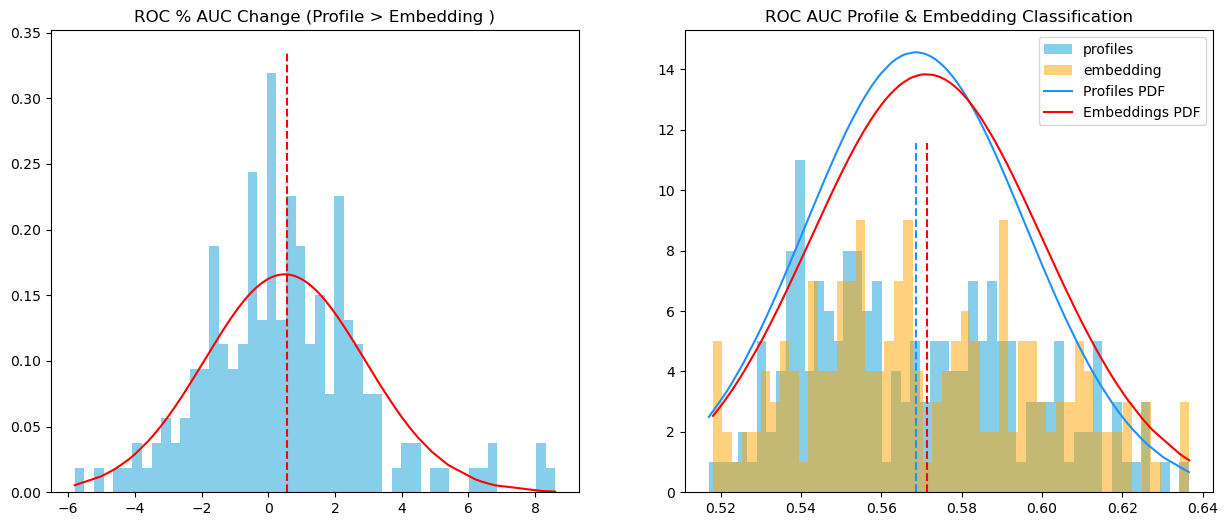

In [60]:
fig, axes = plt.subplots(1,2, figsize=(15,6))
bins_d = df_metrics.ms_diff_pct
bins_p = df_metrics.mean_test_score_p.to_numpy()
bins_e = df_metrics.mean_test_score_e.to_numpy()

bins = axes[0].hist(df_metrics.ms_diff_pct, color ='skyblue', bins=50, density = True )
y0,y1 = axes[0].get_ylim()
plot_norm(df_metrics.ms_diff_pct, axes[0], label = 'pdf')
_ = axes[0].set_title('ROC % AUC Change (Profile > Embedding )')
_ = axes[0].vlines(bins_p.mean(), y0,y1, linestyle = 'dashed', color = 'red')

_ = axes[1].hist(df_metrics.mean_test_score_p, color ='skyblue', label= 'profiles', bins=50, density = False)
_ = axes[1].hist(df_metrics.mean_test_score_e, color = 'orange', label='embedding', bins=50, alpha = 0.5, density = False)
y0,y1 = axes[1].get_ylim()
plot_norm(df_metrics.mean_test_score_p, axes[1], color = 'dodgerblue', label = 'Profiles PDF')
plot_norm(df_metrics.mean_test_score_e, axes[1], color = 'red', label = 'Embeddings PDF')
_ = axes[1].vlines(df_metrics.mean_test_score_p.mean(), y0,y1, linestyle = 'dashed', color = 'dodgerblue')
_ = axes[1].vlines(df_metrics.mean_test_score_e.mean(), y0,y1, linestyle = 'dashed', color = 'red')
_ = axes[1].set(title='ROC AUC Profile & Embedding Classification')
_ = axes[1].legend()

for col, name in [('ms_diff_pct', 'ROC AUC Change %'), ('mean_test_score_p', 'ROC AUC Profiles'), ('mean_test_score_e', 'ROC_AUC Emebdding') ]:
    print(f"{name:20s}:    mean: {df_metrics[col].mean():8.5f}   std: {df_metrics[col].std():8.5f}   min: {df_metrics[col].min():8.5f}   max: {df_metrics[col].max():8.5f}")
print('\n')

 ROC_AUC change:  Mean: 0.49406  Std: 2.41152


(array([ 7., 38., 82., 45.,  7.,  6.]),
 array([-5.83131848, -3.41931338, -1.00730828,  1.40469682,  3.81670191,  6.22870701,  8.64071211]),
 <BarContainer object of 6 artists>)

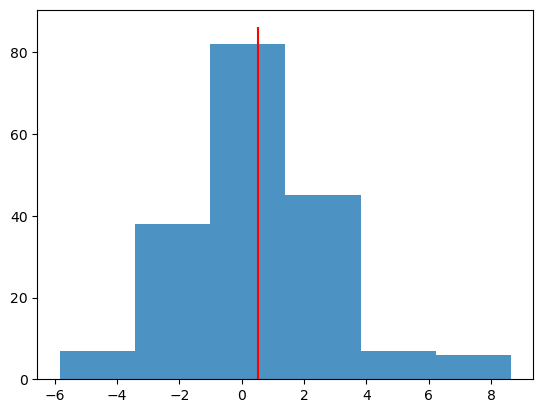

In [107]:
# Mean = 0, SD = 2.
diff_mean, diff_std = s_diff.mean(), s_diff.std()
# plt.plot(x_axis, sps.norm.pdf(x_axis,0,2), color = 'yellow')
x_axis = np.arange(-10, 10, 0.001)
print(f" ROC_AUC change:  Mean: {diff_mean:0.5f}  Std: {diff_std:0.5f}")

plt.hist(s_diff, bins = 6, alpha = 0.8)
plt.vlines(0.51652, plt.ylim()[0], plt.ylim()[1], colors='red', linestyles='solid', label='', data=None,)
plt.show()

# print(f" num of bits where Profile Score > Embedded score : {df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'both')]})

In [719]:
# grp = -5
# indicies =df_metrics[df_metrics.ms_diff_grp == grp].index
# print(indicies)
# df_metrics.loc[indicies]
# df_metrics.loc[indicies, ['Y_bit', 'mean_test_score_p', 'mean_test_score_e','Y_bit_pct', 'ms_diff']]

## ROC Plots

-4 5


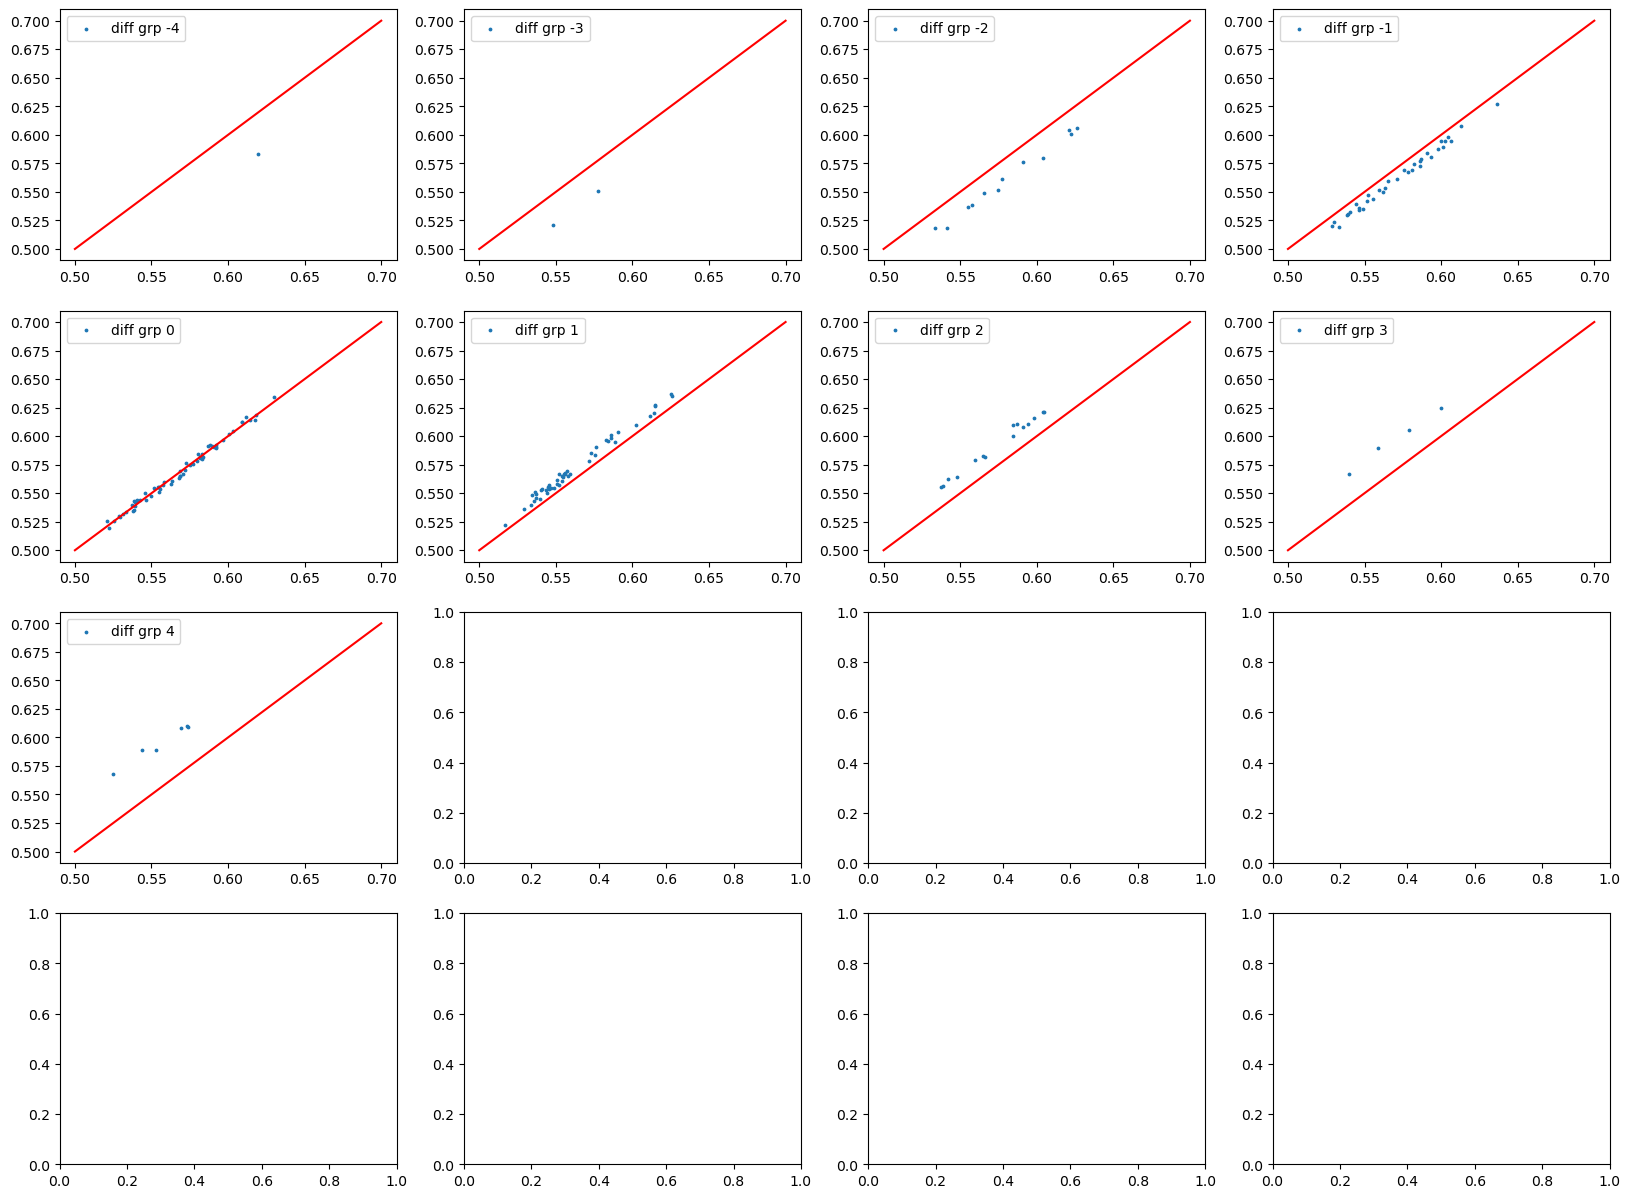

In [61]:
# _ = plt.figure(figsize = (15,15))
col = 'ms_diff_grp'
MIN = df_metrics[col].min().astype(np.int8)
MAX = df_metrics[col].max().astype(np.int8)
print(MIN, MAX)
fig, axes = plt.subplots(4,4, figsize=(20,15))
# type(fig), type(axes), axes.shape, type(axes.flat)
for ax, grp in zip(axes.flat, range(MIN,MAX)):
    indicies = (df_metrics.ms_diff_grp == grp)
 
    _ = ax.scatter(df_metrics[indicies].mean_test_score_p, df_metrics[indicies].mean_test_score_e, s= 3.0, label = f'diff grp {grp}')
    _ = ax.plot([0.5,0.7],[0.5,0.7], color = 'r')
    _ = ax.legend()

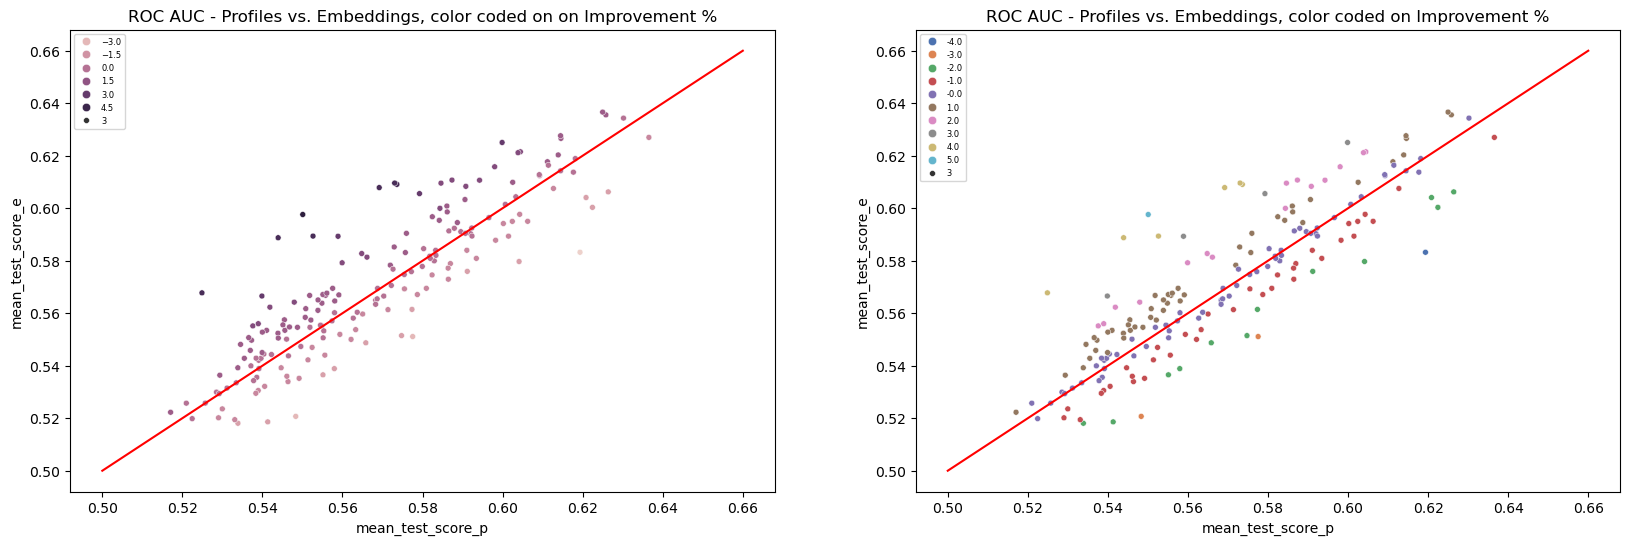

In [64]:
# plt.figure(figsize = (10,6))
fig, axes = plt.subplots(1,2, figsize=(20,6))
_ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', legend ='brief',size = 3, ax = axes[0])
_ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', palette = 'deep', legend ='brief',size = 3, ax = axes[1])
_ = axes[0].set_title('ROC AUC - Profiles vs. Embeddings, color coded on on Improvement %')
_ = axes[0].legend(fontsize='6', title_fontsize='12')
_ = axes[0].plot([0.5,0.66],[0.5,0.66], color = 'r')
_ = axes[1].set_title('ROC AUC - Profiles vs. Embeddings, color coded on Improvement %')
_ = axes[1].legend(fontsize='6', title_fontsize='12')
_ = axes[1].plot([0.5,0.66],[0.5,0.66], color = 'r')
# plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

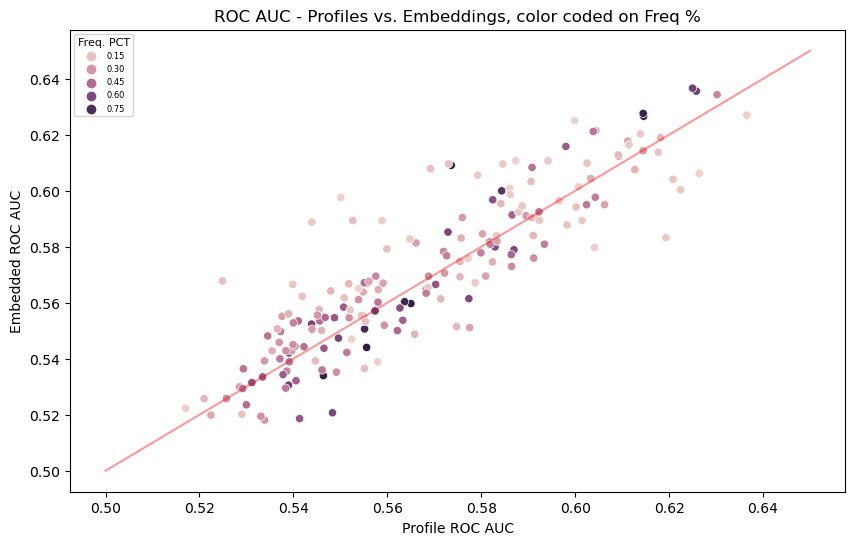

In [173]:
fig, axes = plt.subplots(1,1,figsize = (10,6))
ax = axes
_ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'Y_bit_pct', legend ='brief', ax = ax)
_ = ax.set_title('ROC AUC - Profiles vs. Embeddings, color coded on Freq %', loc = 'center')
_ = ax.legend(title = 'Freq. PCT', fontsize='6', title_fontsize='8', )
_ = ax.plot([0.5,0.65],[0.5,0.65], color = 'r', alpha = 0.4,)
_ = ax.set_xlabel('Profile ROC AUC')
_ = ax.set_ylabel('Embedded ROC AUC')
# ax = axes[1]
# _ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 's_diff', legend ='brief', ax = axes[1] )
# _ = axes[1].set_title('ROC AUC - Profiles vs. Embeddings, color coded on ROC Difference', loc = 'center')
# _ = axes[1].legend(title = 'Freq. PCT', fontsize='6', title_fontsize='8', )
# _ = axes[1].plot([0.5,0.65],[0.5,0.65], color = 'r', alpha = 0.4,)
# _ = axes[1].set_xlabel('Profile ROC AUC')
# _ = axes[1].set_ylabel('Embedded ROC AUC')


In [504]:
# _ = plt.figure(figsize = (12,12))
# _ = sns.scatterplot(data= df_metrics, x = 'mean_test_score_p', y = 'mean_test_score_e', hue = 'ms_diff_grp', palette = 'deep', legend ='brief', size = 3)
# _ = plt.legend(fontsize='6', title_fontsize='14')
# _ = plt.title('ROC AUC - Profiles vs. Embeddings, grouped by ROC_AUC Difference')
# _ = plt.plot([0.5,0.65],[0.5,0.65], color = 'r')

## List Metrics - ROC Diff Pct

In [66]:
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
# df_metrics.loc[indicies,['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_grp', 'ms_diff_pct',  'ms_diff_pct_grp', 'Y_bit_description']]
indicies = df_metrics[df_metrics.ms_diff_pct_grp <= -5.0].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 3
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
     117       366        0.13056        0.61934        0.58322         -5.80         Aromatic Aromatic Aromatic |0 1 1|1 0 0|1 0 0|    
      50       103        0.61005        0.54832        0.52070         -5.00         Acceptor Acceptor Hydrophobe |0 1 1|1 0 1|1 1 0|  
     130       421        0.25249        0.57754        0.55112         -4.60         Aromatic Donor Donor |0 1 0|1 0 1|0 1 0|          


In [69]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-5.0, 0, 'right')].index
display_metrics(df_metrics, indicies)

 Number of rows: 95
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
       1         1        0.84117        0.55559        0.54403         -2.10         Acceptor Acceptor |0 1|1 0|                       
       3         4        0.53049        0.54650        0.54375         -0.50         Acceptor Donor |0 0|0 0|                          
       4         5        0.82043        0.56503        0.55970         -0.90         Acceptor Donor |0 1|1 0|                          
       5         6        0.81266        0.54639        0.53395         -2.30         Acceptor Hydrophobe |0 0|0 0|                     
       9        16        0.38627        0.60426        0.59768         -1.10         Aromatic Aromatic |0 0|0 0|                

In [70]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(0.0, 5.0, 'right')].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 80
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
      45        96        0.28964        0.53966        0.54284          0.60         Acceptor Acceptor Hydrophobe |0 0 0|0 0 0|0 0 0|  
     175       677        0.17571        0.60916        0.61278          0.60         Donor LumpedHydrophobe LumpedHydrophobe |0 1 0|1 0 1|0 1 0|
      21        32        0.63447        0.53907        0.54208          0.60         Donor Hydrophobe |0 0|0 0|                        
     172       645        0.24819        0.58027        0.58459          0.70         Donor Hydrophobe LumpedHydrophobe |0 1 0|1 0 1|0 1 0|
      33        53        0.34946        0.63020        0.63433          0.70         LumpedHydrophobe LumpedHydropho

In [71]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(5.0, 10.0, 'right')].sort_values('ms_diff_pct').index
display_metrics(df_metrics, indicies)

 Number of rows: 7
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
       2         2        0.84153        0.57360        0.60908          6.20         Acceptor Aromatic |0 0|0 0|                       
     148       468        0.15406        0.57303        0.60960          6.40         Aromatic Hydrophobe Hydrophobe |0 1 0|1 0 0|0 0 0|
     177       752        0.16474        0.55264        0.58939          6.60         Hydrophobe Hydrophobe Hydrophobe |0 0 0|0 0 0|0 0 0|
     178       756        0.15471        0.56917        0.60786          6.80         Hydrophobe Hydrophobe Hydrophobe |0 1 0|1 0 0|0 0 0|
      88       202        0.15874        0.52489        0.56777          8.20         Acceptor Donor Hydrophobe |0 0 1|0 0 0|1

In [73]:
indicies = df_metrics.sort_values(['fp_groups', 'ms_diff_pct']).index
display_metrics(df_metrics, indicies)

 Number of rows: 185
                                         Profile       Embedding       ROC Diff   
   index      FP bit       Freq %        ROC AUC        ROC AUC           Pct         Description 
   -----      ------     ----------     ---------      ---------       --------       ----------------------------------
       1         1        0.84117        0.55559        0.54403         -2.10         Acceptor Acceptor |0 1|1 0|                       
       0         0        0.51183        0.55069        0.55843          1.40         Acceptor Acceptor |0 0|0 0|                       
      36        79        0.32289        0.54916        0.53520         -2.50         Acceptor Acceptor Acceptor |0 1 1|1 0 1|1 1 0|    
      35        78        0.40333        0.55801        0.56019          0.40         Acceptor Acceptor Acceptor |0 1 1|1 0 0|1 0 0|    
      38        83        0.35227        0.53859        0.53557         -0.60         Acceptor Acceptor Aromatic |0 0 1|0 0 1|1 

## FP Group Box Plots

In [241]:
df1 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_p, 'group': 'profiles'})
df2 = pd.DataFrame({'FP_bit':df_metrics.Y_bit, 'FP_Family':df_metrics.fp_groups, 'roc_auc' : df_metrics.mean_test_score_e, 'group': 'embeddings'})

df1.index
df2.index
df_boxplot = pd.concat([df1,df2])
df_boxplot.sort_values(['FP_bit', 'group'],  inplace = True)
df_boxplot.reset_index(inplace=True)
df_boxplot.info()
df_boxplot


RangeIndex(start=0, stop=185, step=1)

RangeIndex(start=0, stop=185, step=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      370 non-null    int64  
 1   FP_bit     370 non-null    int64  
 2   FP_Family  370 non-null    object 
 3   roc_auc    370 non-null    float64
 4   group      370 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 14.6+ KB


index  FP_bit                                     FP_Family   roc_auc       group
0        0       0                             Acceptor Acceptor  0.558431  embeddings
1        0       0                             Acceptor Acceptor  0.550693    profiles
2        1       1                             Acceptor Acceptor  0.544030  embeddings
3        1       1                             Acceptor Acceptor  0.555593    profiles
4        2       2                             Acceptor Aromatic  0.609081  embeddings
..     ...     ...                                           ...       ...         ...
365    182     766        Hydrophobe Hydrophobe LumpedHydrophobe  0.584176    profiles
366    183     767        Hydrophobe Hydrophobe LumpedHydrophobe  0.609880  embeddings
367    183     767        Hydrophobe Hydrophobe LumpedHydrophobe  0.602520    profiles
368    184     797  Hydrophobe LumpedHydrophobe LumpedHydrophobe  0.620303  embeddings
369    184     797  Hydrophobe LumpedHydrophobe LumpedHydrophobe  0.613896    profiles

[370 rows x 5 columns]

In [ ]:
sns.__version__
FP_GROUPS_SORTED = sorted(FP_GROUPS)
len(FP_GROUPS_SORTED)

In [40]:
for idx, grp in enumerate (FP_GROUPS_SORTED):
    print(f"  {idx:4d}  {grp:60s}")

     0  Acceptor Acceptor                                           
     1  Acceptor Acceptor Acceptor                                  
     2  Acceptor Acceptor Aromatic                                  
     3  Acceptor Acceptor Donor                                     
     4  Acceptor Acceptor Hydrophobe                                
     5  Acceptor Acceptor LumpedHydrophobe                          
     6  Acceptor Acceptor PosIonizable                              
     7  Acceptor Aromatic                                           
     8  Acceptor Aromatic Aromatic                                  
     9  Acceptor Aromatic Donor                                     
    10  Acceptor Aromatic Hydrophobe                                
    11  Acceptor Aromatic LumpedHydrophobe                          
    12  Acceptor Aromatic PosIonizable                              
    13  Acceptor Donor                                              
    14  Acceptor Donor Donor      

## Comparative Box Plots - 1 , Chart Per Group

In [256]:
indicies_1 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[:14])].index
indicies_2 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[14:28])].index
indicies_3 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[28:42])].index
indicies_4 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS[42:57])].index

In [ ]:
plot_boxplots(df_boxplot, indicies_1)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

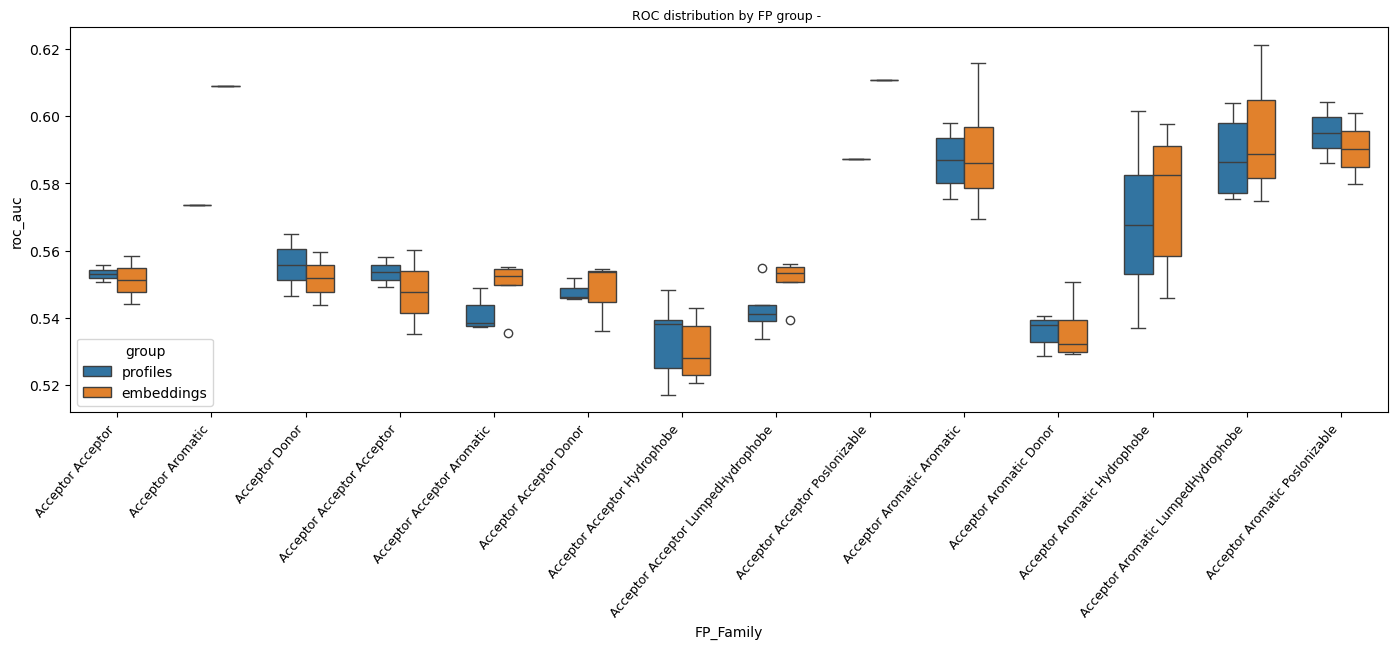

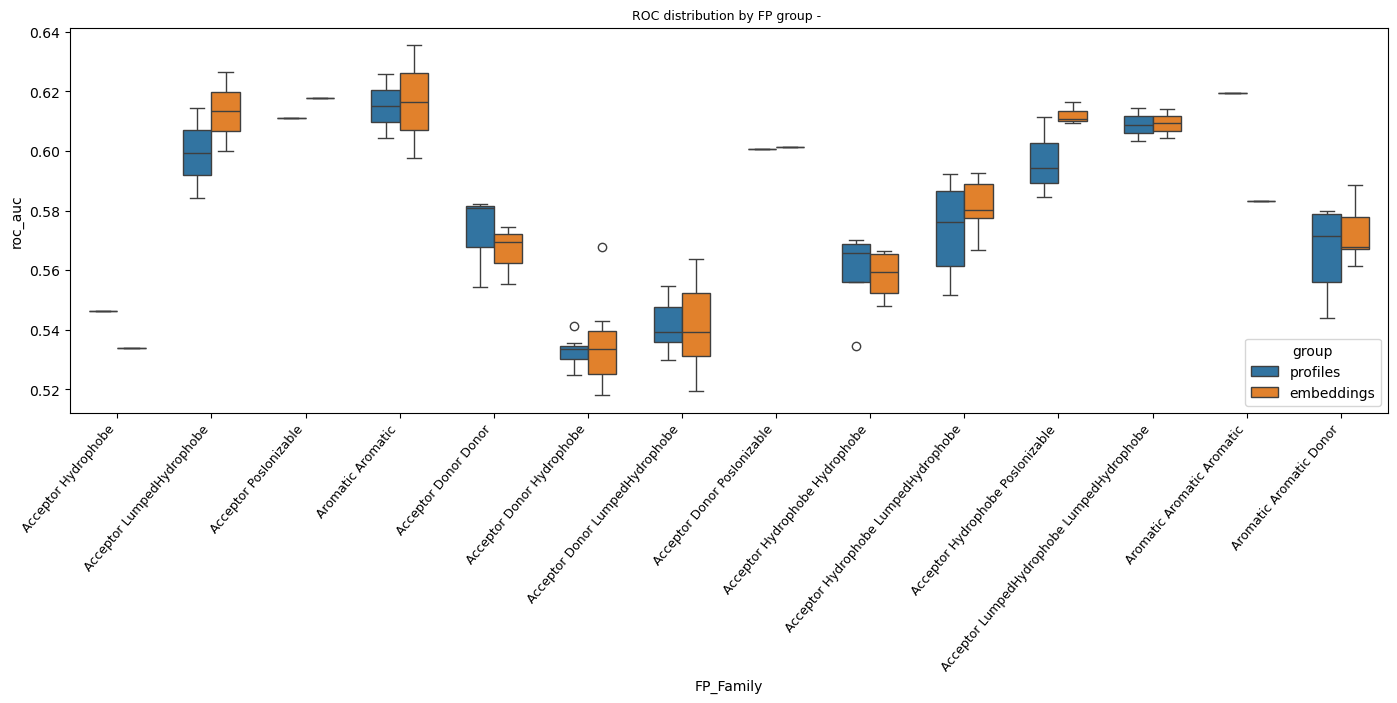

In [ ]:
plot_boxplots(df_boxplot, indicies_2)

In [ ]:
plot_boxplots(df_boxplot, indicies_3)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

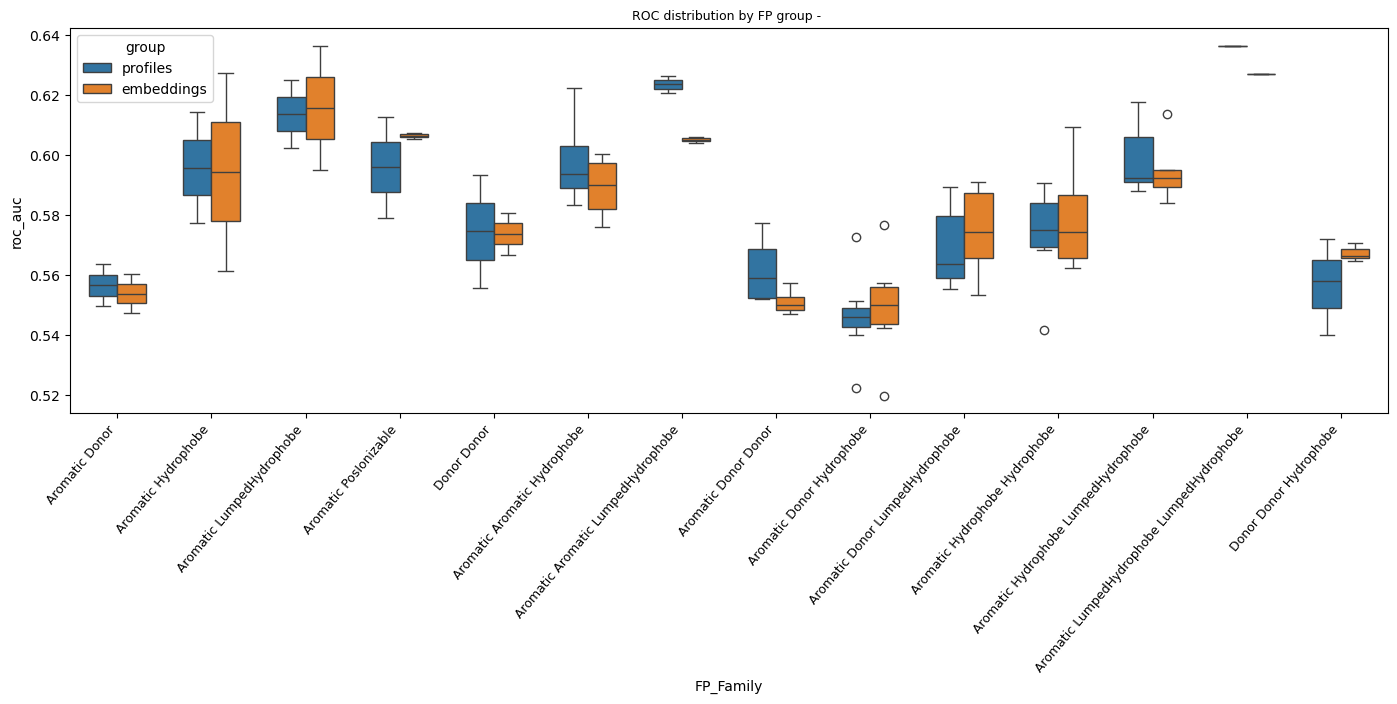

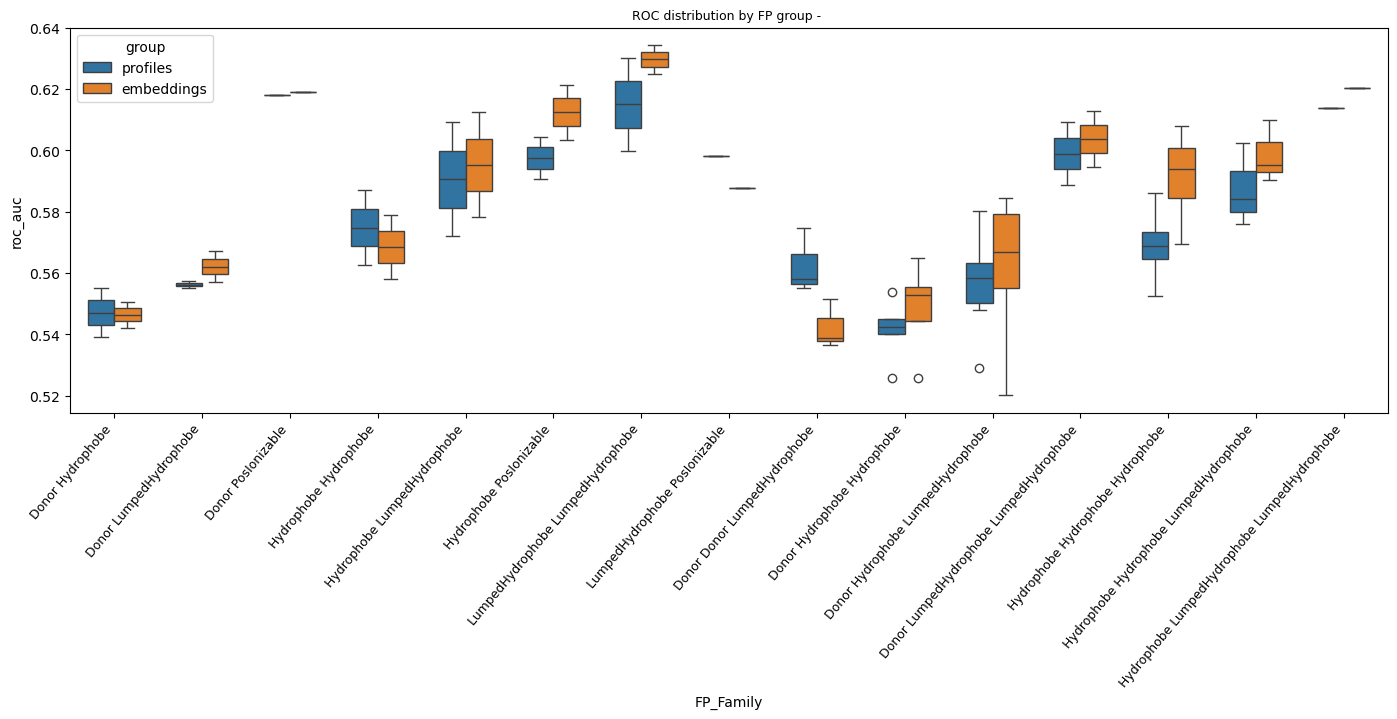

In [ ]:
plot_boxplots(df_boxplot, indicies_4)

## Comparative Box Plots - 2 , Chart Per Group

In [77]:
indicies_1 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[:15])].index
indicies_2 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[15:30])].index
indicies_3 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[30:45])].index
indicies_4 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[45:60])].index
# indicies_5 = df_boxplot[df_boxplot.FP_Family.isin( FP_GROUPS_SORTED[60:70])].index

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

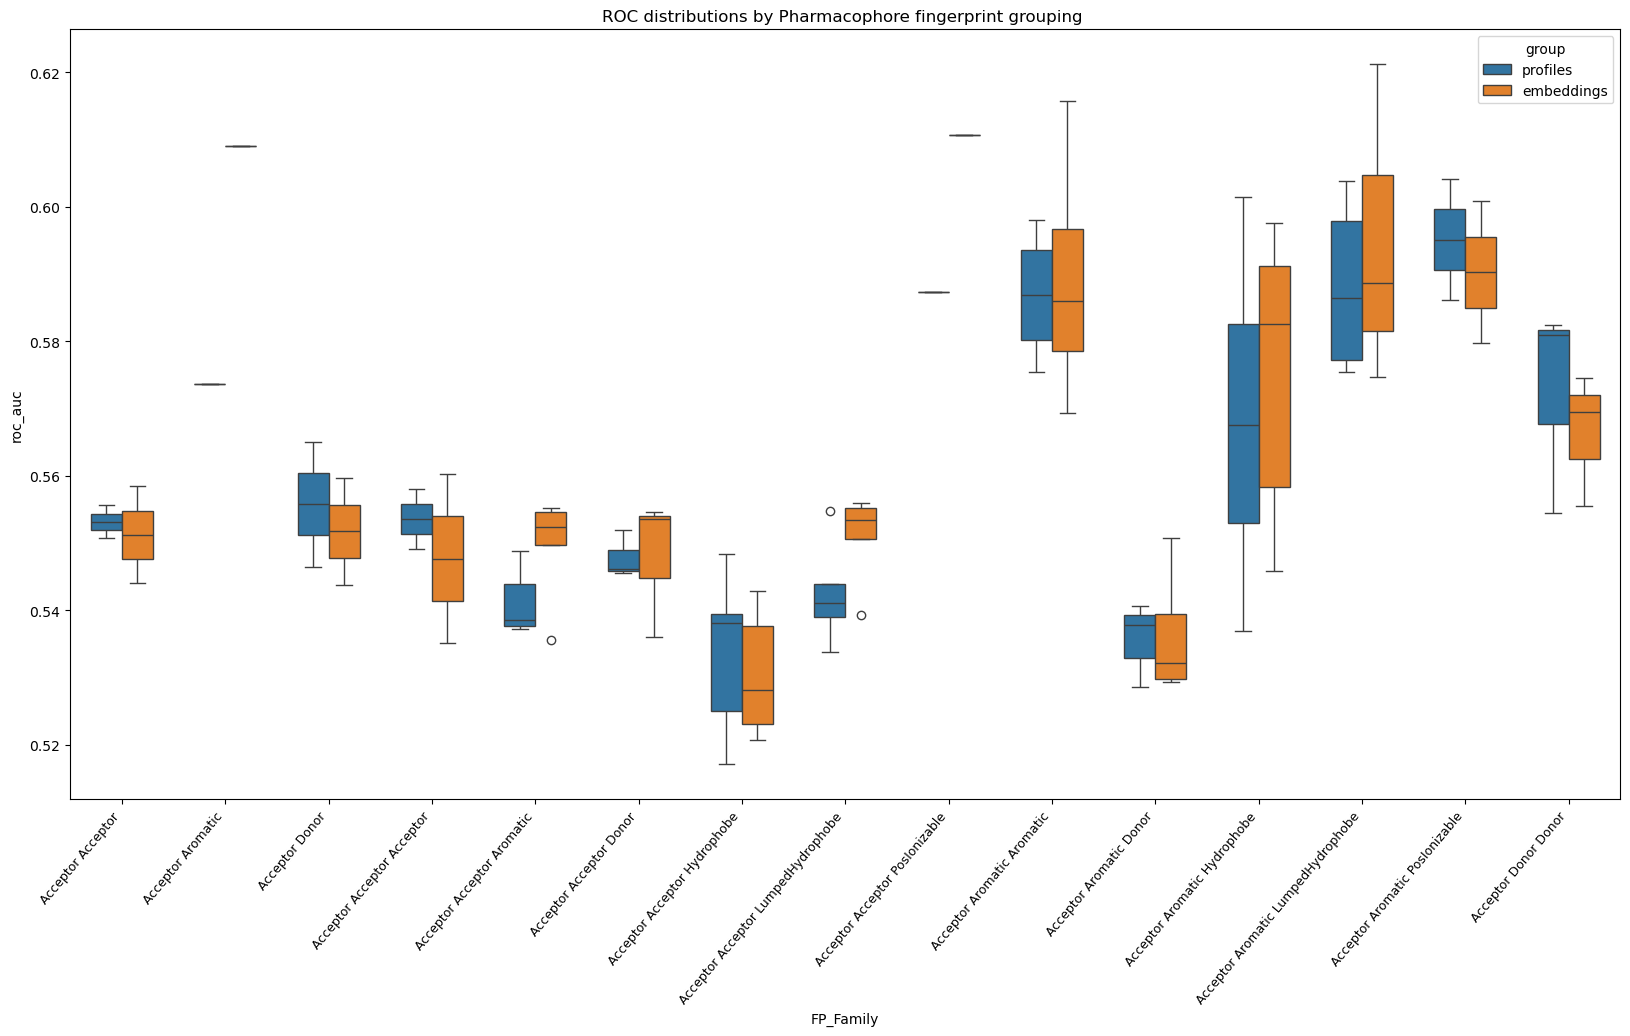

In [80]:
plot_boxplots(indicies_1)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

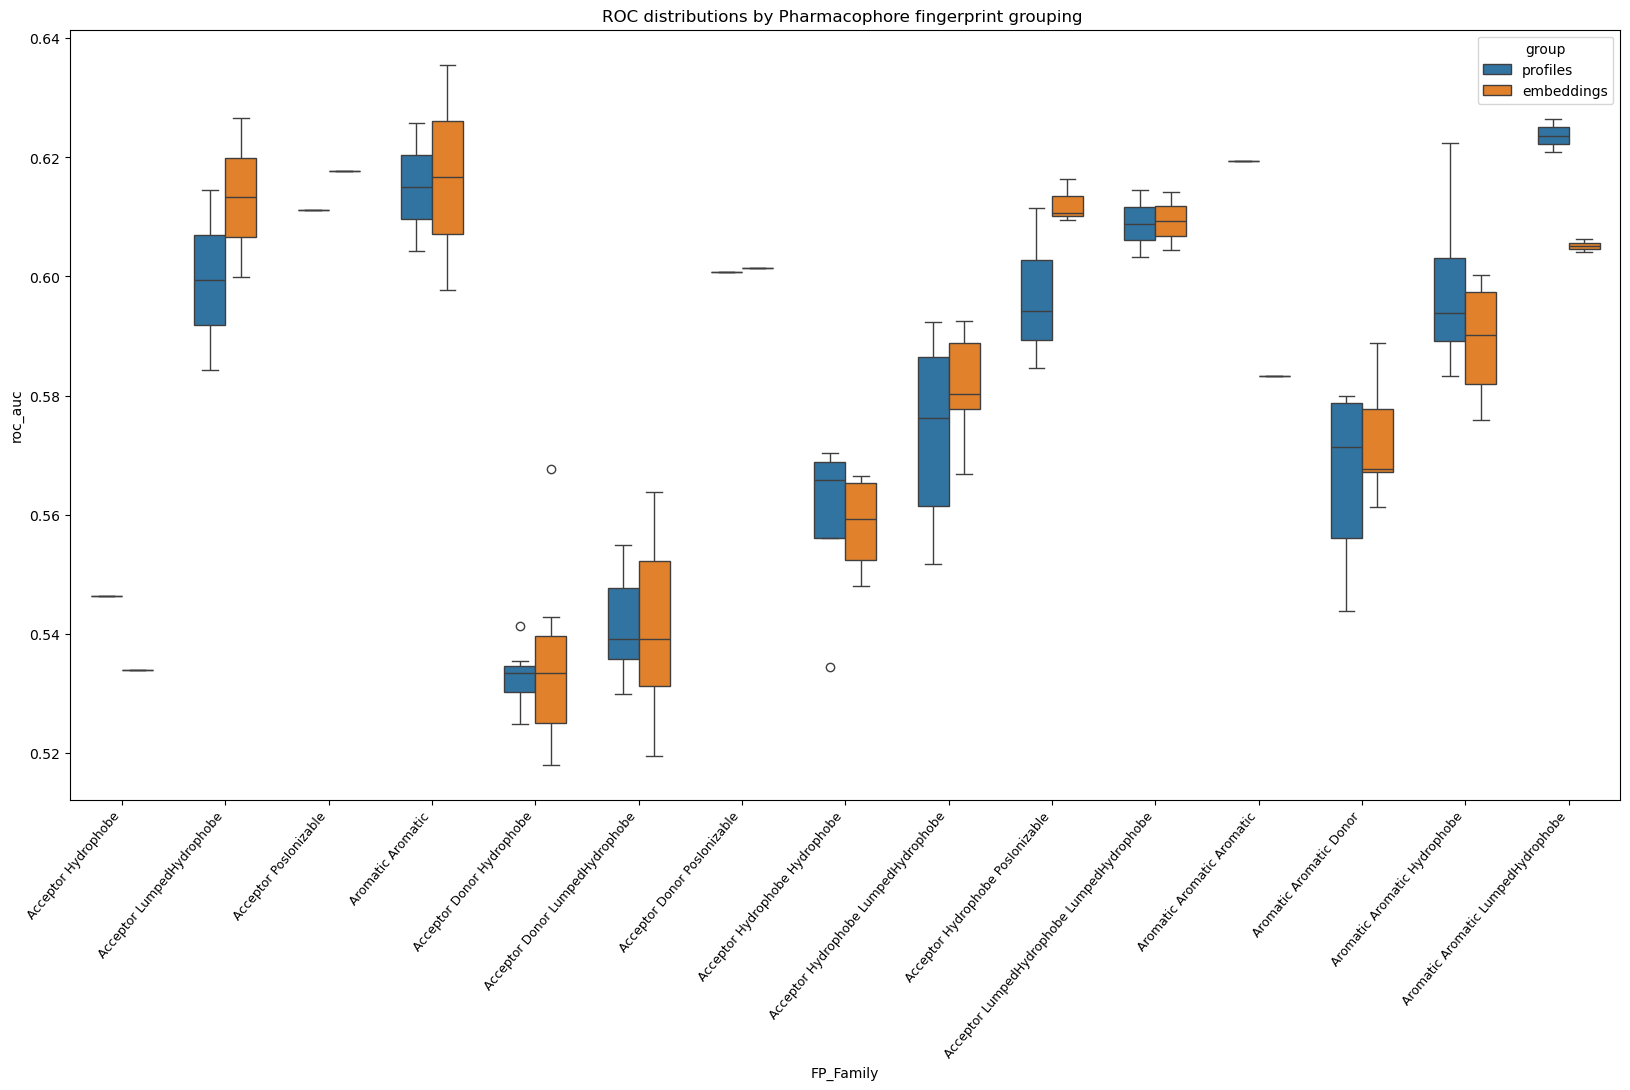

In [81]:
plot_boxplots(indicies_2)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

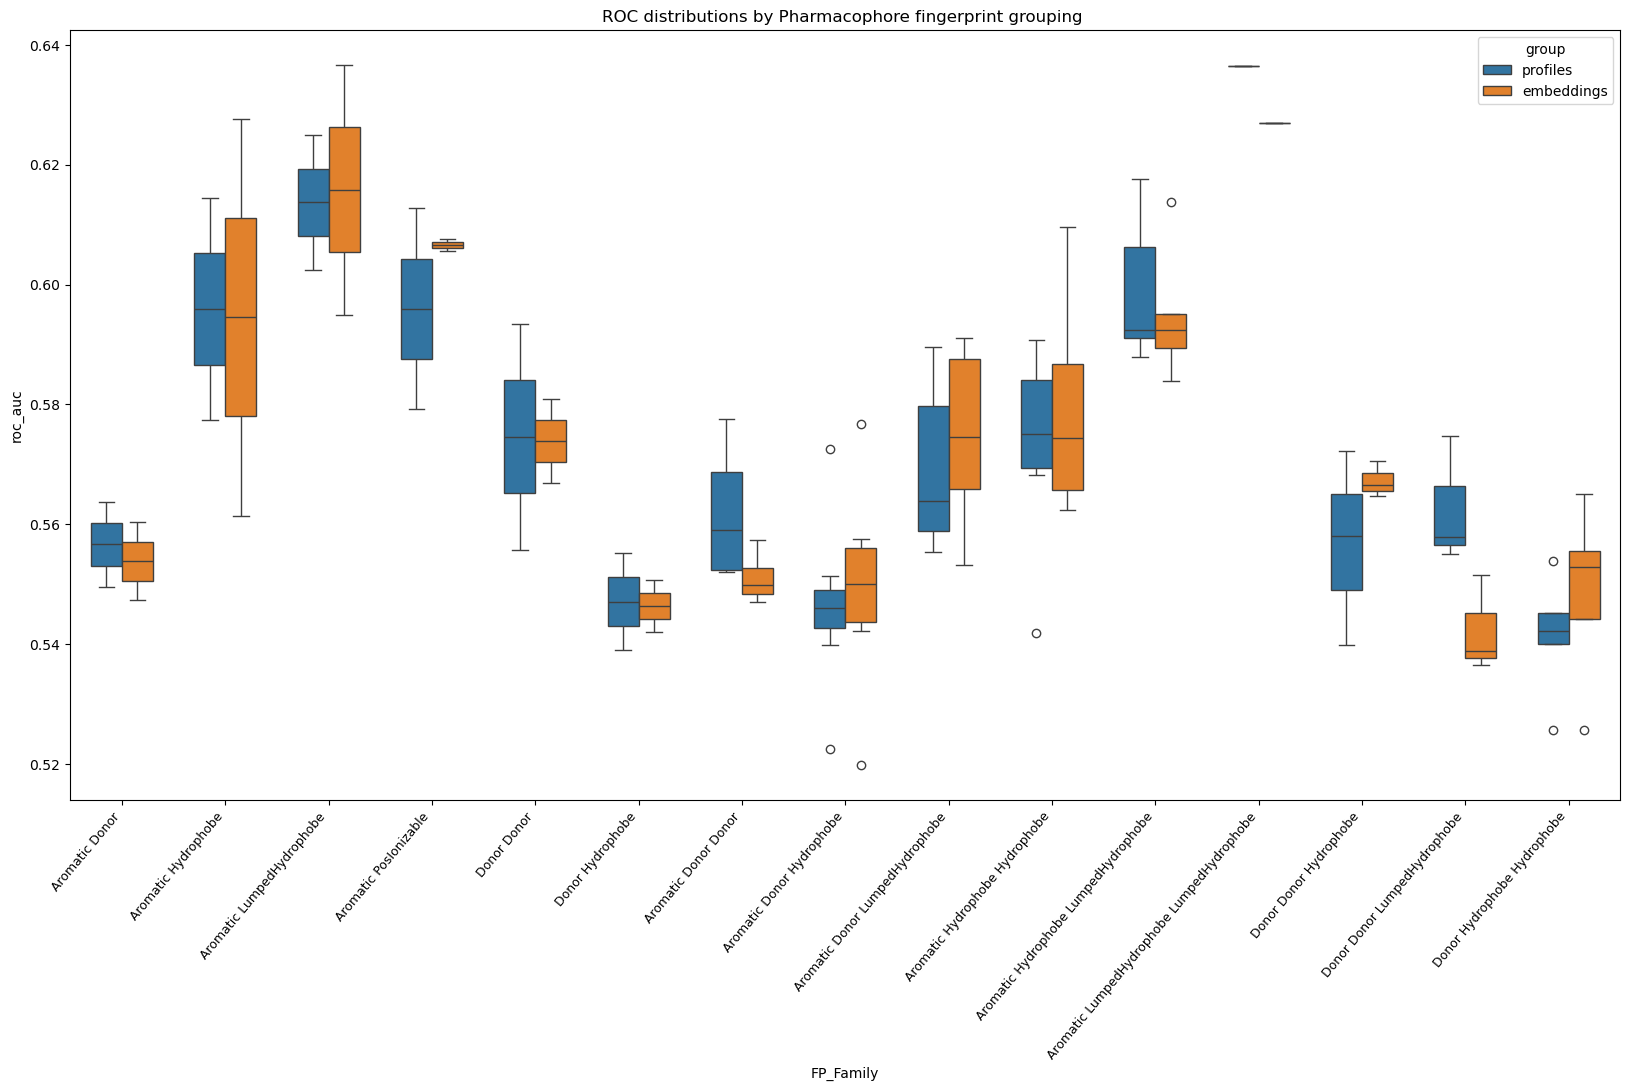

In [82]:
plot_boxplots(indicies_3)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/seaborn/categorical.p

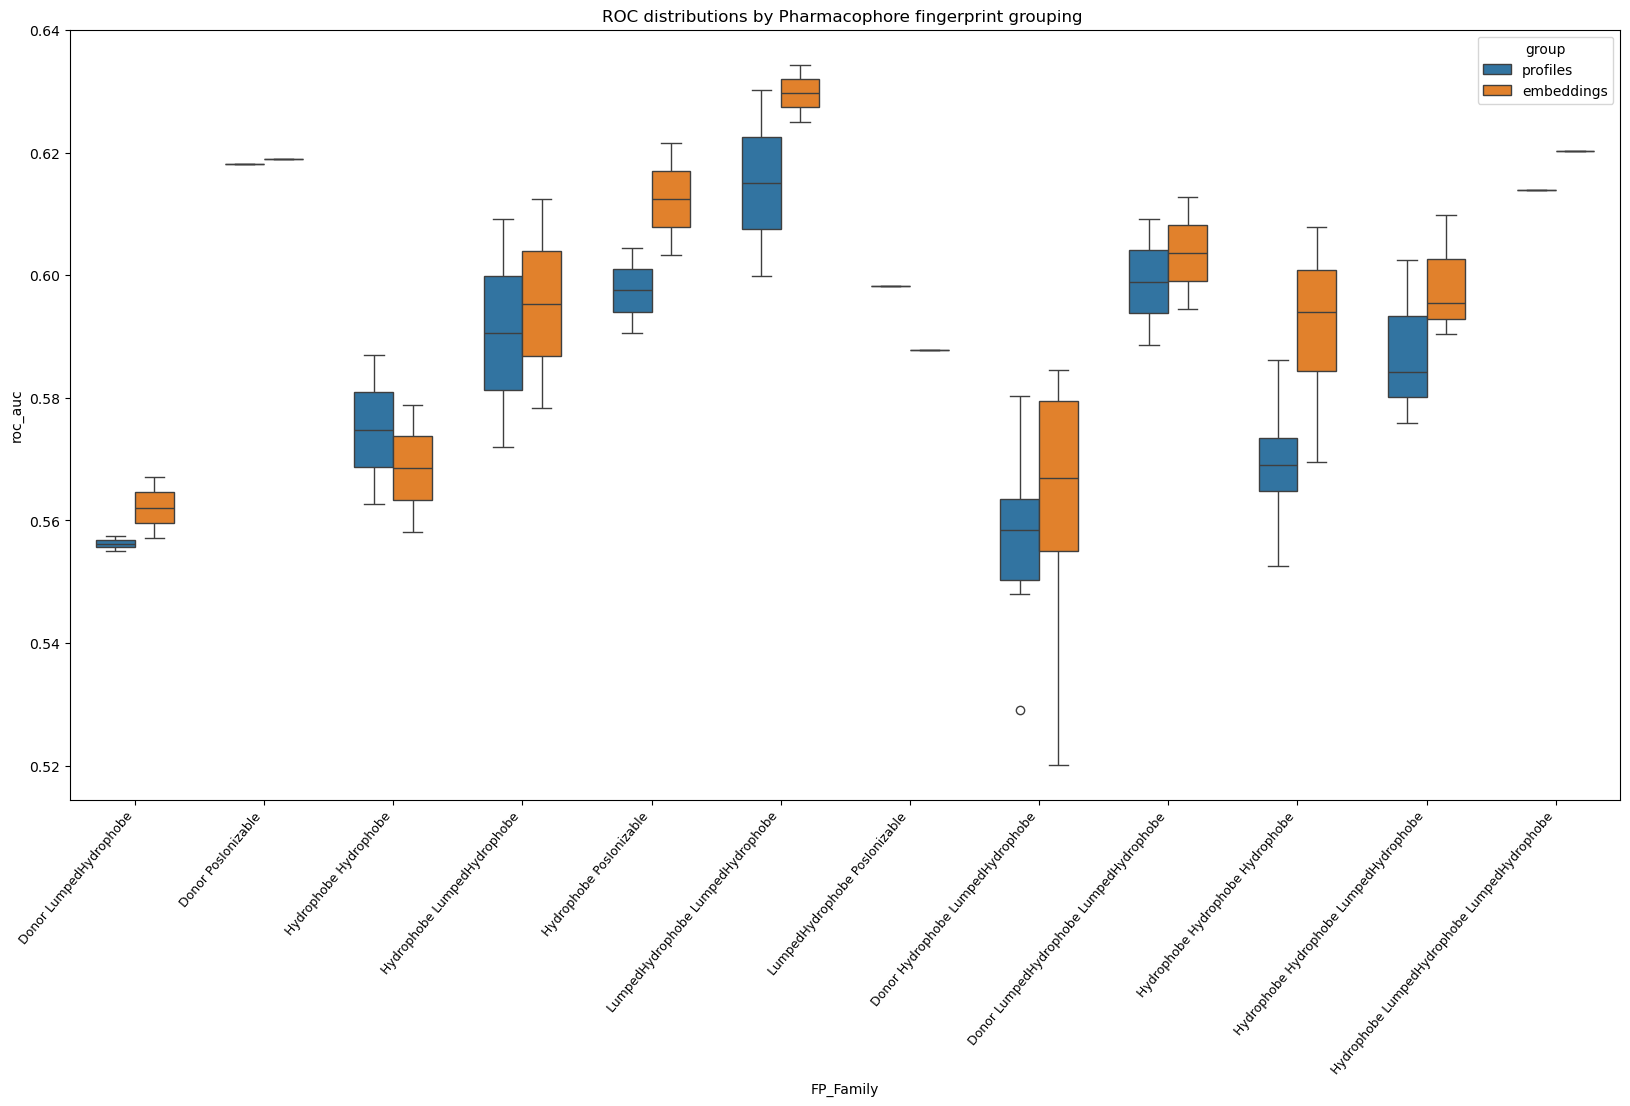

In [83]:
plot_boxplots(indicies_4)

In [200]:
# data from https://allisonhorst.github.io/palmerpenguins/

# import matplotlib.pyplot as plt
# import numpy as np

# Fingerprint_bits = profile_best_metrics.Y_bit
# scores = {
#     'Profiles': profile_best_metrics.mean_test_score,
#     'Embeddings': embedded_best_metrics.mean_test_score,
# }

# x = np.arange(len(Fingerprint_bits))  # the label locations
# width = 0.3  # the width of the bars
# multiplier = 0

# # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
# fig, ax = plt.subplots(figsize=(20,6))

# # for attribute, measurement in test_scores.items():
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Profiles'] , width, label='Profiles')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');
# multiplier += 1
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Embeddings'] , width, label='Embeddings')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');

# # Add some text for labels, title and custom x-axis tick labels, etc.
# _ = ax.set_ylabel('ROC AUC')
# _ = ax.set_xlabel('Fingerprint Descriptor ID')
# _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
# _ = ax.set_xticks(x + width/2, Fingerprint_bits)
# _ = ax.legend(loc='upper left', ncols=3)
# _ = ax.set_ylim(0.4, 0.75)
# _ = ax.set_xlim(-1, 37)
 


## Group by fp_groups

In [209]:
grouped_data = df_metrics.groupby('fp_groups') ## , group_keys = 'ms_diff_pct')
grouped_data_indicies = grouped_data.groups
pp.pprint(grouped_data_indicies)
# type(grouped_data)
# len(grouped_data)
gd_mean = grouped_data[['mean_test_score_p', 'mean_test_score_e','ms_diff_pct']].mean()
FP_GROUPS = list(grouped_data.groups.keys())
len(FP_GROUPS)

{'Acceptor Acceptor': [0, 1], 'Acceptor Acceptor Acceptor': [35, 36], 'Acceptor Acceptor Aromatic': [37, 38, 39, 40, 41], 'Acceptor Acceptor Donor': [42, 43, 44], 'Acceptor Acceptor Hydrophobe': [45, 46, 47, 48, 49, 50], 'Acceptor Acceptor LumpedHydrophobe': [51, 52, 53, 54, 55], 'Acceptor Acceptor PosIonizable': [56], 'Acceptor Aromatic': [2], 'Acceptor Aromatic Aromatic': [57, 58, 59, 60], 'Acceptor Aromatic Donor': [61, 62, 63, 64, 65, 66, 67], 'Acceptor Aromatic Hydrophobe': [68, 69, 70, 71, 72, 73, 74, 75], 'Acceptor Aromatic LumpedHydrophobe': [76, 77, 78, 79, 80, 81], 'Acceptor Aromatic PosIonizable': [82, 83], 'Acceptor Donor': [3, 4], 'Acceptor Donor Donor': [84, 85, 86], 'Acceptor Donor Hydrophobe': [87, 88, 89, 90, 91, 92, 93], 'Acceptor Donor LumpedHydrophobe': [94, 95, 96, 97, 98, 99, 100], 'Acceptor Donor PosIonizable': [101], 'Acceptor Hydrophobe': [5], 'Acceptor Hydrophobe Hydrophobe': [102, 103, 104, 105], 'Acceptor Hydrophobe LumpedHydrophobe': [106, 107, 108, 109, 11

57

In [179]:
sel_group = grouped_data.get_group('Acceptor Donor')
sel_group

Y_bit  Y_bit_pct  Y_bit_pct_grp  mean_test_score_p  mean_test_score_e   ms_diff  ms_diff_grp  ms_diff_pct  ms_diff_pct_grp  \
3      4   0.530487            5.0           0.546499           0.543749 -0.002750         -0.0         -0.5             -0.0   
4      5   0.820433            8.0           0.565028           0.559701 -0.005328         -1.0         -0.9             -1.0   

   ms_diff_norm       fp_groups         Y_bit_description  precision_p  accuracy_p  recall_p      f1_p  precision_e  accuracy_e  \
3     -0.065318  Acceptor Donor  Acceptor Donor |0 0|0 0|     0.539697    0.539921  0.788808  0.640897     0.525637    0.527460   
4     -0.096136  Acceptor Donor  Acceptor Donor |0 1|1 0|     0.812470    0.811746  0.998631  0.895983     0.812247    0.812143   

   recall_e      f1_e  
3  0.944190  0.675319  
4  0.999707  0.896280

In [200]:
gd_mean.sort_values('ms_diff_pct').head(60)
# df_metrics[df_metrics.ms_diff_pct_grp >10][['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_pct', 'ms_diff_grp', 'Y_bit_description']]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64][['index_p', 'Y_bit']]
# df_metrics[df_metrics[ 'mean_test_score_p'] < 0.52]

mean_test_score_p  mean_test_score_e  ms_diff_pct
fp_groups                                                                                      
Aromatic Aromatic Aromatic                             0.619336           0.583220    -5.800000
Donor Donor LumpedHydrophobe                           0.562612           0.542302    -3.566667
Aromatic Aromatic LumpedHydrophobe                     0.623617           0.605148    -2.950000
Acceptor Hydrophobe                                    0.546388           0.533952    -2.300000
Aromatic Donor Donor                                   0.561969           0.551058    -1.900000
LumpedHydrophobe PosIonizable                          0.598248           0.587804    -1.700000
Aromatic Aromatic Hydrophobe                           0.598366           0.589166    -1.525000
Aromatic LumpedHydrophobe LumpedHydrophobe             0.636540           0.626980    -1.500000
Hydrophobe Hydrophobe                                  0.574821           0.568521    -1.100000
Acceptor Acceptor Acceptor                             0.553586           0.547693    -1.050000
Acceptor Donor Donor                                   0.572610           0.566509    -1.033333
Acceptor Aromatic PosIonizable                         0.595095           0.590266    -0.750000
Acceptor Donor                                         0.555764           0.551725    -0.700000
Aromatic Hydrophobe LumpedHydrophobe                   0.599060           0.594899    -0.680000
Acceptor Acceptor Hydrophobe                           0.533684           0.530346    -0.600000
Aromatic Donor                                         0.556640           0.553855    -0.500000
Acceptor Acceptor                                      0.553143           0.551231    -0.350000
Aromatic Hydrophobe                                    0.595918           0.594534    -0.350000
Acceptor Hydrophobe Hydrophobe                         0.559105           0.558344    -0.125000
Donor Hydrophobe                                       0.547119           0.546355    -0.100000
Acceptor Donor LumpedHydrophobe                        0.541570           0.541369    -0.057143
Donor Donor                                            0.574602           0.573860    -0.050000
Acceptor Aromatic Donor                                0.535912           0.535779    -0.014286
Acceptor Acceptor Donor                                0.547861           0.548040     0.000000
Acceptor Donor PosIonizable                            0.600675           0.601484     0.100000
Acceptor LumpedHydrophobe LumpedHydrophobe             0.608887           0.609306     0.100000
Donor PosIonizable                                     0.618154           0.618920     0.100000
Aromatic Aromatic                                      0.615029           0.616621     0.250000
Aromatic LumpedHydrophobe                              0.613703           0.615809     0.350000
Acceptor Aromatic Aromatic                             0.586823           0.589275     0.400000
Acceptor Donor Hydrophobe                              0.532791           0.535526     0.542857
Aromatic Donor Hydrophobe                              0.546378           0.549464     0.542857
Hydrophobe LumpedHydrophobe                            0.590591           0.595364     0.800000
Donor LumpedHydrophobe LumpedHydrophobe                0.598926           0.603658     0.800000
Acceptor Aromatic LumpedHydrophobe                     0.587986           0.593739     0.983333
Aromatic Donor LumpedHydrophobe                        0.569147           0.574695     0.983333
Hydrophobe LumpedHydrophobe LumpedHydrophobe           0.613896           0.620303     1.000000
Donor Hydrophobe LumpedHydrophobe                      0.556492           0.562191     1.000000
Donor LumpedHydrophobe                                 0.556241           0.562101     1.050000
Acceptor PosIonizable                                  0.611199           0.617714     1.100000
Aromatic Hydro

In [199]:
FP_GROUPS_COUNT = df_metrics['fp_groups'].value_counts()
FP_GROUPS_COUNT.sort_index(inplace = True)
FP_GROUPS_COUNT[:10]

fp_groups
Acceptor Acceptor                     2
Acceptor Acceptor Acceptor            2
Acceptor Acceptor Aromatic            5
Acceptor Acceptor Donor               3
Acceptor Acceptor Hydrophobe          6
Acceptor Acceptor LumpedHydrophobe    5
Acceptor Acceptor PosIonizable        1
Acceptor Aromatic                     1
Acceptor Aromatic Aromatic            4
Acceptor Aromatic Donor               7
Name: count, dtype: int64

In [84]:
# for ctr, (keys, group_data) in enumerate(grouped_data):
#     print(f"{ctr:5d}     {keys:60} {group_data.mean_test_score_p.mean():0.4f}  {group_data.mean_test_score_e.mean():0.4f}  {group_data.ms_diff_pct.mean():8.4f}")
#     plt.boxplot(group_data.mean_test_score_p)
#     plt.show()
#     if ctr > 2:
#         break
# print(group_data.info())

In [85]:
# df_metrics[df_metrics.ms_diff_pct_grp >10][['Y_bit', 'Y_bit_pct', 'mean_test_score_p', 'mean_test_score_e', 'ms_diff', 'ms_diff_pct', 'ms_diff_grp', 'Y_bit_description']]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64]
# df_metrics[df_metrics[ 'mean_test_score_p'] > 0.64][['index_p', 'Y_bit']]
# df_metrics[df_metrics[ 'mean_test_score_p'] < 0.52]

In [201]:
# len(selected_label_indicies), len(selected_label_descriptions)
# fp_group_indices = dict()
# for idx, (bit_id, description) in enumerate(zip(selected_label_indicies, selected_label_descriptions)):
#     fp_group_name = selected_label_descriptions[idx].split('|')[0]
#     print(f" {idx:5d}      {bit_id:5d}      {selected_label_descriptions[idx]:60s}    [{fp_group_name}]")
#     # fp_group_indices[fp_group_name] = fp_group_indices.get(fp_group_name, 0) + 1
#     if fp_group_name in fp_group_indices:
#         fp_group_indices[fp_group_name].append(idx)
#     else:
#         fp_group_indices[fp_group_name] = [idx]

## Comparative Bar charts - 1

In [259]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(10.0, 25, 'right')].index.to_list()
len(indicies)
indicies[None:None]

0

[]

7

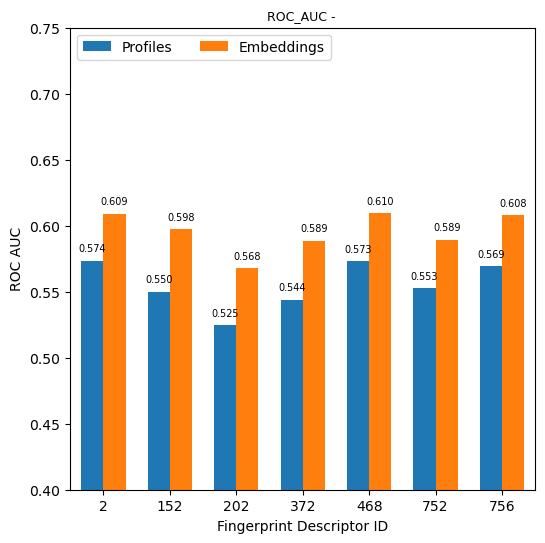

In [260]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(5.0, 25, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

21

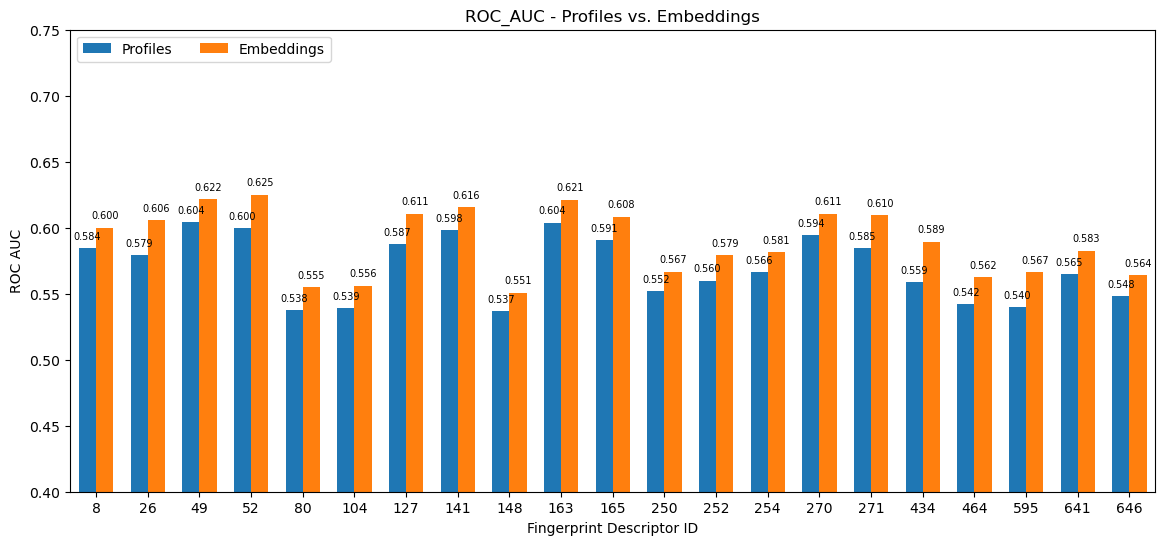

In [135]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(2.5, 5.0, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

27

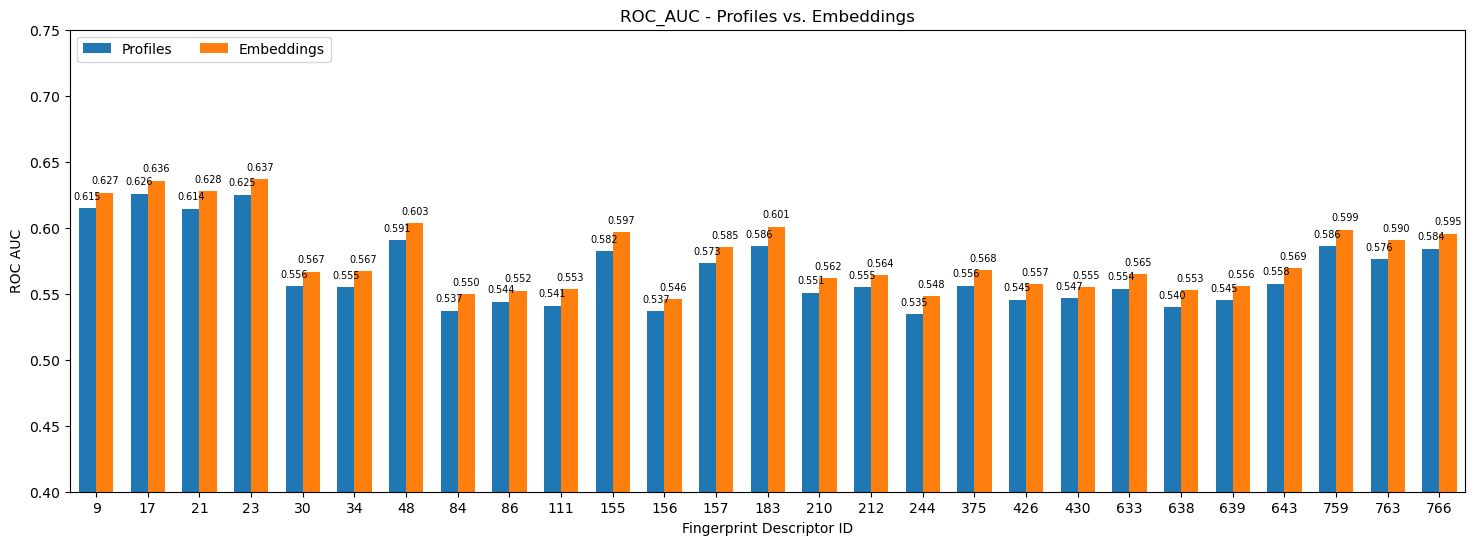

In [136]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(1.5, 2.5, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

32

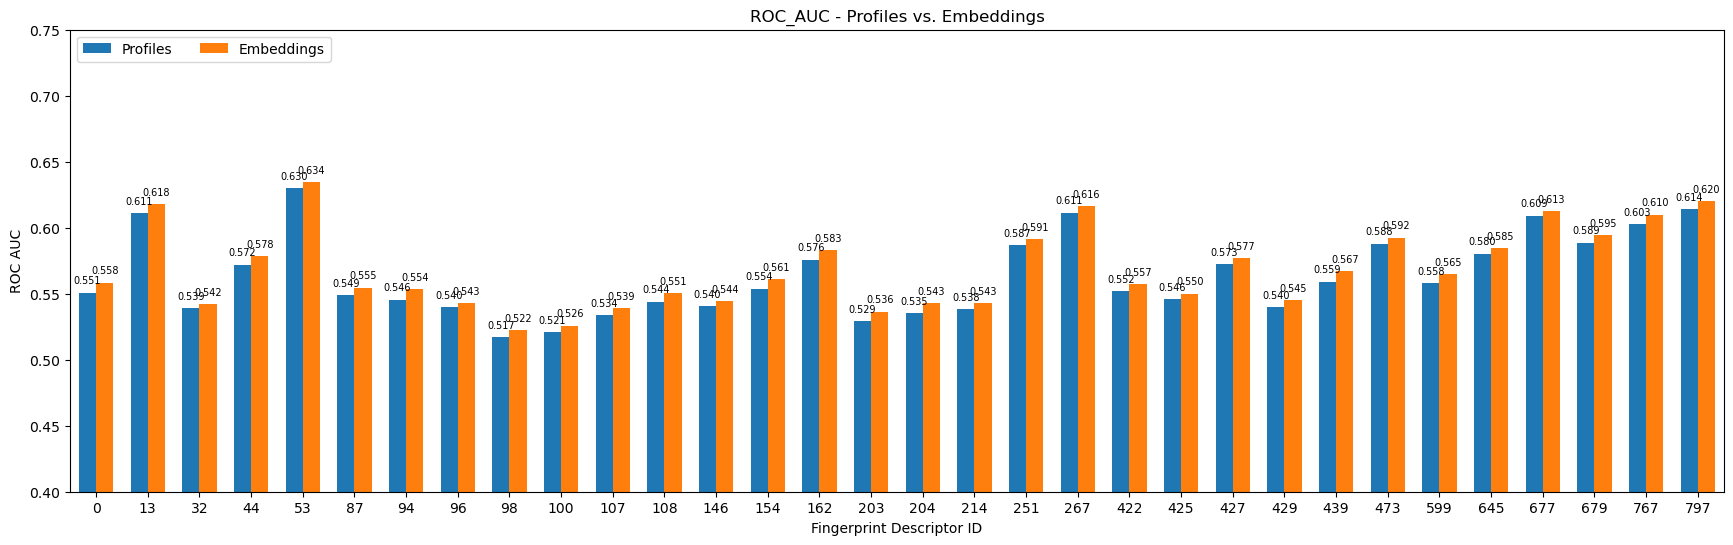

In [137]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(0.0, 1.5, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

38

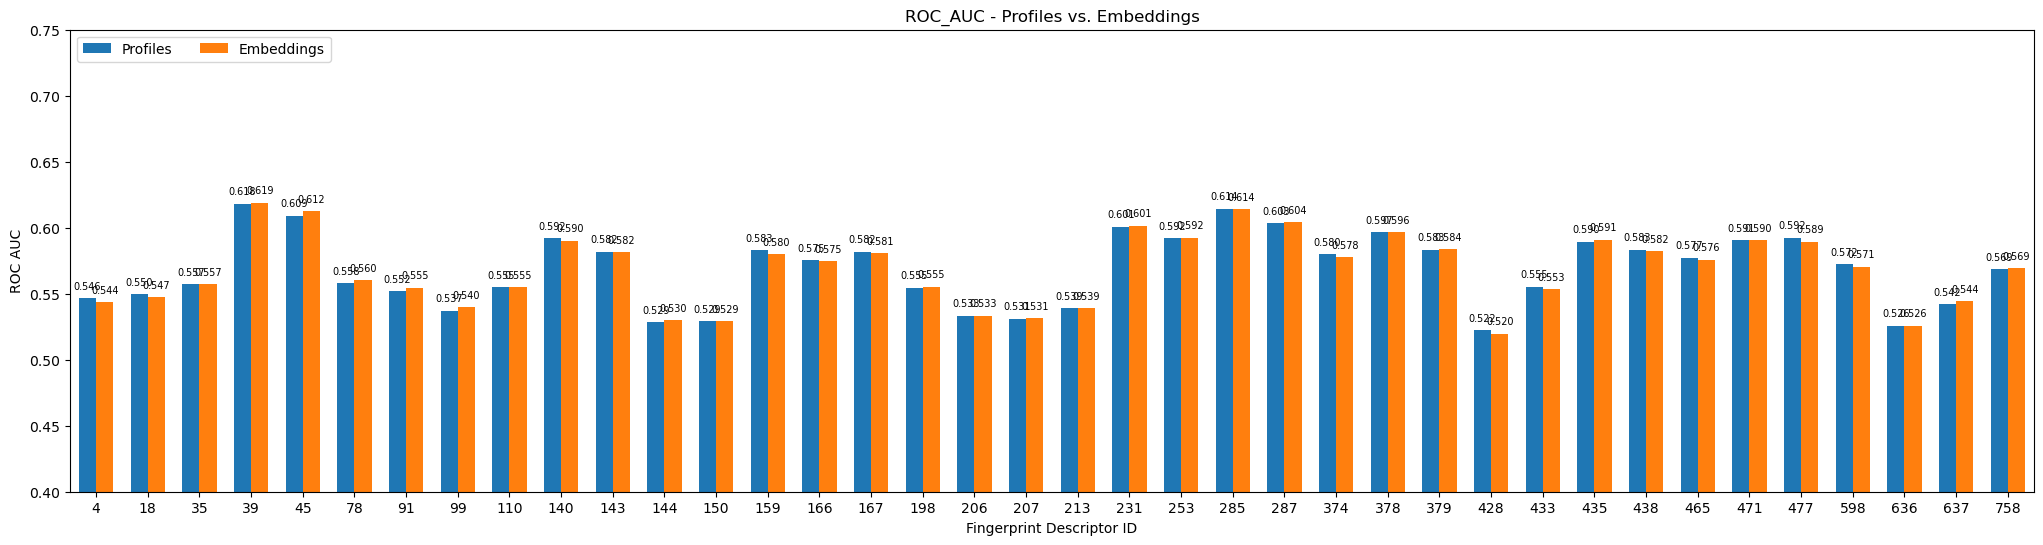

In [138]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-1.0, 0.0, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

44

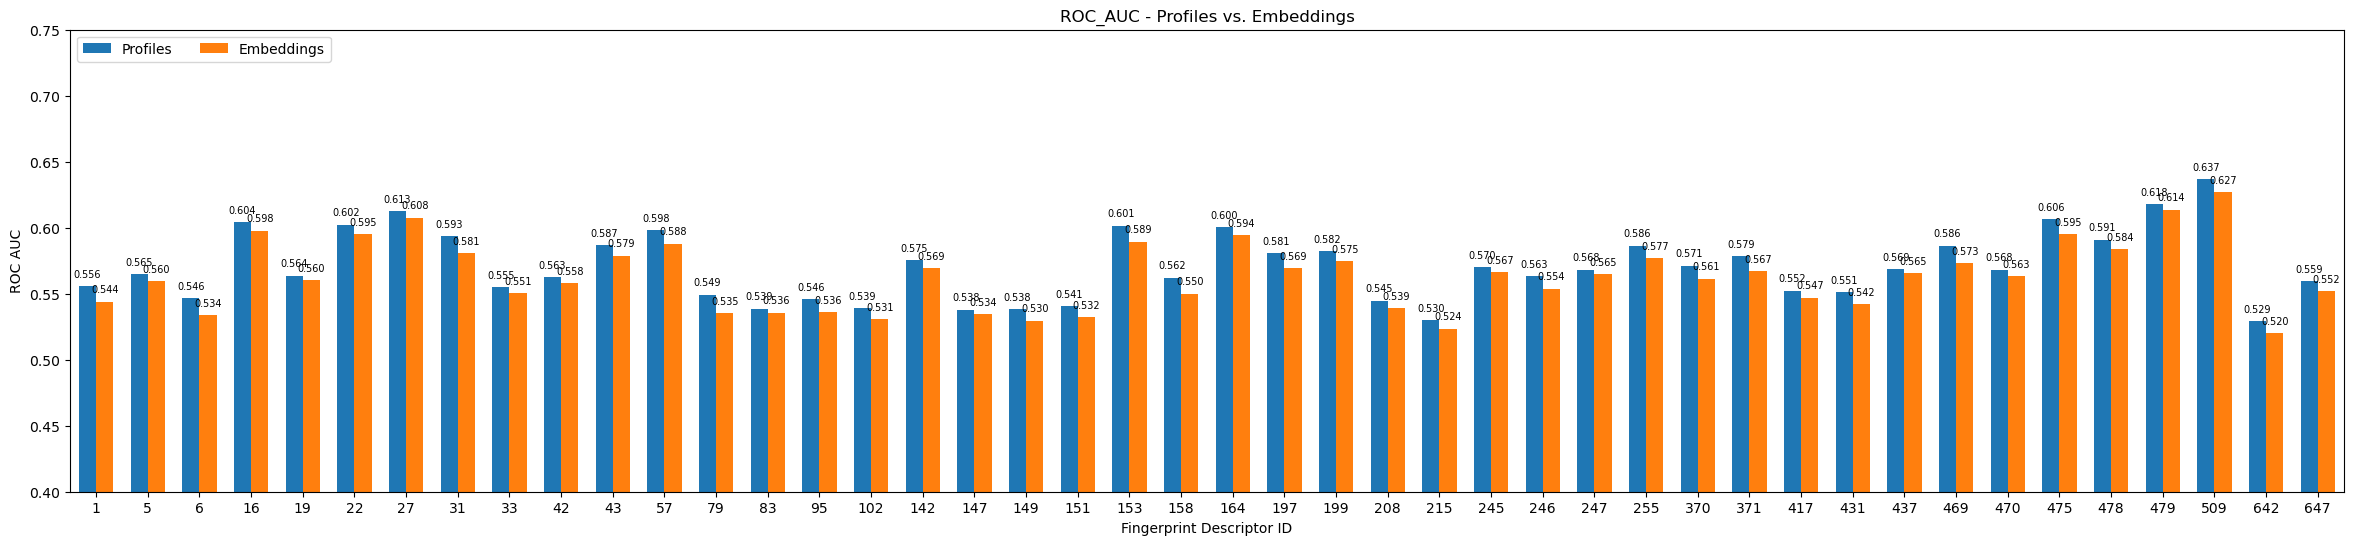

In [139]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-2.5, -1.0, 'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

16

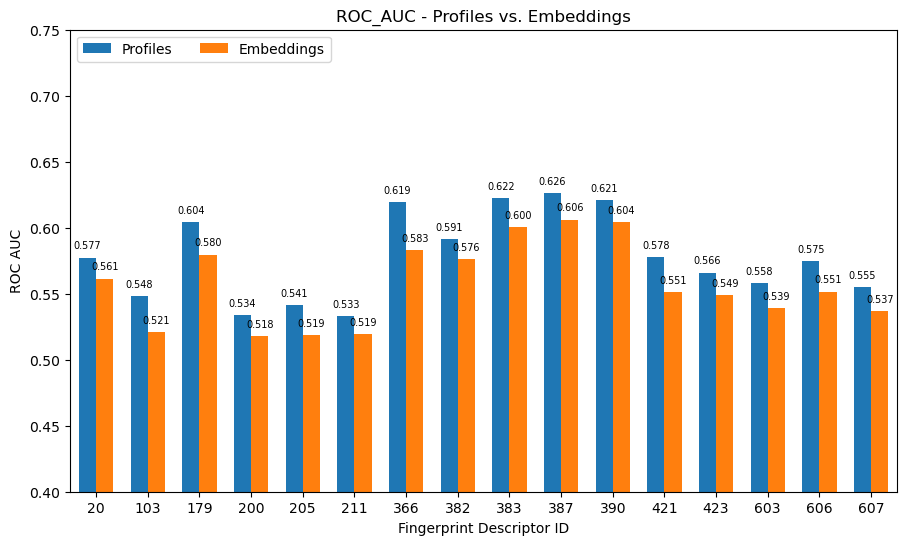

In [140]:
indicies = df_metrics[df_metrics.ms_diff_pct_grp.between(-25.0, -2.5,'right')].index
len(indicies)
metrics_bar_chart(df_metrics, indicies, column = 'mean_test_score')

## Comparative Bar charts - 2

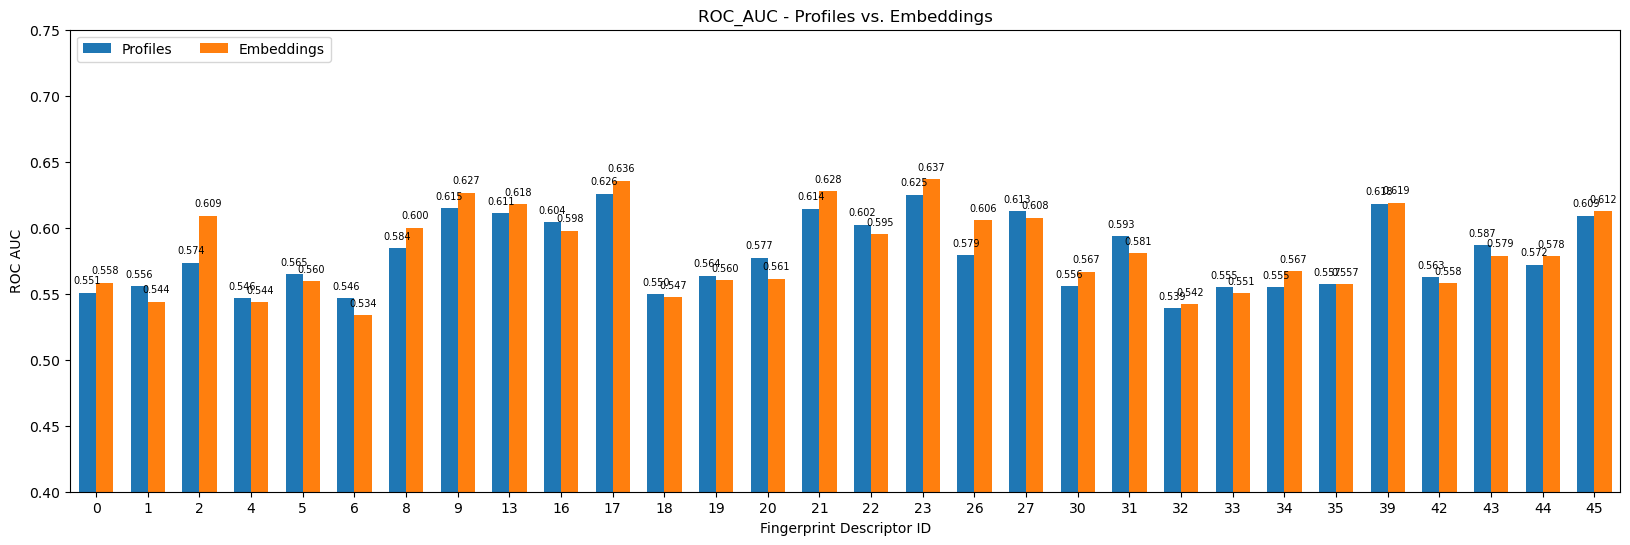

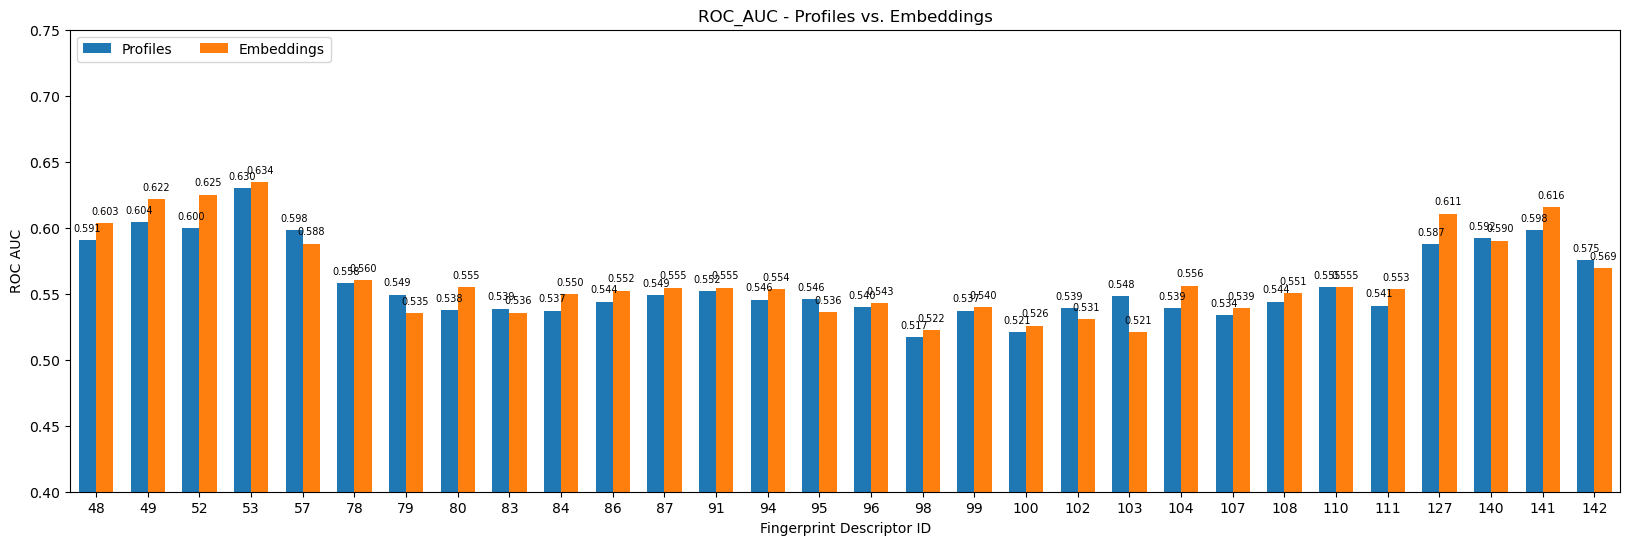

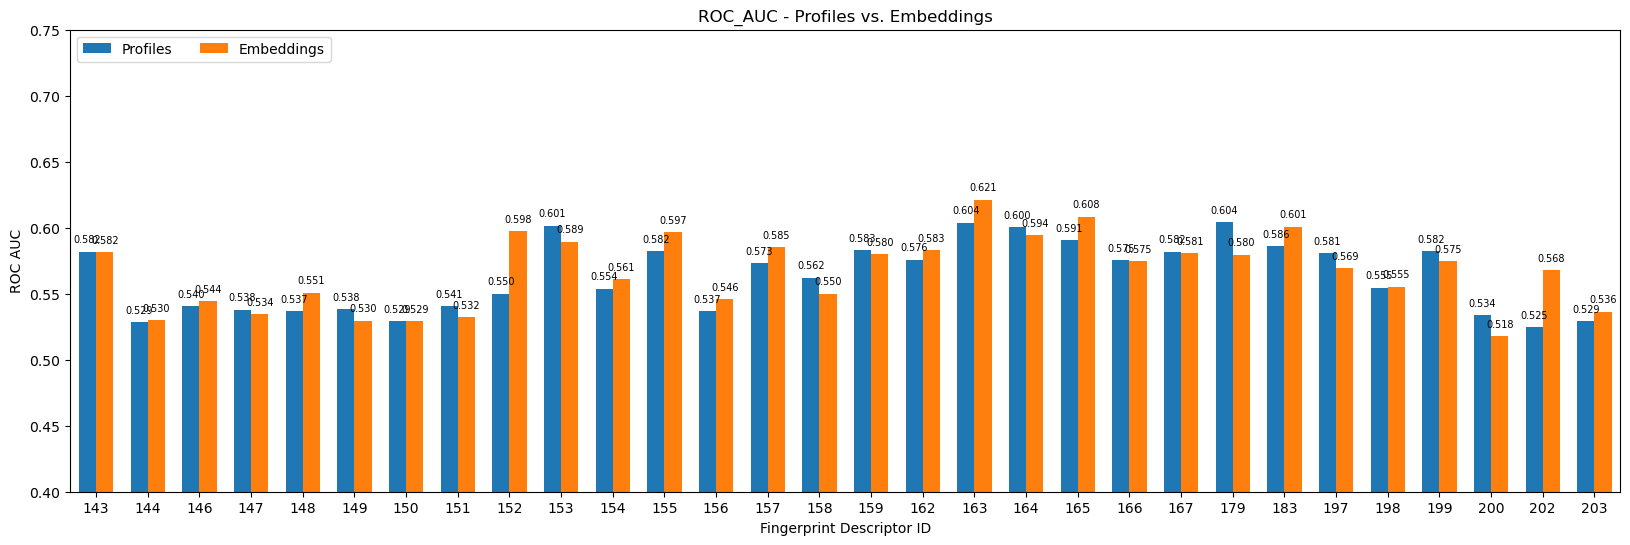

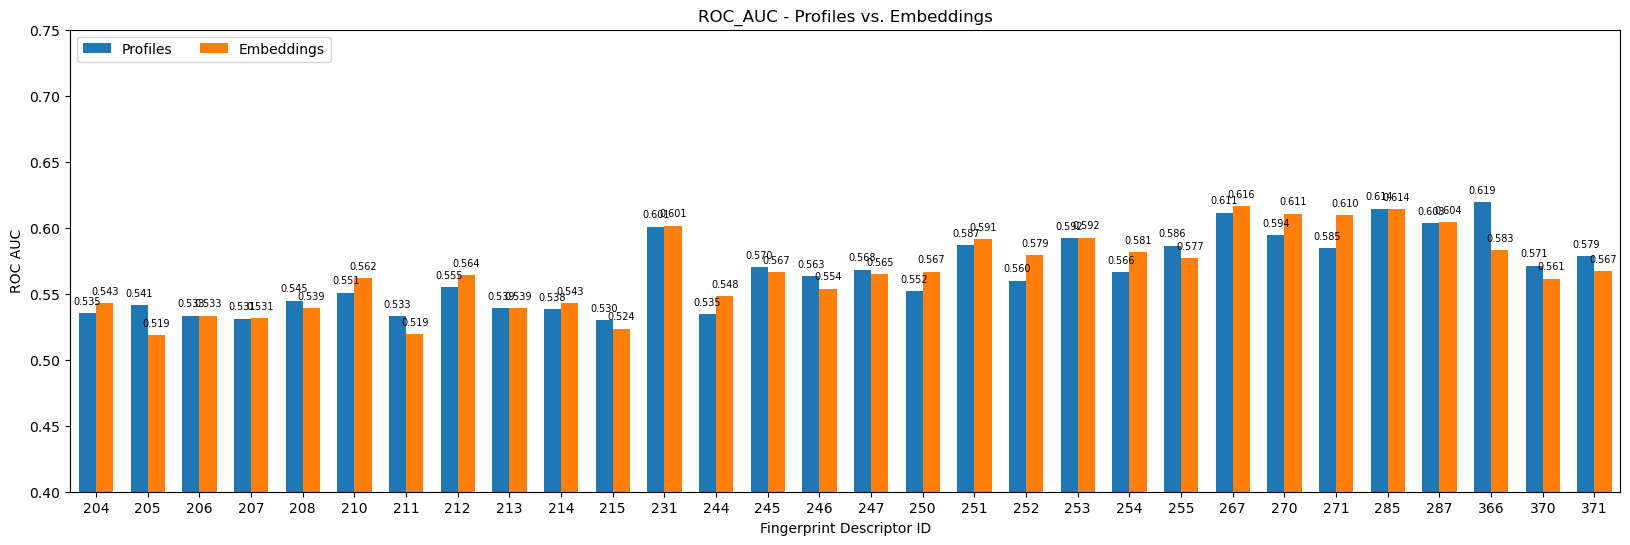

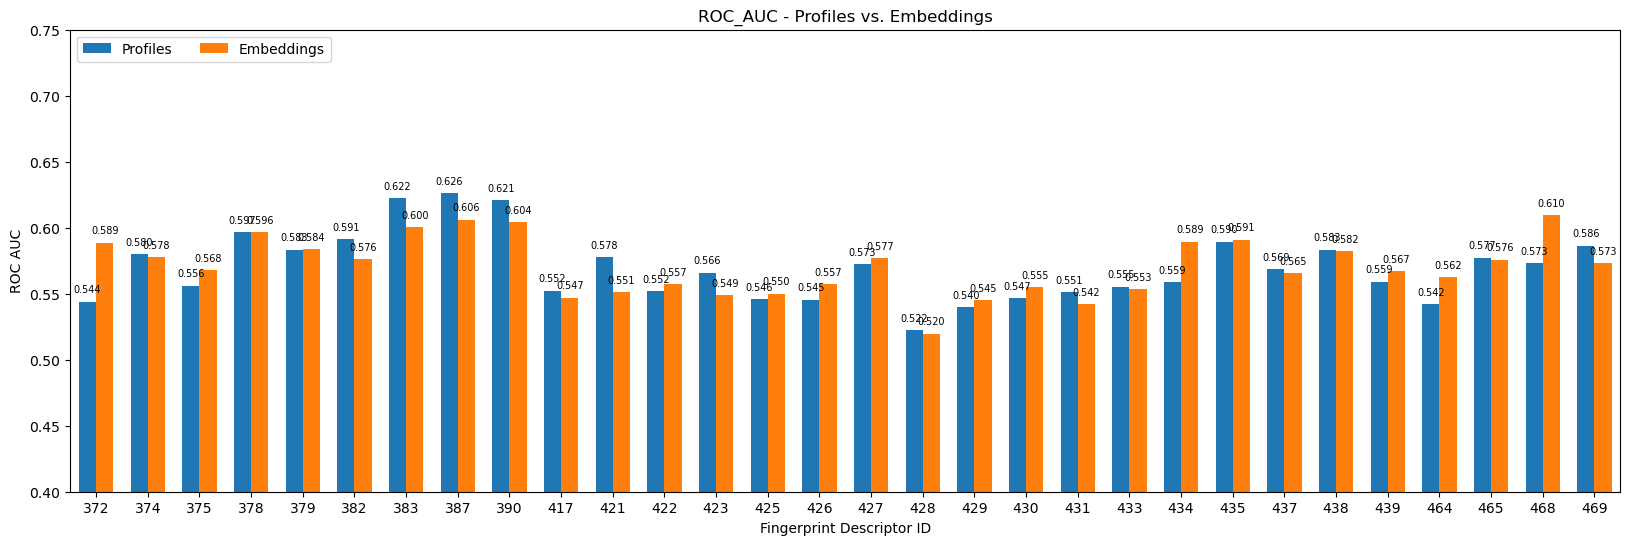

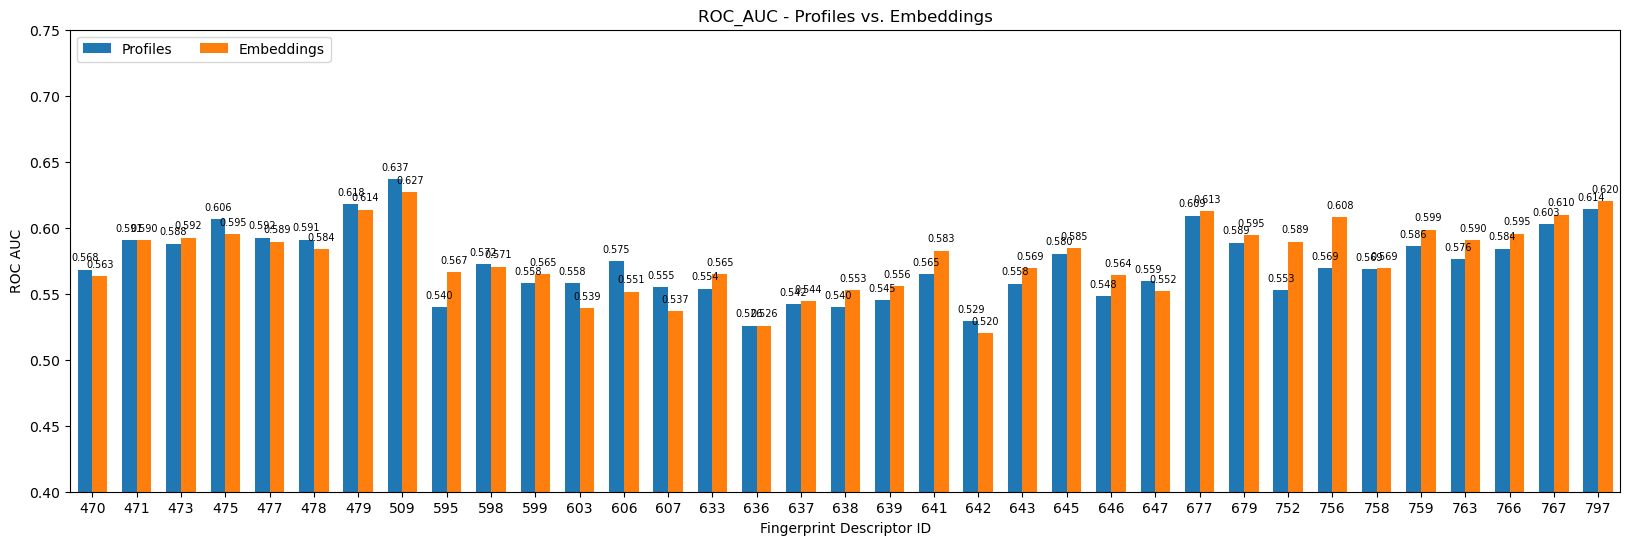

In [111]:
comparative_bar_chart(profile_metrics, embedded_metrics, start=  0, end =30, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 30, end =60, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 60, end =90, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 90, end =120, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 120, end =150, column = 'mean_test_score')
comparative_bar_chart(profile_metrics, embedded_metrics, start= 150, end =185, column = 'mean_test_score')
# comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start= 0, end  =10, column = 'mean_test_score')

## Comparative Bar charts - 3 , Chart Per Group

In [185]:
df_metrics.loc[8]

Y_bit                                             13
Y_bit_pct                                   0.246071
Y_bit_pct_grp                                    2.0
mean_test_score_p                           0.611199
mean_test_score_e                           0.617714
ms_diff                                     0.006515
ms_diff_grp                                      1.0
ms_diff_pct                                      1.1
ms_diff_pct_grp                                  1.0
ms_diff_norm                                0.045438
fp_groups                      Acceptor PosIonizable
Y_bit_description    Acceptor PosIonizable |0 1|1 0|
precision_p                                 0.628743
accuracy_p                                   0.76246
recall_p                                    0.034585
f1_p                                        0.065564
precision_e                                 0.621951
accuracy_e                                  0.760635
recall_e                                    0.

Acceptor Acceptor Index([0, 1], dtype='int64')
Acceptor Acceptor Acceptor Index([35, 36], dtype='int64')
Acceptor Acceptor Aromatic Index([37, 38, 39, 40, 41], dtype='int64')
Acceptor Acceptor Donor Index([42, 43, 44], dtype='int64')
Acceptor Acceptor Hydrophobe Index([45, 46, 47, 48, 49, 50], dtype='int64')
Acceptor Acceptor LumpedHydrophobe Index([51, 52, 53, 54, 55], dtype='int64')
Acceptor Acceptor PosIonizable Index([56], dtype='int64')
Acceptor Aromatic Index([2], dtype='int64')
Acceptor Aromatic Aromatic Index([57, 58, 59, 60], dtype='int64')
Acceptor Aromatic Donor Index([61, 62, 63, 64, 65, 66, 67], dtype='int64')
Acceptor Aromatic Hydrophobe Index([68, 69, 70, 71, 72, 73, 74, 75], dtype='int64')
Acceptor Aromatic LumpedHydrophobe Index([76, 77, 78, 79, 80, 81], dtype='int64')
Acceptor Aromatic PosIonizable Index([82, 83], dtype='int64')
Acceptor Donor Index([3, 4], dtype='int64')
Acceptor Donor Donor Index([84, 85, 86], dtype='int64')
Acceptor Donor Hydrophobe Index([87, 88, 

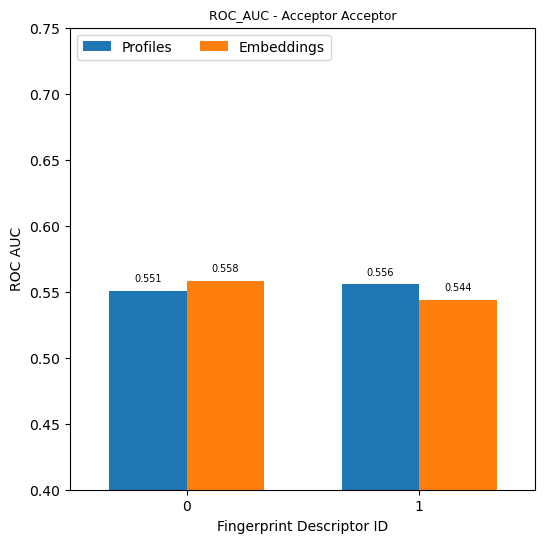

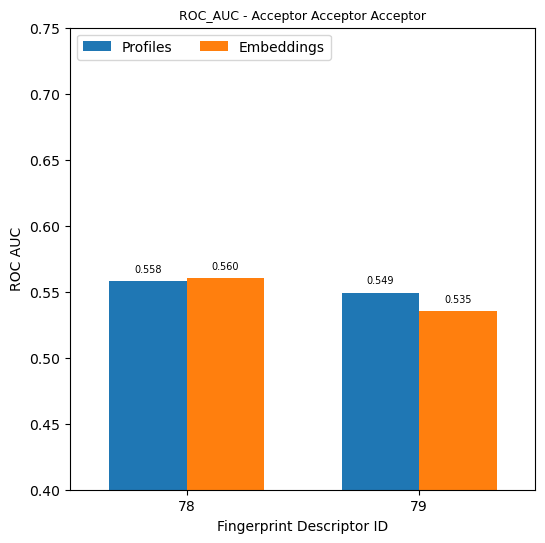

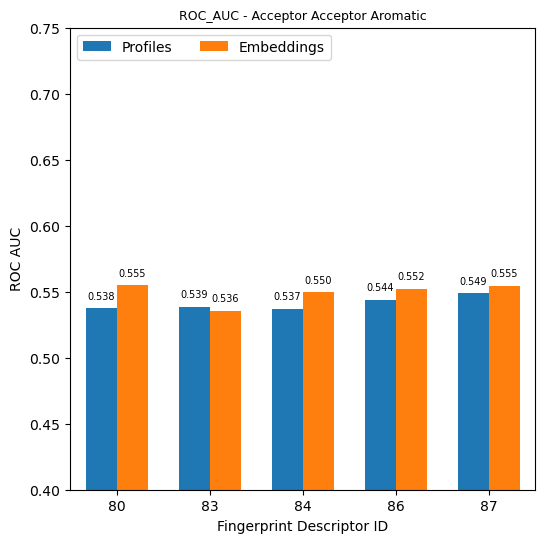

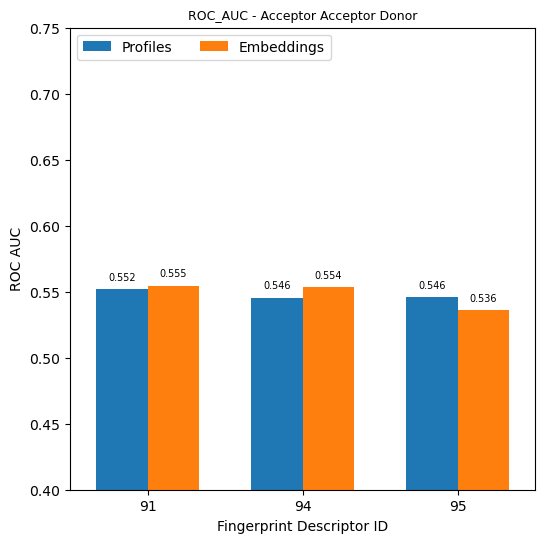

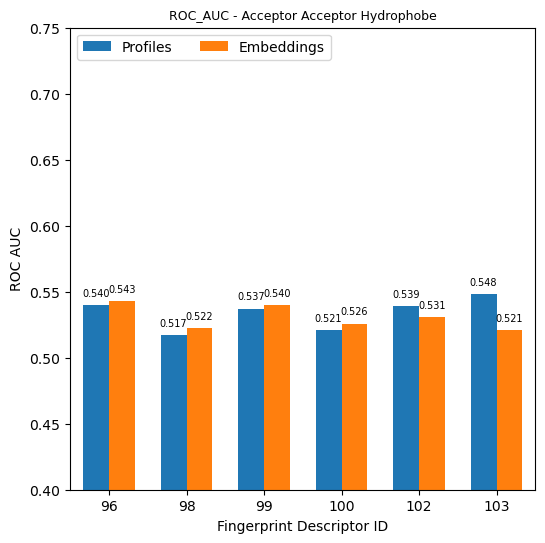

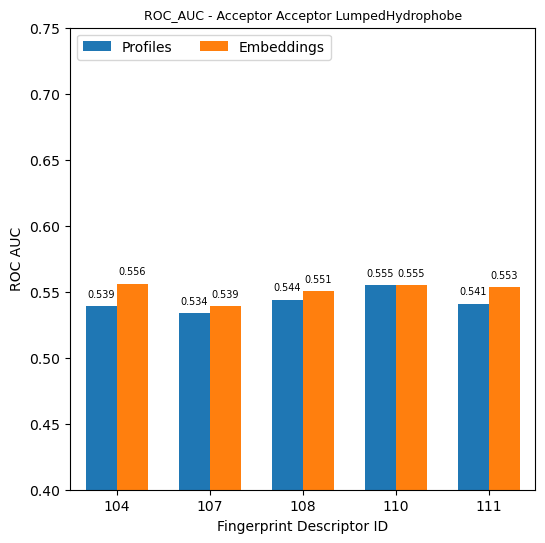

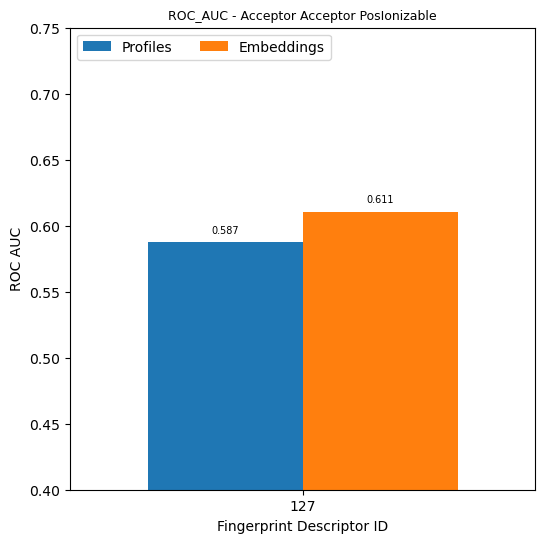

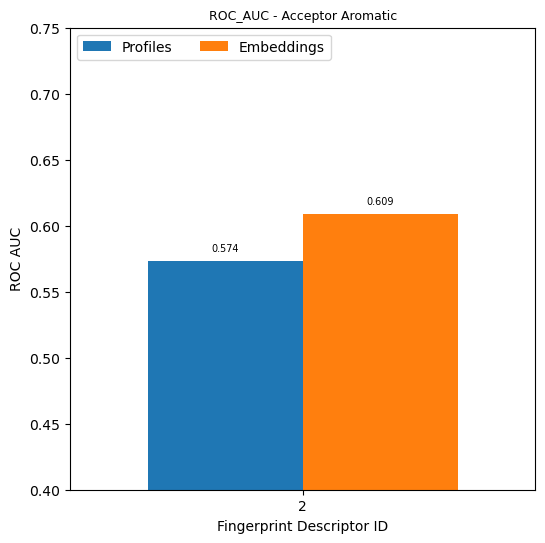

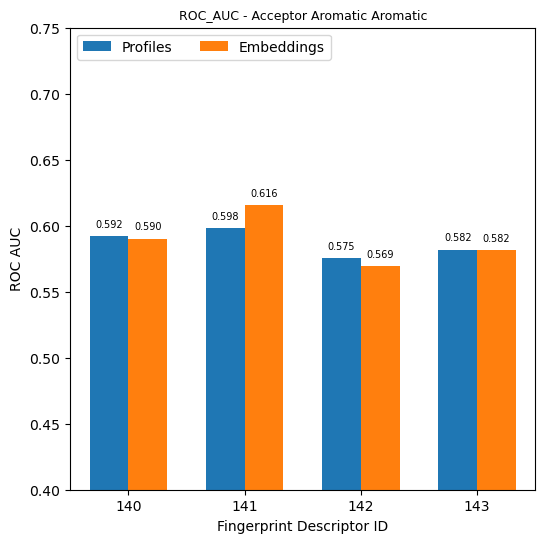

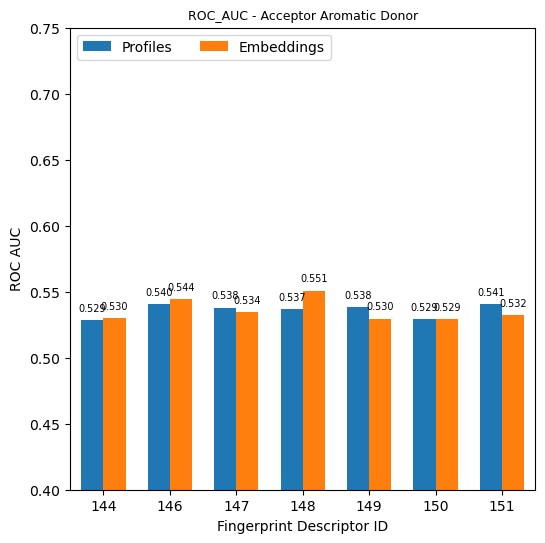

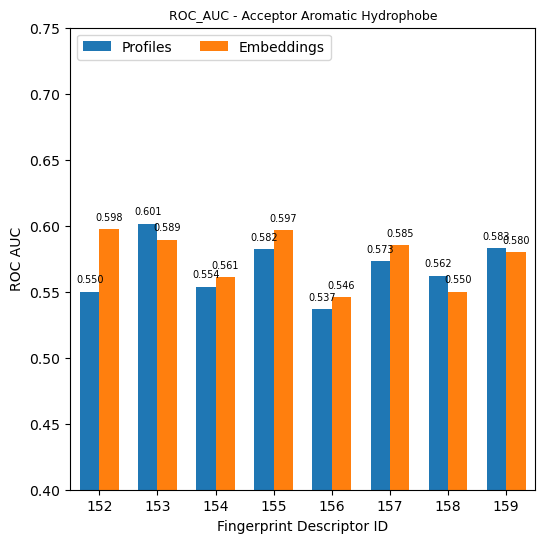

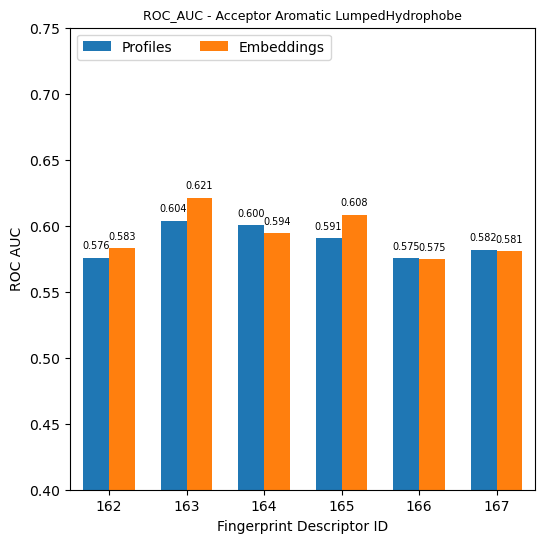

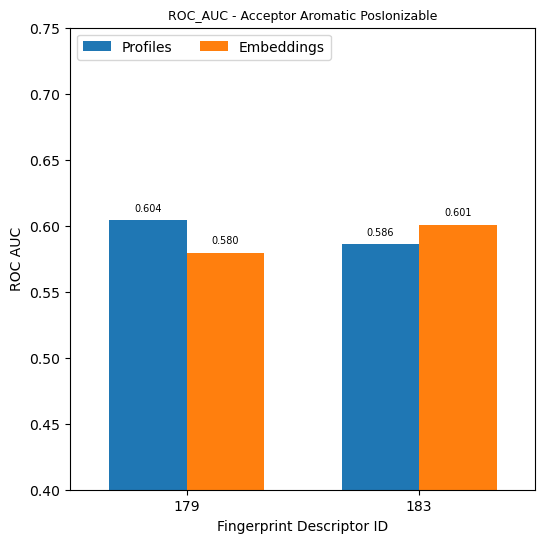

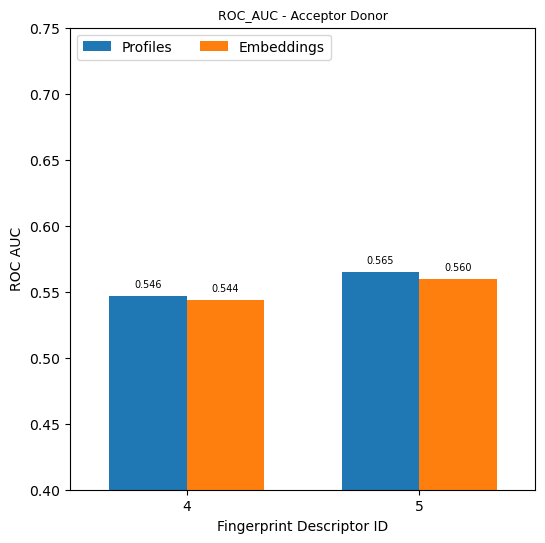

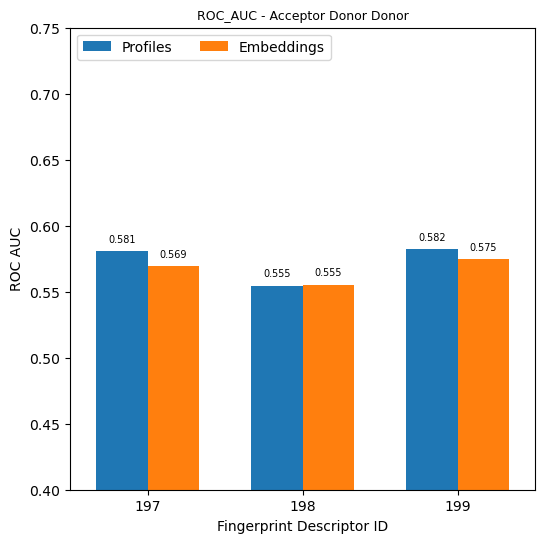

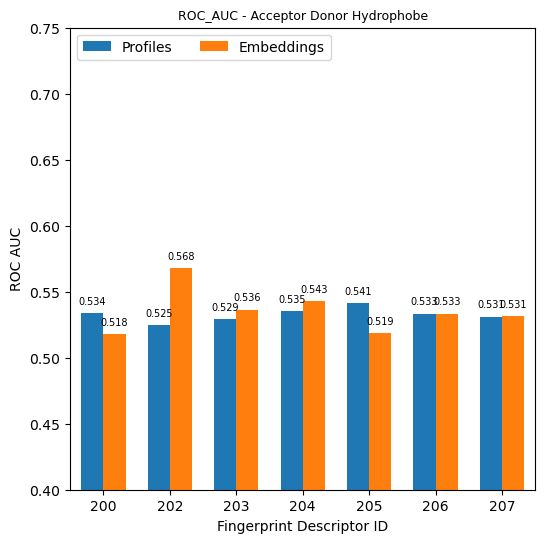

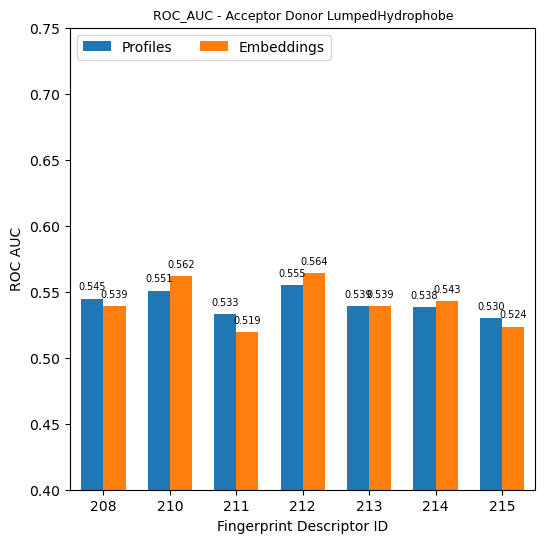

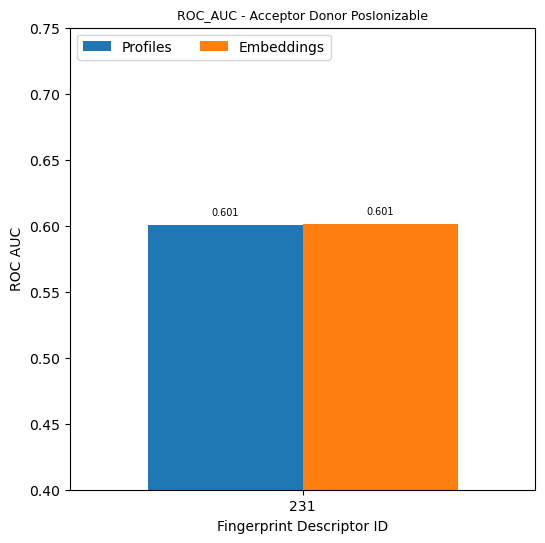

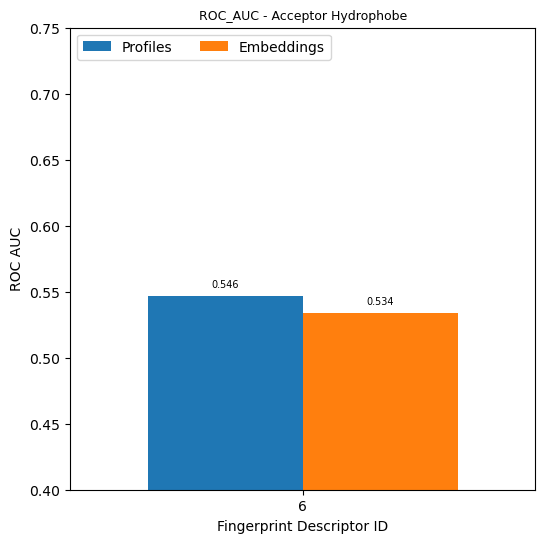

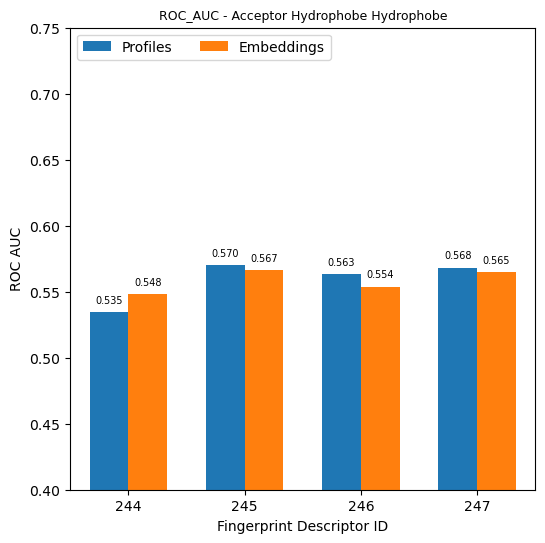

In [261]:
for fp_grp in FP_GROUPS[:20]:
    group_indices = grouped_data_indicies[fp_grp]
    print(fp_grp, group_indices)
    metrics_bar_chart(df_metrics, group_indices, column = 'mean_test_score', title = fp_grp)

/tmp/ipykernel_3765599/1143729081.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(fig_width,6))


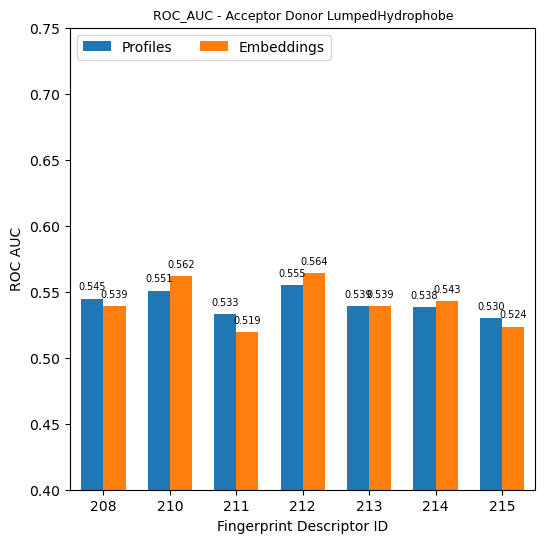

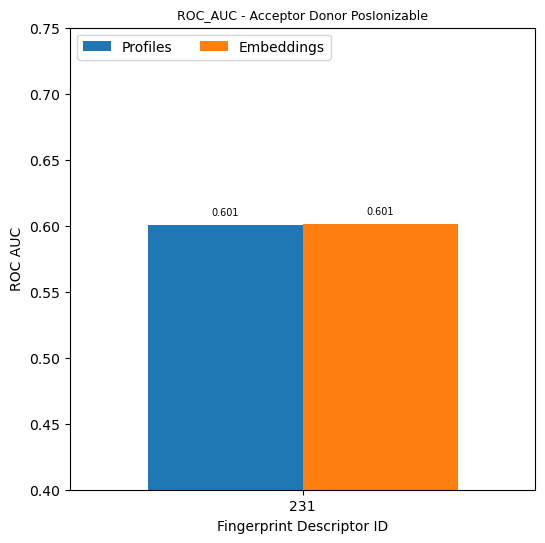

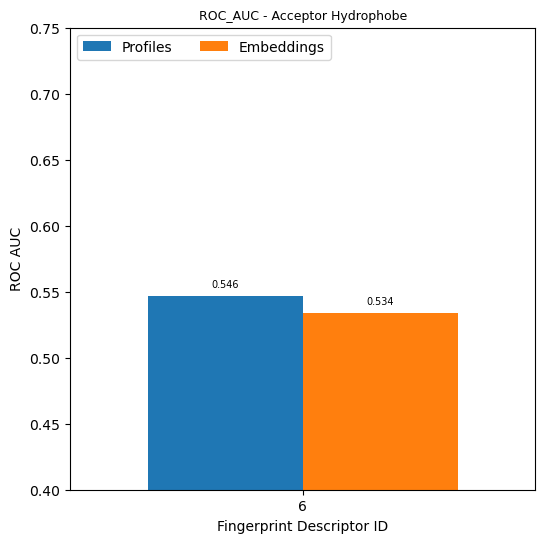

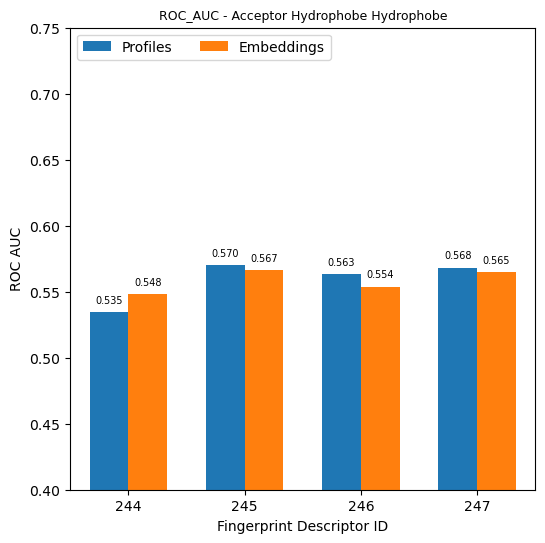

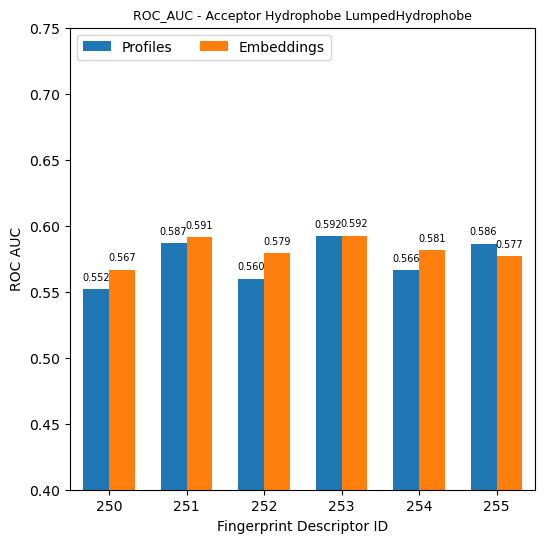

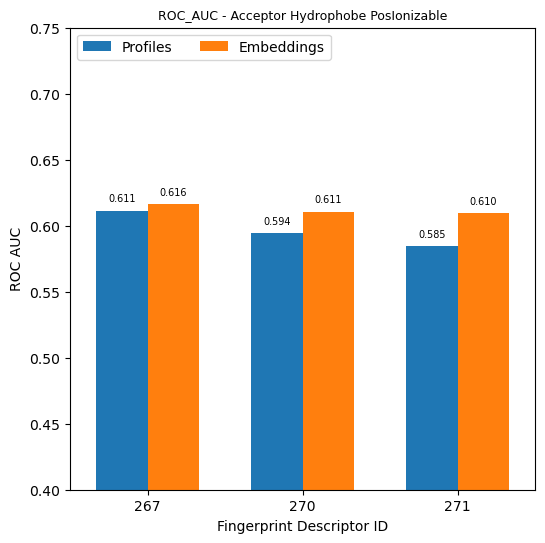

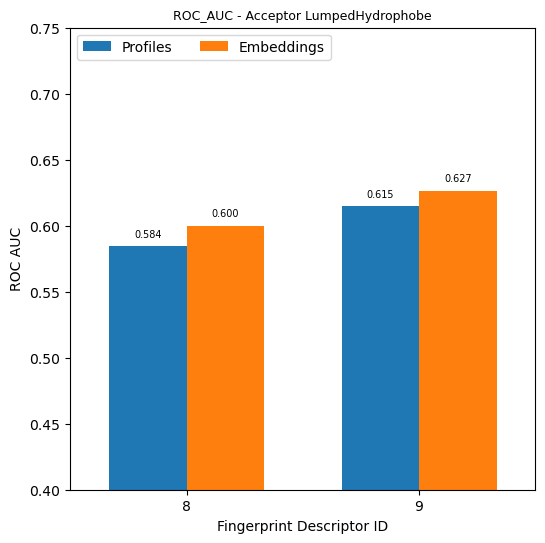

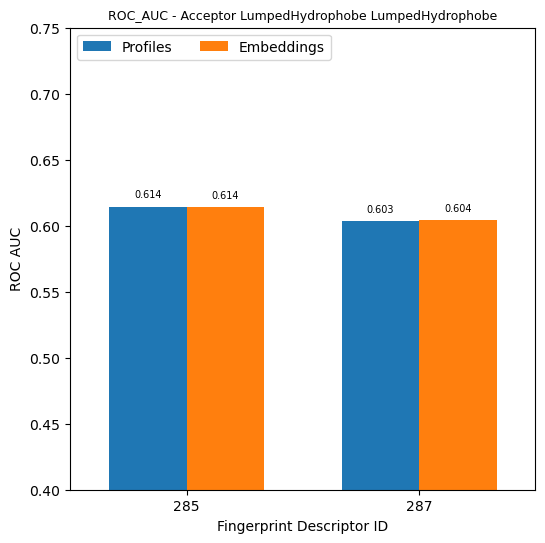

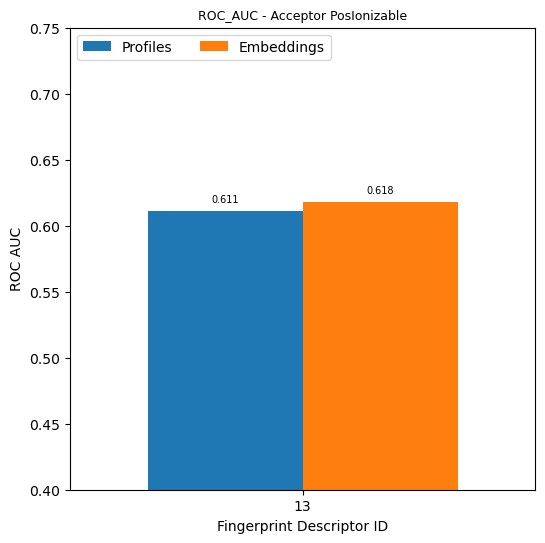

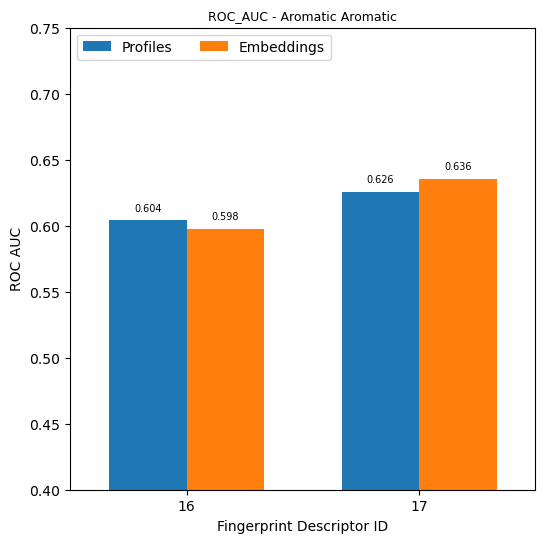

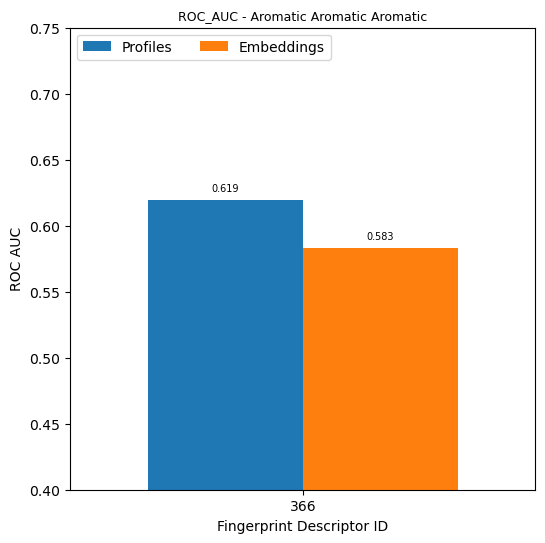

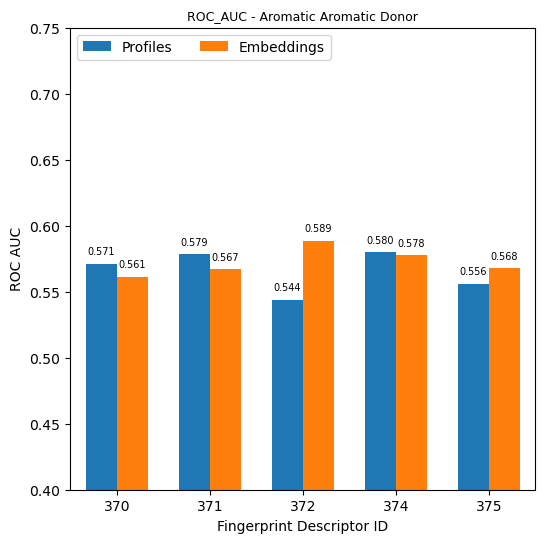

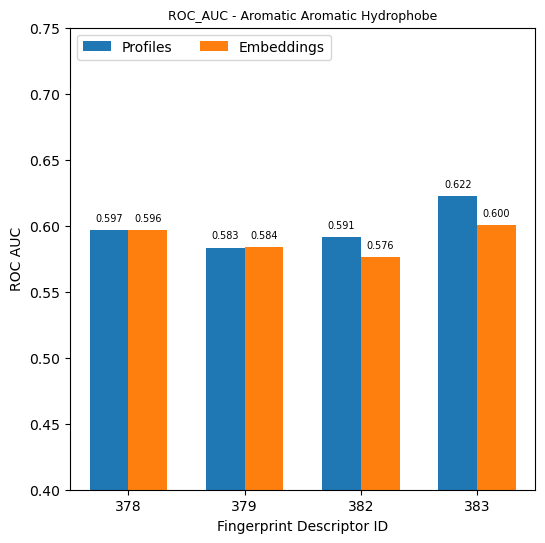

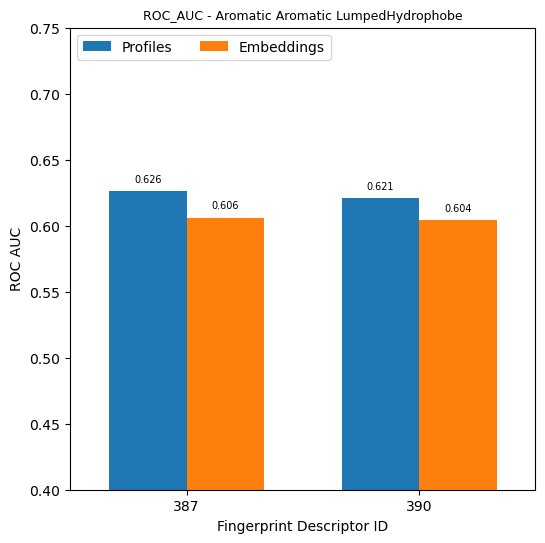

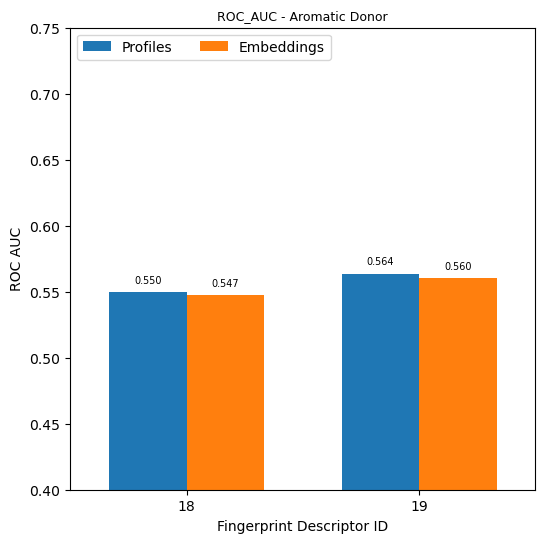

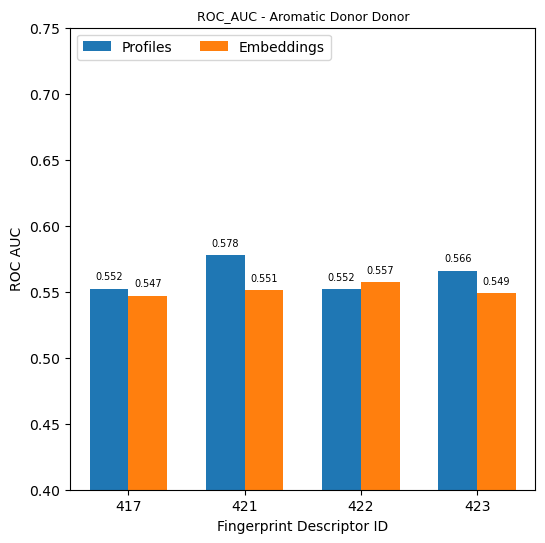

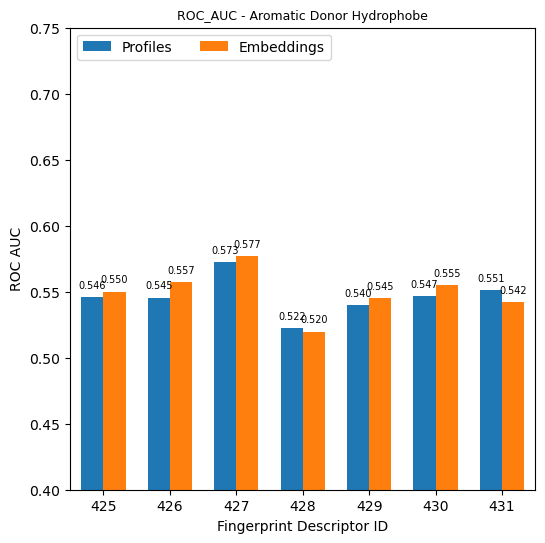

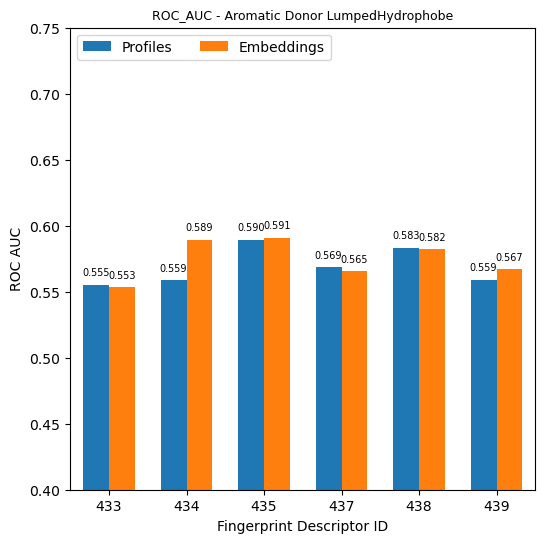

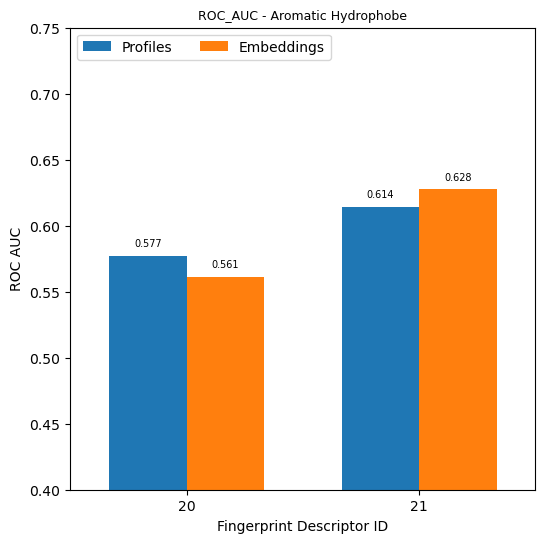

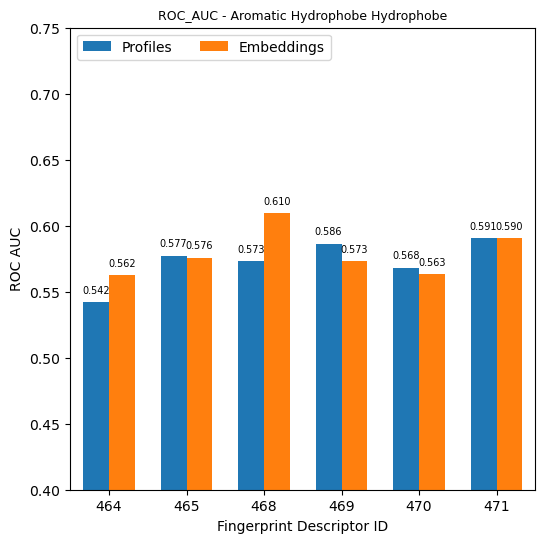

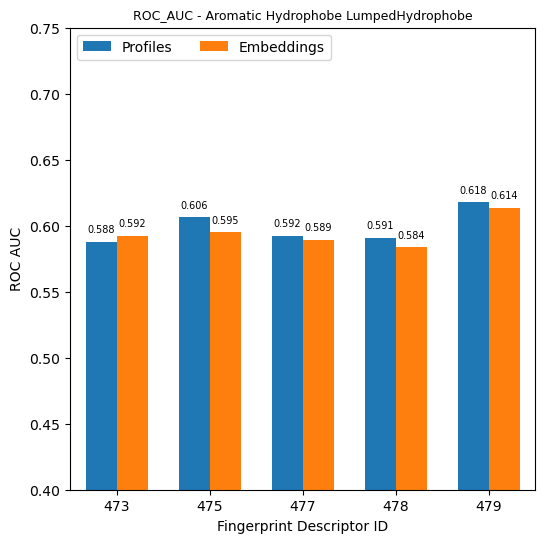

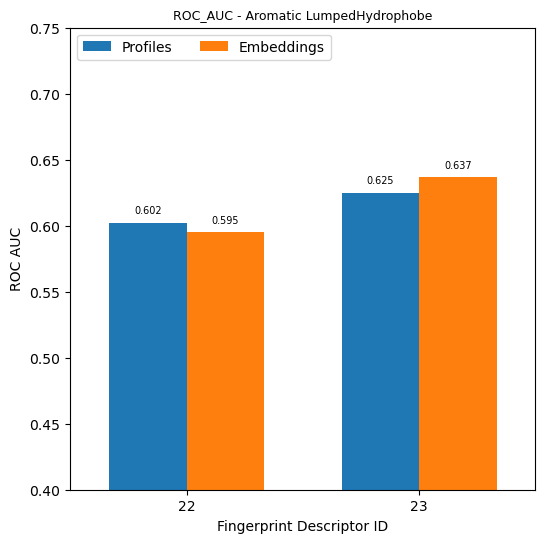

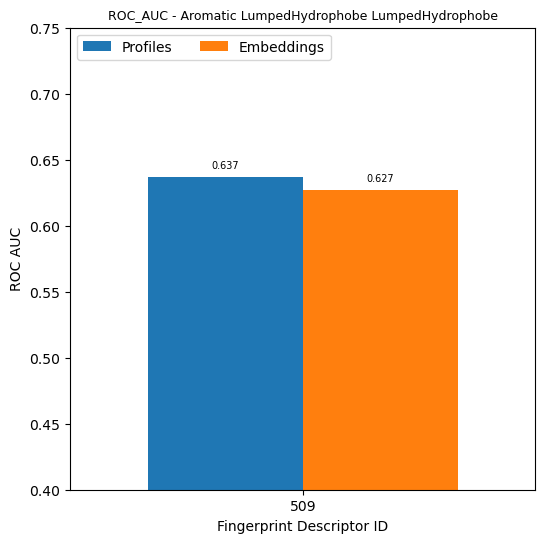

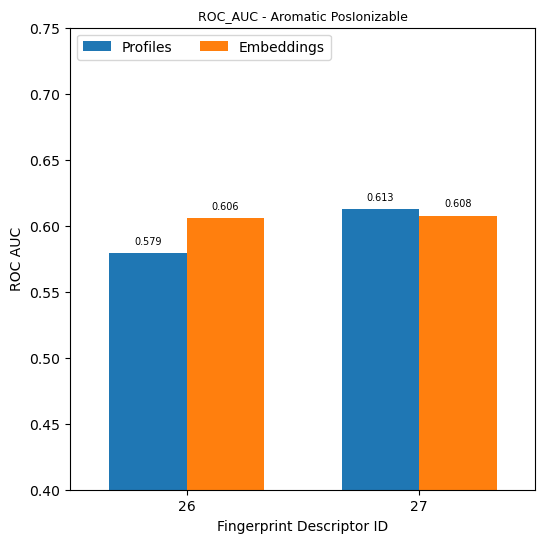

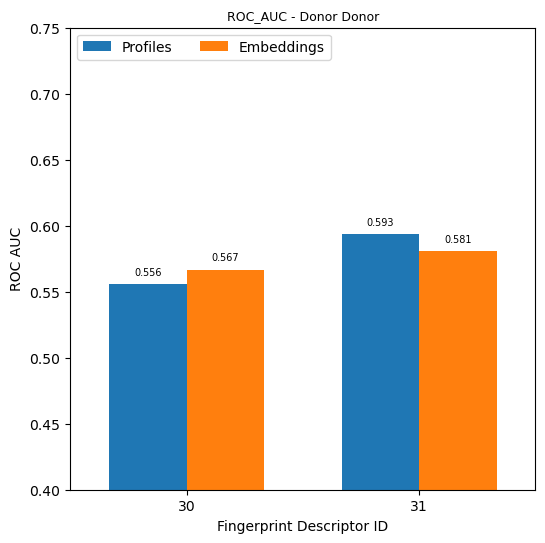

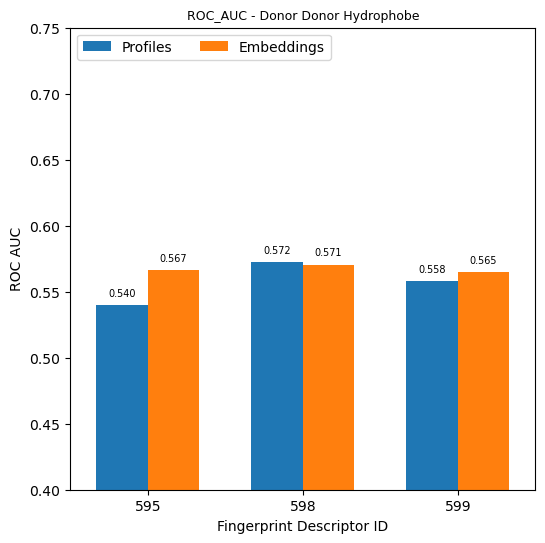

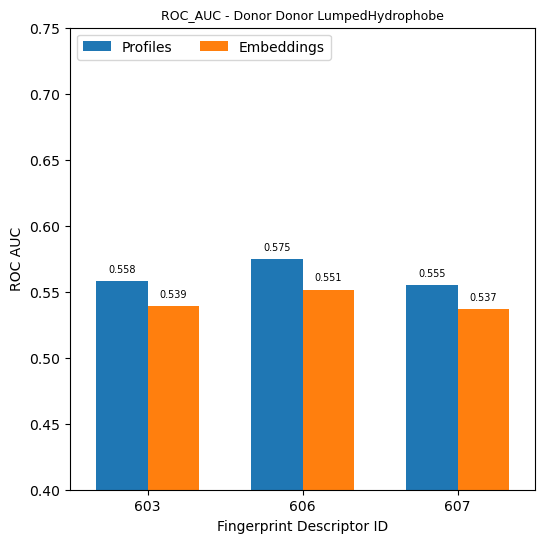

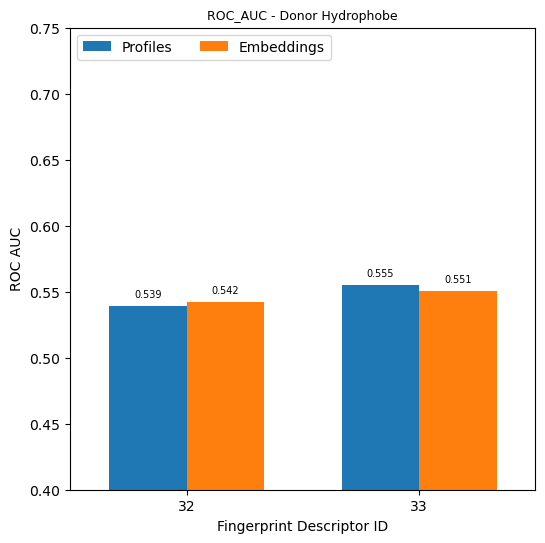

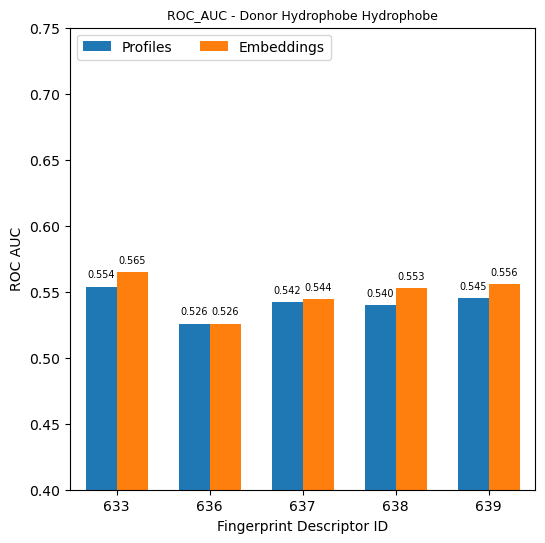

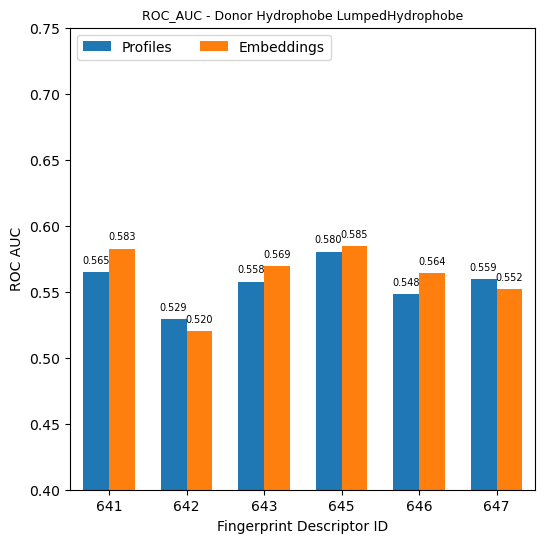

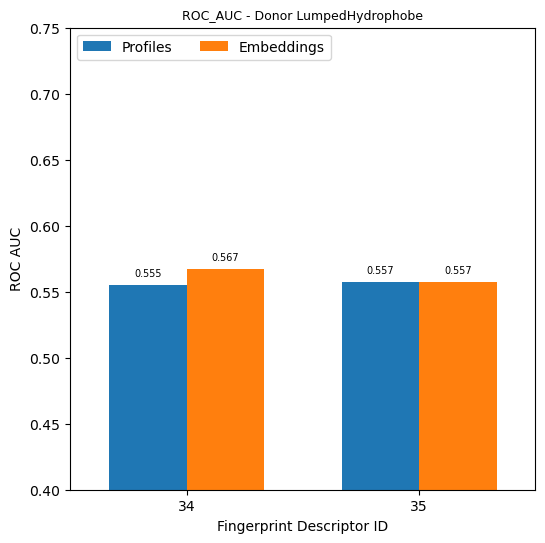

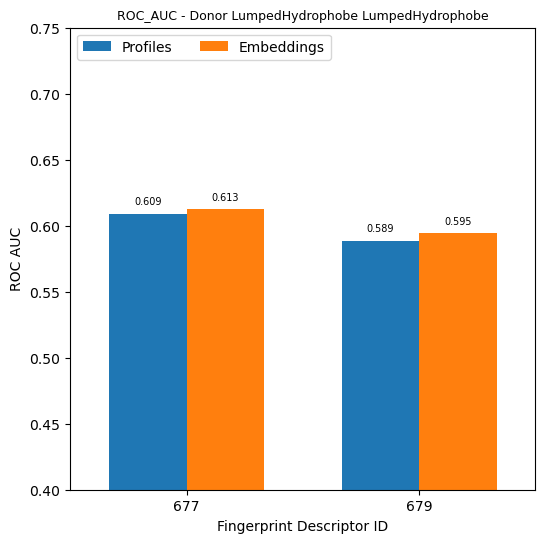

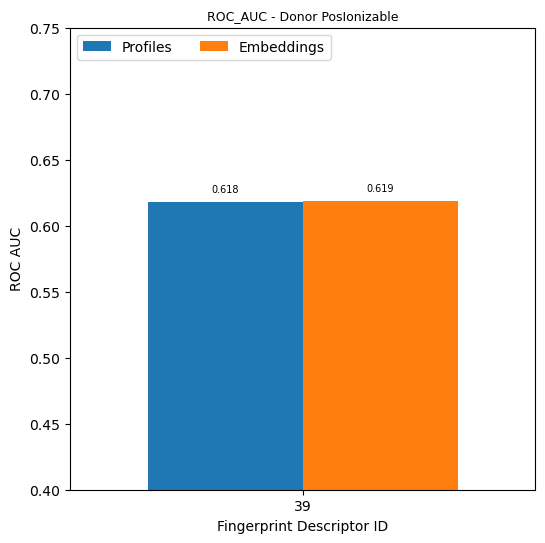

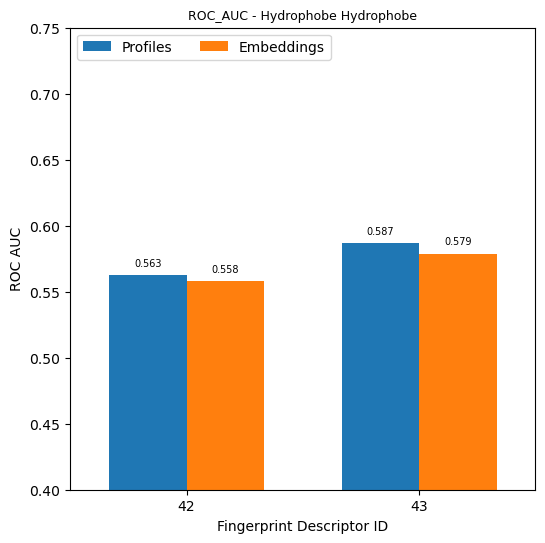

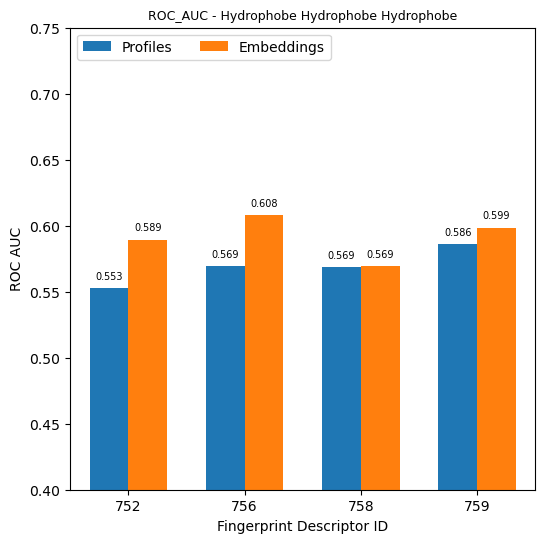

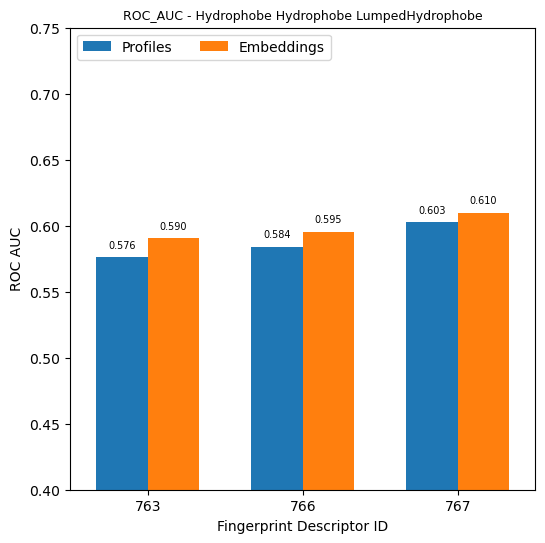

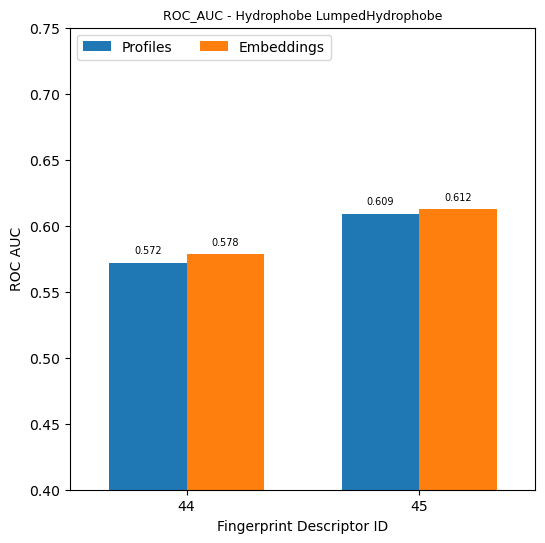

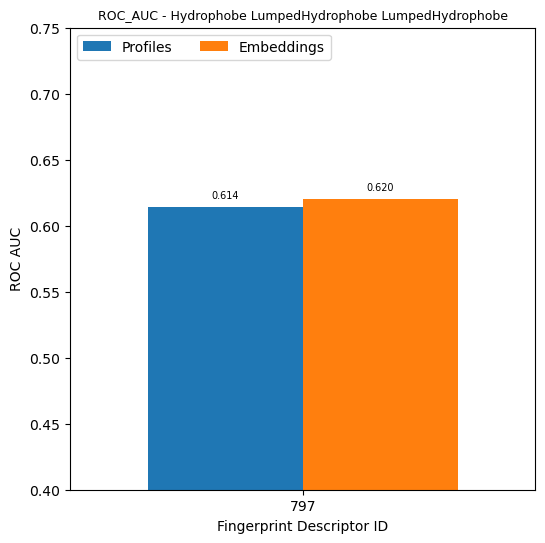

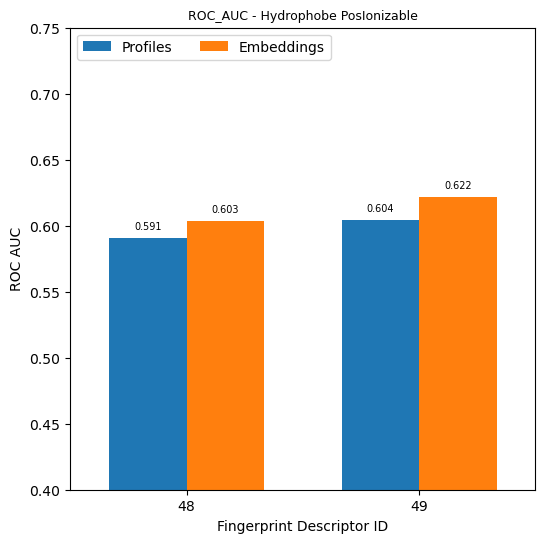

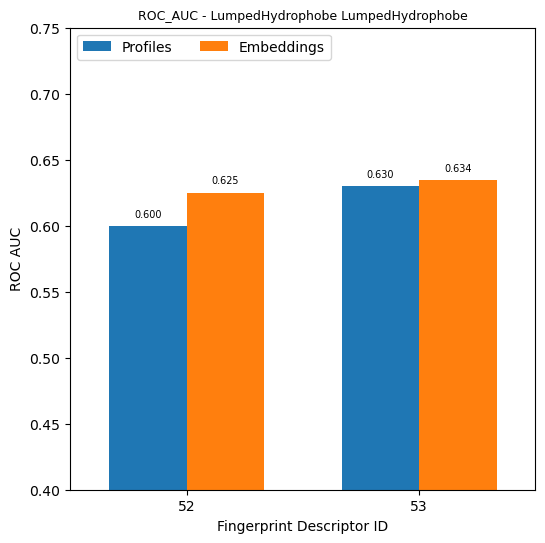

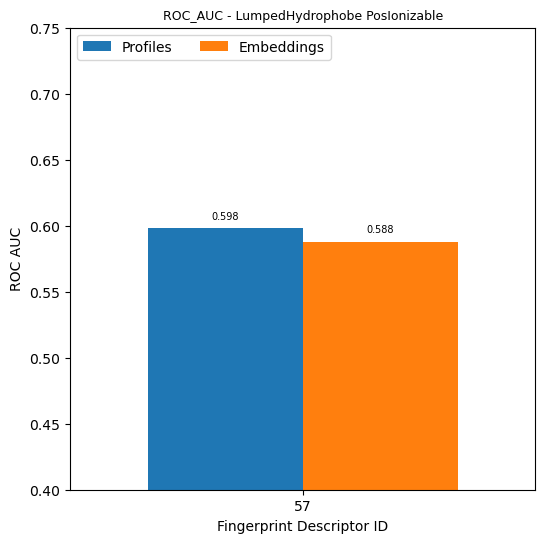

In [264]:
for fp_grp in FP_GROUPS[16:]:
    group_indices = grouped_data_indicies[fp_grp]
    metrics_bar_chart(df_metrics, group_indices, column = 'mean_test_score', title = fp_grp)

# 1032 Fingerprint - Bits with classification ROC AUC > 0.60

     Embedded score improvement < 0%      :  0  (  0.0 %)
     Embedded score improvement 0% to 5%  : 29  ( 80.5 %) 
     Embedded score improvement 5% to 10% :  6  ( 16.7 %) 
     Embedded score improvement > 10%     :  1  (  2.7 %) 
    
     Total:                                 36

In [214]:

EMBEDDED_METRICS_FILENAME = f'PFP_LogReg_embeddings_bits_over60_20241106_0700_bestparm_metrics.csv'
PROFILES_METRICS_FILENAME = f'PFP_LogReg_profiles_bits_over60_20241106_0700_bestparm_metrics.csv'

In [215]:
embedded_best_metrics = pd.read_csv(os.path.join(EMBEDDED_METRICS_PATH, EMBEDDED_METRICS_FILENAME))
profile_best_metrics  = pd.read_csv(os.path.join(PROFILES_METRICS_PATH, PROFILES_METRICS_FILENAME))

In [214]:

EMBEDDED_METRICS_FILENAME = f'PFP_LogReg_embeddings_bits_over60_20241106_0700_bestparm_metrics.csv'
PROFILES_METRICS_FILENAME = f'PFP_LogReg_profiles_bits_over60_20241106_0700_bestparm_metrics.csv'

In [215]:
embedded_best_metrics = pd.read_csv(os.path.join(EMBEDDED_METRICS_PATH, EMBEDDED_METRICS_FILENAME))
profile_best_metrics  = pd.read_csv(os.path.join(PROFILES_METRICS_PATH, PROFILES_METRICS_FILENAME))

In [216]:
# embedded_best_metrics
# profile_best_metrics

In [218]:
s_diff = (( embedded_best_metrics.mean_test_score - profile_best_metrics.mean_test_score ) / profile_best_metrics.mean_test_score) * 100
s_diff.min(), s_diff.max()
s_diff[:10]

(0.17226998078899408, 10.40405146028055)

0    7.676173
1    4.119566
2    5.952114
3    2.779199
4    3.840219
5    4.463015
6    3.847079
7    3.366890
8    0.172270
9    1.753323
Name: mean_test_score, dtype: float64

In [211]:
print()
print(f" num of bits where Embedded score improvement < 0%      : {(s_diff < 0.00).sum()} ")
print(f" num of bits where Embedded score improvement 0% to 5%  : {s_diff.between(0.0, 5.0, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement 5% to 10% : {s_diff.between(5.0, 10.00, inclusive = 'left').sum()}")
print(f" num of bits where Embedded score improvement > 10%     : {(s_diff >= 10.00).sum()}  ")
print()
# print(f" num of bits where Profile Score > Embedded score : {df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'both')]})


 num of bits where Embedded score improvement < 0%      : 0 
 num of bits where Embedded score improvement 0% to 5%  : 29
 num of bits where Embedded score improvement 5% to 10% : 6
 num of bits where Embedded score improvement > 10%     : 1  



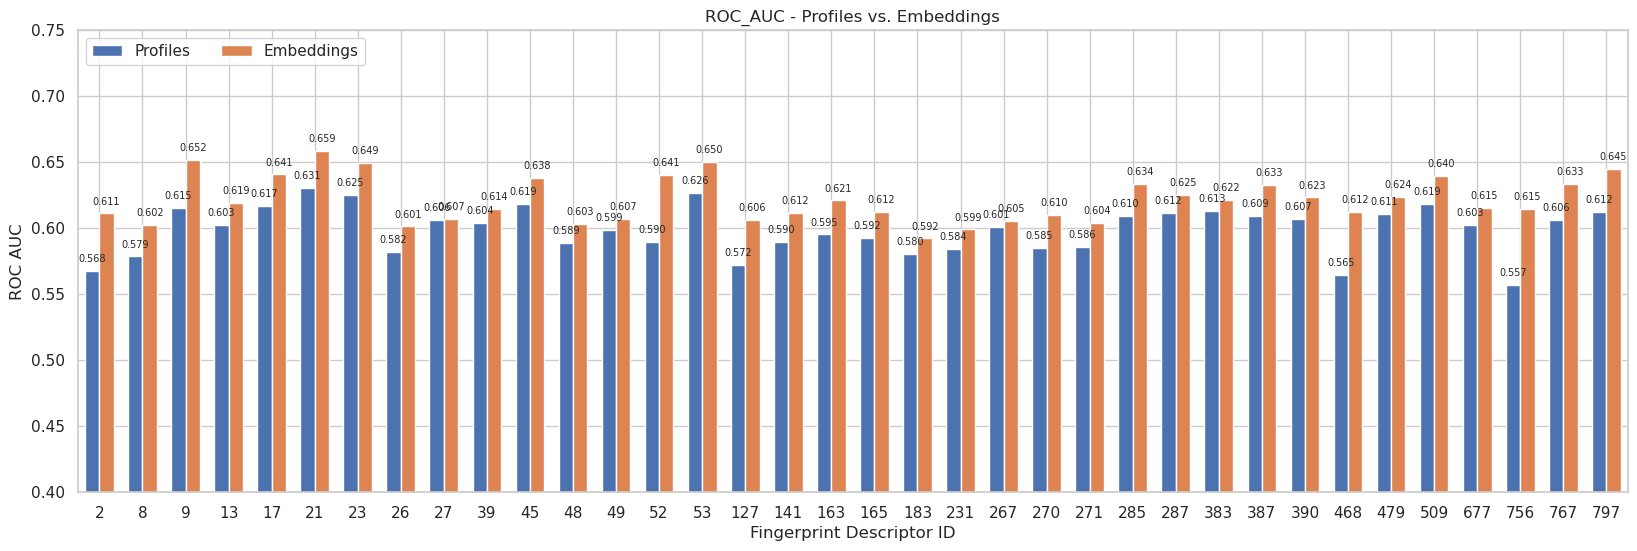

In [213]:
comparative_bar_chart(profile_best_metrics, embedded_best_metrics, start=  0, end = 38, column = 'mean_test_score')

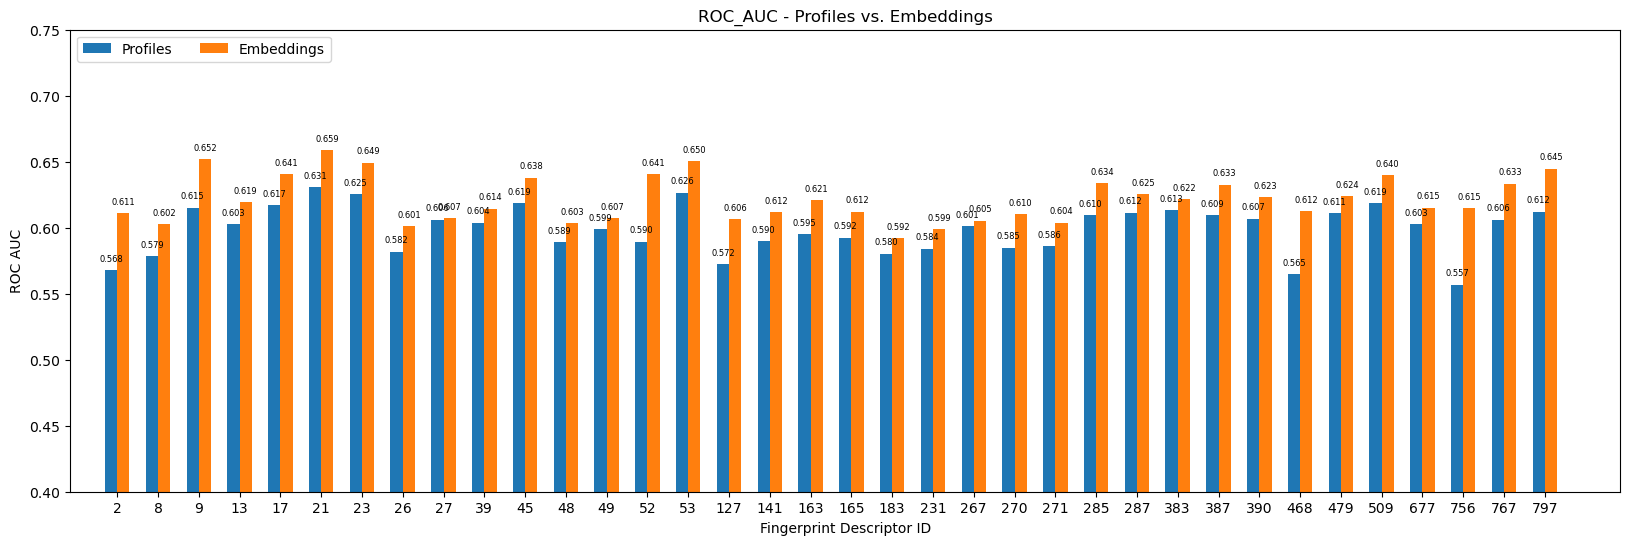

In [184]:
# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

Fingerprint_bits = profile_best_metrics.Y_bit
scores = {
    'Profiles': profile_best_metrics.mean_test_score,
    'Embeddings': embedded_best_metrics.mean_test_score,
}

x = np.arange(len(Fingerprint_bits))  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

# fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
fig, ax = plt.subplots(figsize=(20,6))

# for attribute, measurement in test_scores.items():
offset = width * multiplier
rects = ax.bar(x + offset, scores['Profiles'] , width, label='Profiles')
_ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');
multiplier += 1
offset = width * multiplier
rects = ax.bar(x + offset, scores['Embeddings'] , width, label='Embeddings')
_ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = ax.set_ylabel('ROC AUC')
_ = ax.set_xlabel('Fingerprint Descriptor ID')
_ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
_ = ax.set_xticks(x + width/2, Fingerprint_bits)
_ = ax.legend(loc='upper left', ncols=3)
_ = ax.set_ylim(0.4, 0.75)
_ = ax.set_xlim(-1, 37)
 


# Misc

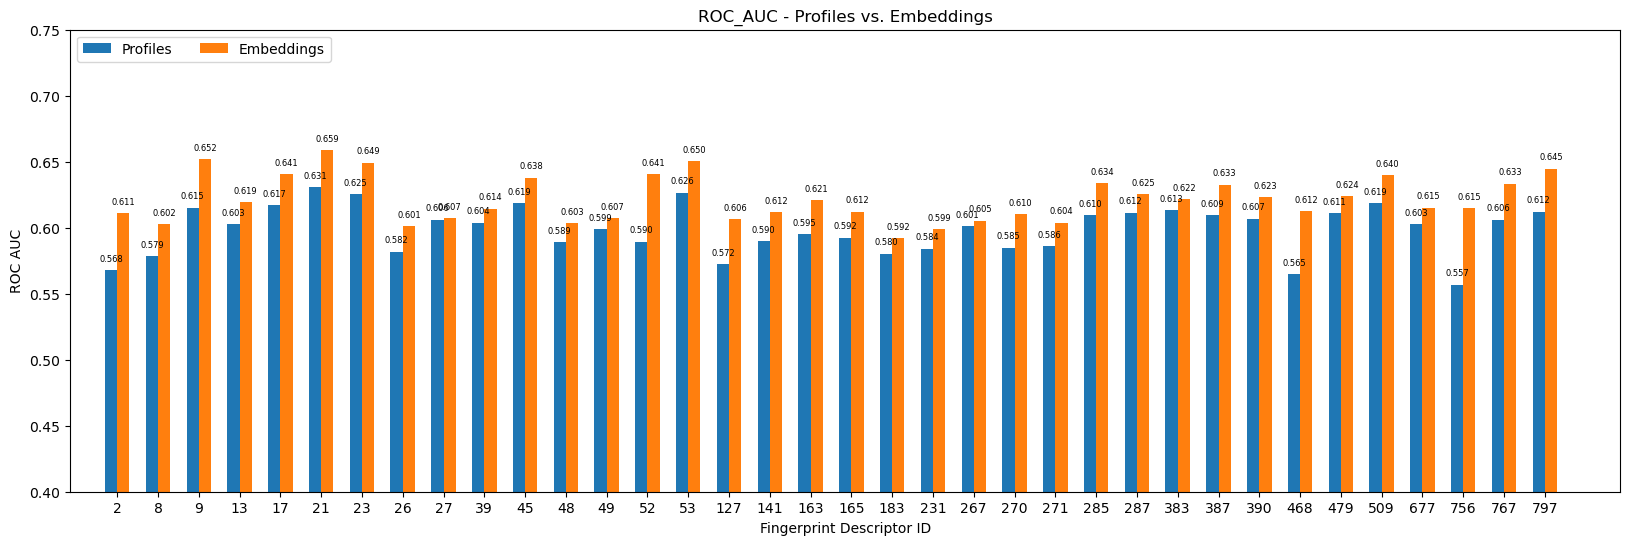

In [184]:
# data from https://allisonhorst.github.io/palmerpenguins/

# import matplotlib.pyplot as plt
# import numpy as np

# Fingerprint_bits = profile_best_metrics.Y_bit
# scores = {
#     'Profiles': profile_best_metrics.mean_test_score,
#     'Embeddings': embedded_best_metrics.mean_test_score,
# }

# x = np.arange(len(Fingerprint_bits))  # the label locations
# width = 0.3  # the width of the bars
# multiplier = 0

# # fig, ax = plt.subplots(layout='constrained',figsize=(10,4))
# fig, ax = plt.subplots(figsize=(20,6))

# # for attribute, measurement in test_scores.items():
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Profiles'] , width, label='Profiles')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');
# multiplier += 1
# offset = width * multiplier
# rects = ax.bar(x + offset, scores['Embeddings'] , width, label='Embeddings')
# _ = ax.bar_label(rects, padding=5, size=6, fmt = '%0.3f');

# # Add some text for labels, title and custom x-axis tick labels, etc.
# _ = ax.set_ylabel('ROC AUC')
# _ = ax.set_xlabel('Fingerprint Descriptor ID')
# _ = ax.set_title('ROC_AUC - Profiles vs. Embeddings')
# _ = ax.set_xticks(x + width/2, Fingerprint_bits)
# _ = ax.legend(loc='upper left', ncols=3)
# _ = ax.set_ylim(0.4, 0.75)
# _ = ax.set_xlim(-1, 37)
 
